In [1]:
from apd.aggregation.query import with_database
from apd.aggregation.database import datapoint_table

with with_database("postgresql+psycopg2://apd@localhost/apd") as session:
    print(session.query(datapoint_table).count())

53635


In [2]:
from apd.aggregation.query import with_database, get_data

with with_database("postgresql+psycopg2://apd@localhost/apd") as session:
    count = 0
    async for datapoint in get_data():
        count += 1
    print(count)

53635


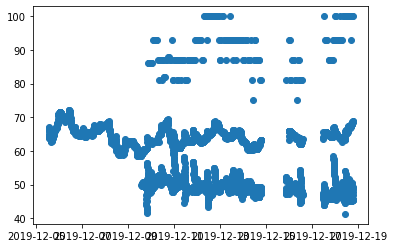

In [3]:
from apd.aggregation.query import with_database, get_data

from matplotlib import pyplot as plt

async def plot():
    points = [(dp.collected_at, dp.data) async for dp in get_data() if dp.sensor_name=="RelativeHumidity"]
    x, y = zip(*points)
    plt.plot_date(x, y, "o", xdate=True)

with with_database("postgresql+psycopg2://apd@localhost/apd") as session:
    await plot()
plt.show()

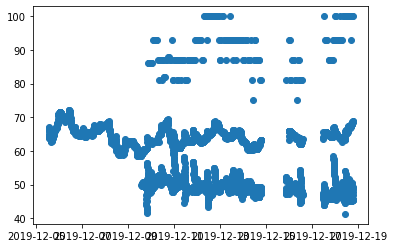

In [4]:
from apd.aggregation.query import with_database, get_data

from matplotlib import pyplot as plt

async def plot():
    points = [(dp.collected_at, dp.data) async for dp in get_data(sensor_name="RelativeHumidity")]
    x, y = zip(*points)
    plt.plot_date(x, y, "o", xdate=True)

with with_database("postgresql+psycopg2://apd@localhost/apd") as session:
    await plot()
plt.show()

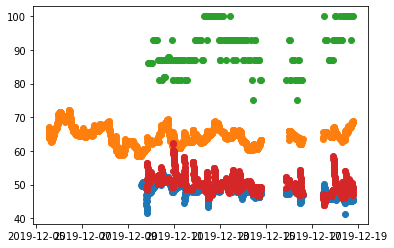

In [5]:
import collections

from apd.aggregation.query import with_database, get_data

from matplotlib import pyplot as plt

async def plot():
    legends = collections.defaultdict(list)
    async for dp in get_data(sensor_name="RelativeHumidity"):
        legends[dp.deployment_id].append((dp.collected_at, dp.data))

    for deployment_id, points in legends.items():
        x, y = zip(*points)
        plt.plot_date(x, y, "o", xdate=True)

with with_database("postgresql+psycopg2://apd@localhost/apd") as session:
    await plot()
plt.show()

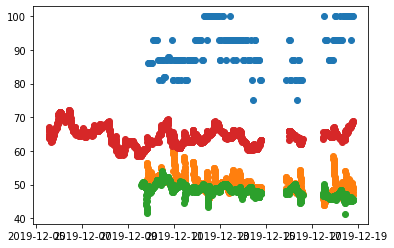

In [6]:
import collections

from apd.aggregation.query import with_database, get_data, get_deployment_ids

from matplotlib import pyplot as plt

async def plot(deployment_id):
    points = []
    async for dp in get_data(sensor_name="RelativeHumidity", deployment_id=deployment_id):
        points.append((dp.collected_at, dp.data))

    if points:
        x, y = zip(*points)
        plt.plot_date(x, y, "o", xdate=True)

with with_database("postgresql+psycopg2://apd@localhost/apd") as session:
    deployment_ids = await get_deployment_ids()
    for deployment in deployment_ids:
        await plot(deployment)
plt.show()

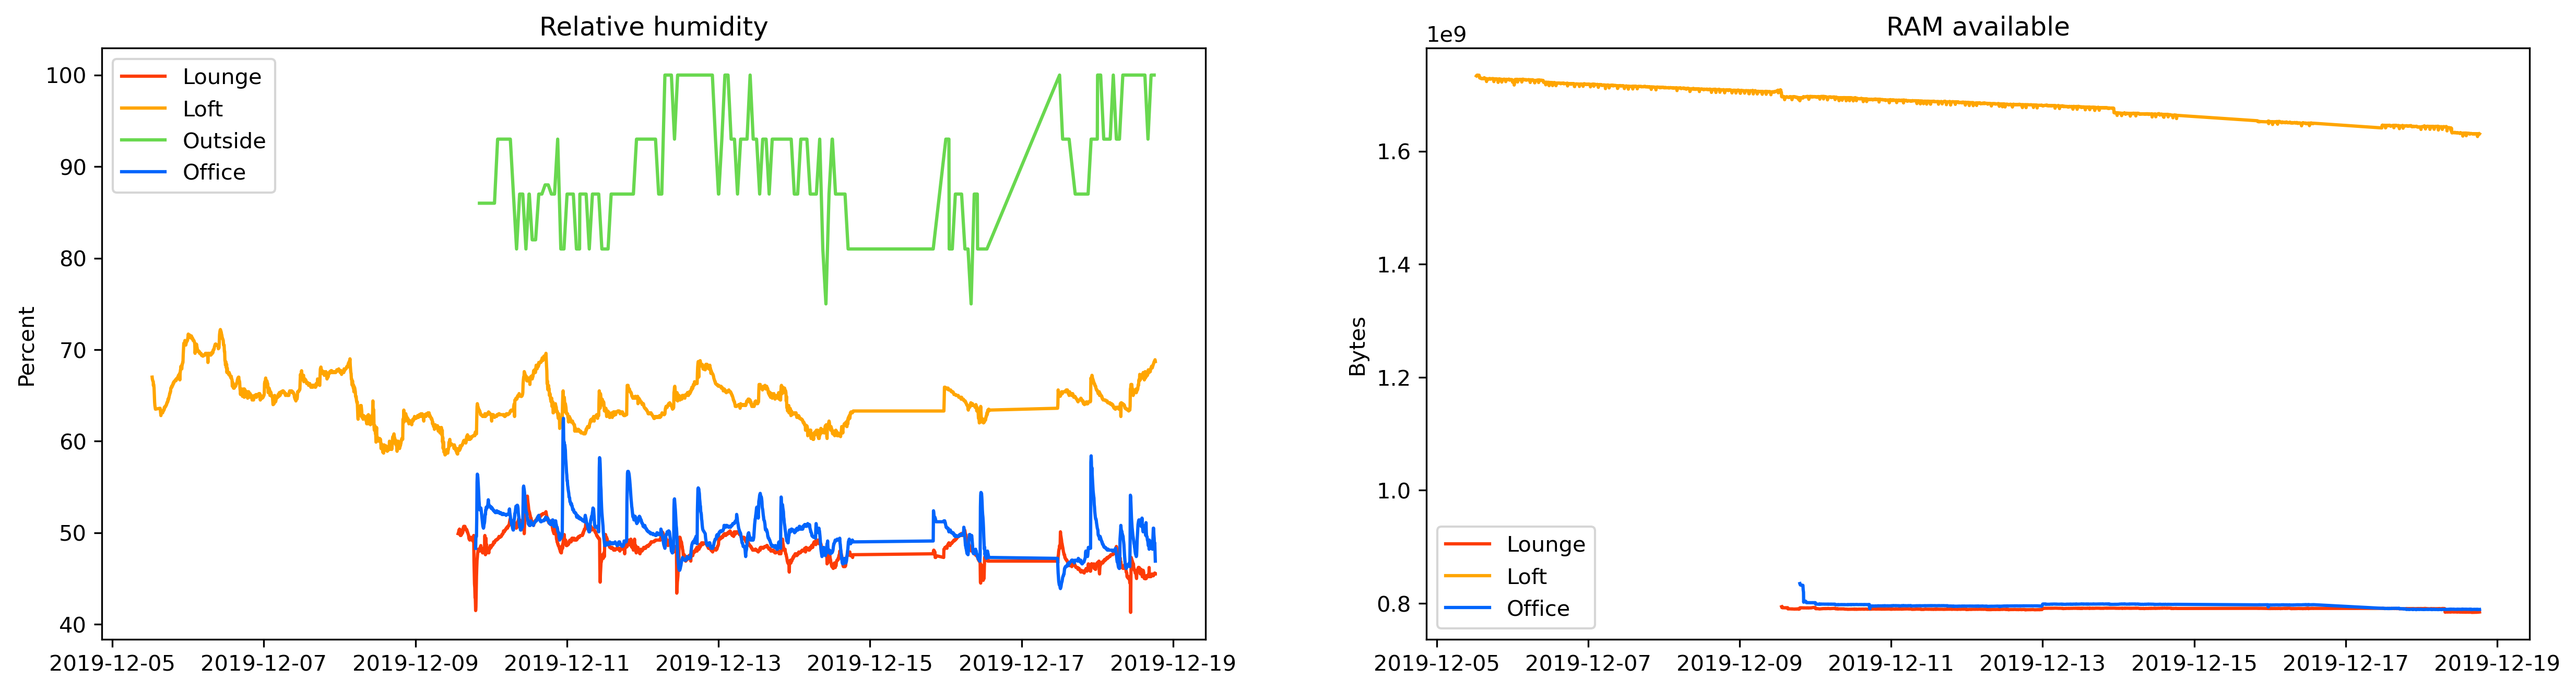

In [7]:
import asyncio

from matplotlib import pyplot as plt

from apd.aggregation.query import with_database
from apd.aggregation.analysis import get_known_configs, plot_sensor

with with_database("postgresql+psycopg2://apd@localhost/apd") as session:
    coros = []
    figure = plt.figure(figsize = (20, 5), dpi=300)
    configs = get_known_configs()
    to_display = configs["Relative humidity"], configs["RAM available"]
    for i, config in enumerate(to_display, start=1):
        plot = figure.add_subplot(1, 2, i)
        coros.append(plot_sensor(config, plot, {}))
    await asyncio.gather(*coros)

display(figure)

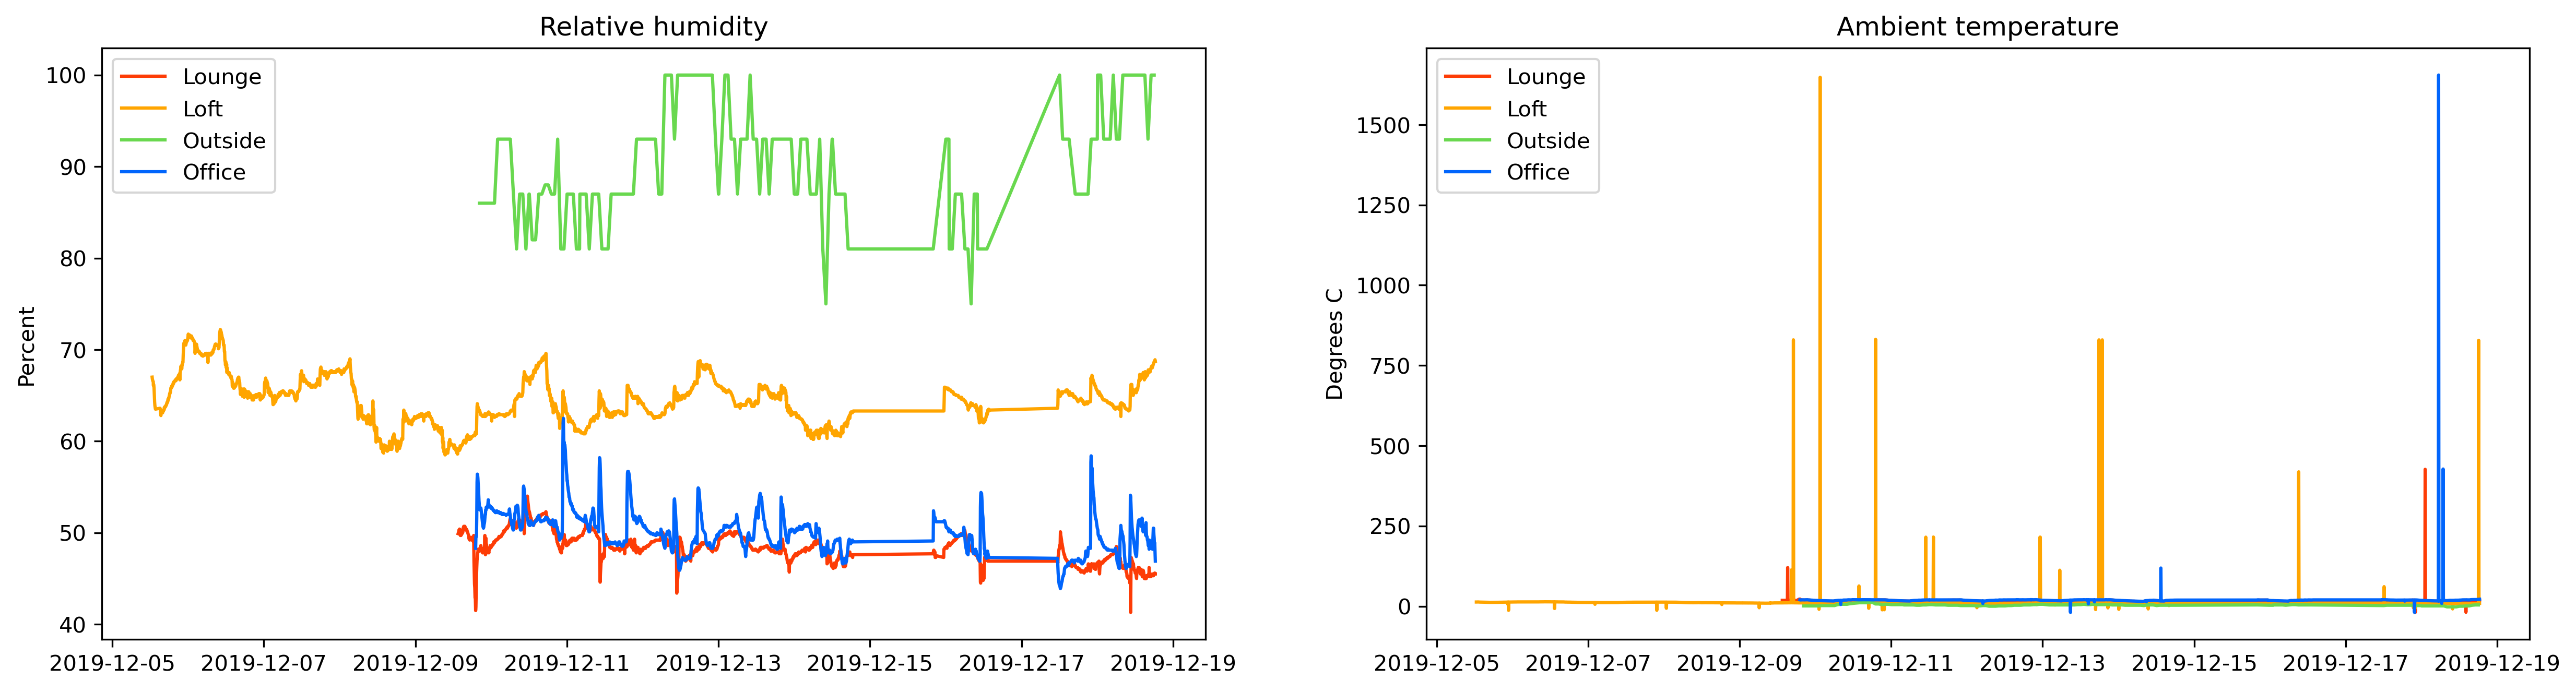

In [8]:
import asyncio

from matplotlib import pyplot as plt

from apd.aggregation.query import with_database
from apd.aggregation.analysis import get_known_configs, plot_sensor, Config

async def clean_magnitude(datapoints):
    async for datapoint in datapoints:
        if datapoint.data is None:
            continue
        yield datapoint.collected_at, datapoint.data["magnitude"]

TemperatureConfig = Config(
    sensor_name="Temperature",
    clean=clean_magnitude,
    title="Ambient temperature",
    ylabel="Degrees C",
)
        
with with_database("postgresql+psycopg2://apd@localhost/apd") as session:
    coros = []
    figure = plt.figure(figsize = (20, 5), dpi=300)
    configs = get_known_configs()
    to_display = configs["Relative humidity"], TemperatureConfig
    for i, config in enumerate(to_display, start=1):
        plot = figure.add_subplot(1, 2, i)
        coros.append(plot_sensor(config, plot, {}))
    await asyncio.gather(*coros)

display(figure)

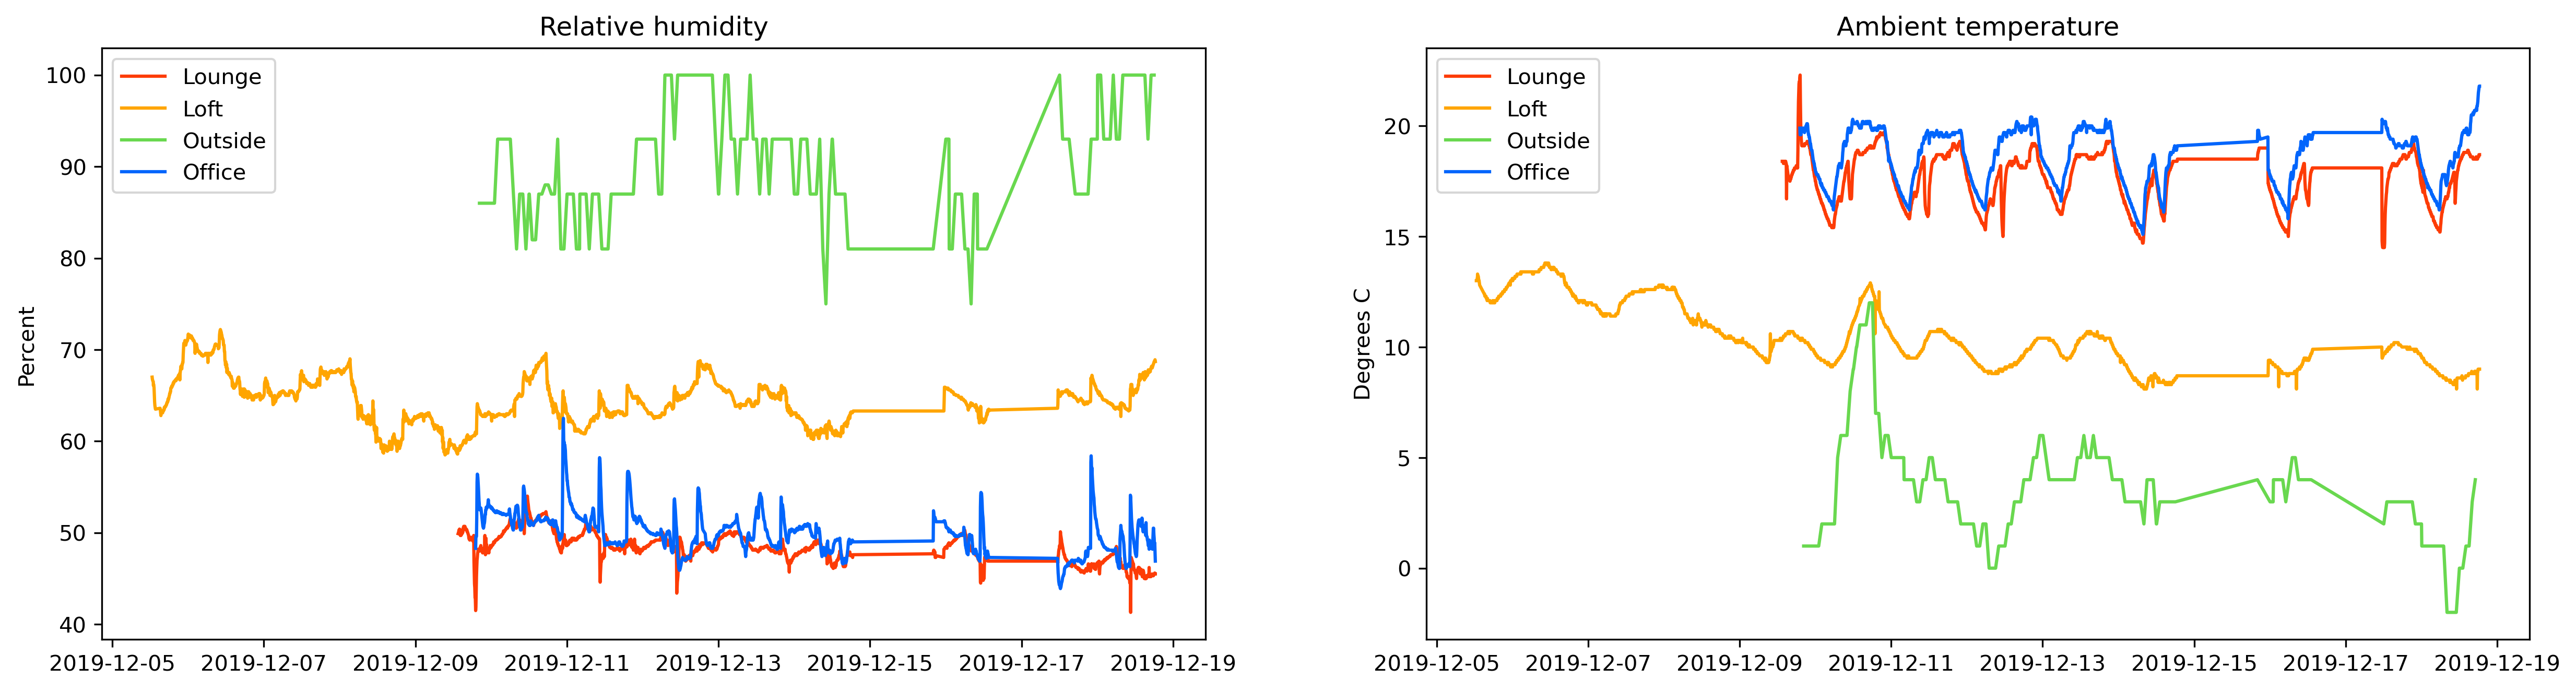

In [9]:
import asyncio

from matplotlib import pyplot as plt

from apd.aggregation.query import with_database
from apd.aggregation.analysis import get_known_configs, plot_sensor, Config

with with_database("postgresql+psycopg2://apd@localhost/apd") as session:
    coros = []
    figure = plt.figure(figsize = (20, 5), dpi=300)
    configs = get_known_configs()
    to_display = configs["Relative humidity"], configs["Ambient temperature"]
    for i, config in enumerate(to_display, start=1):
        plot = figure.add_subplot(1, 2, i)
        coros.append(plot_sensor(config, plot, {}))
    await asyncio.gather(*coros)

display(figure)

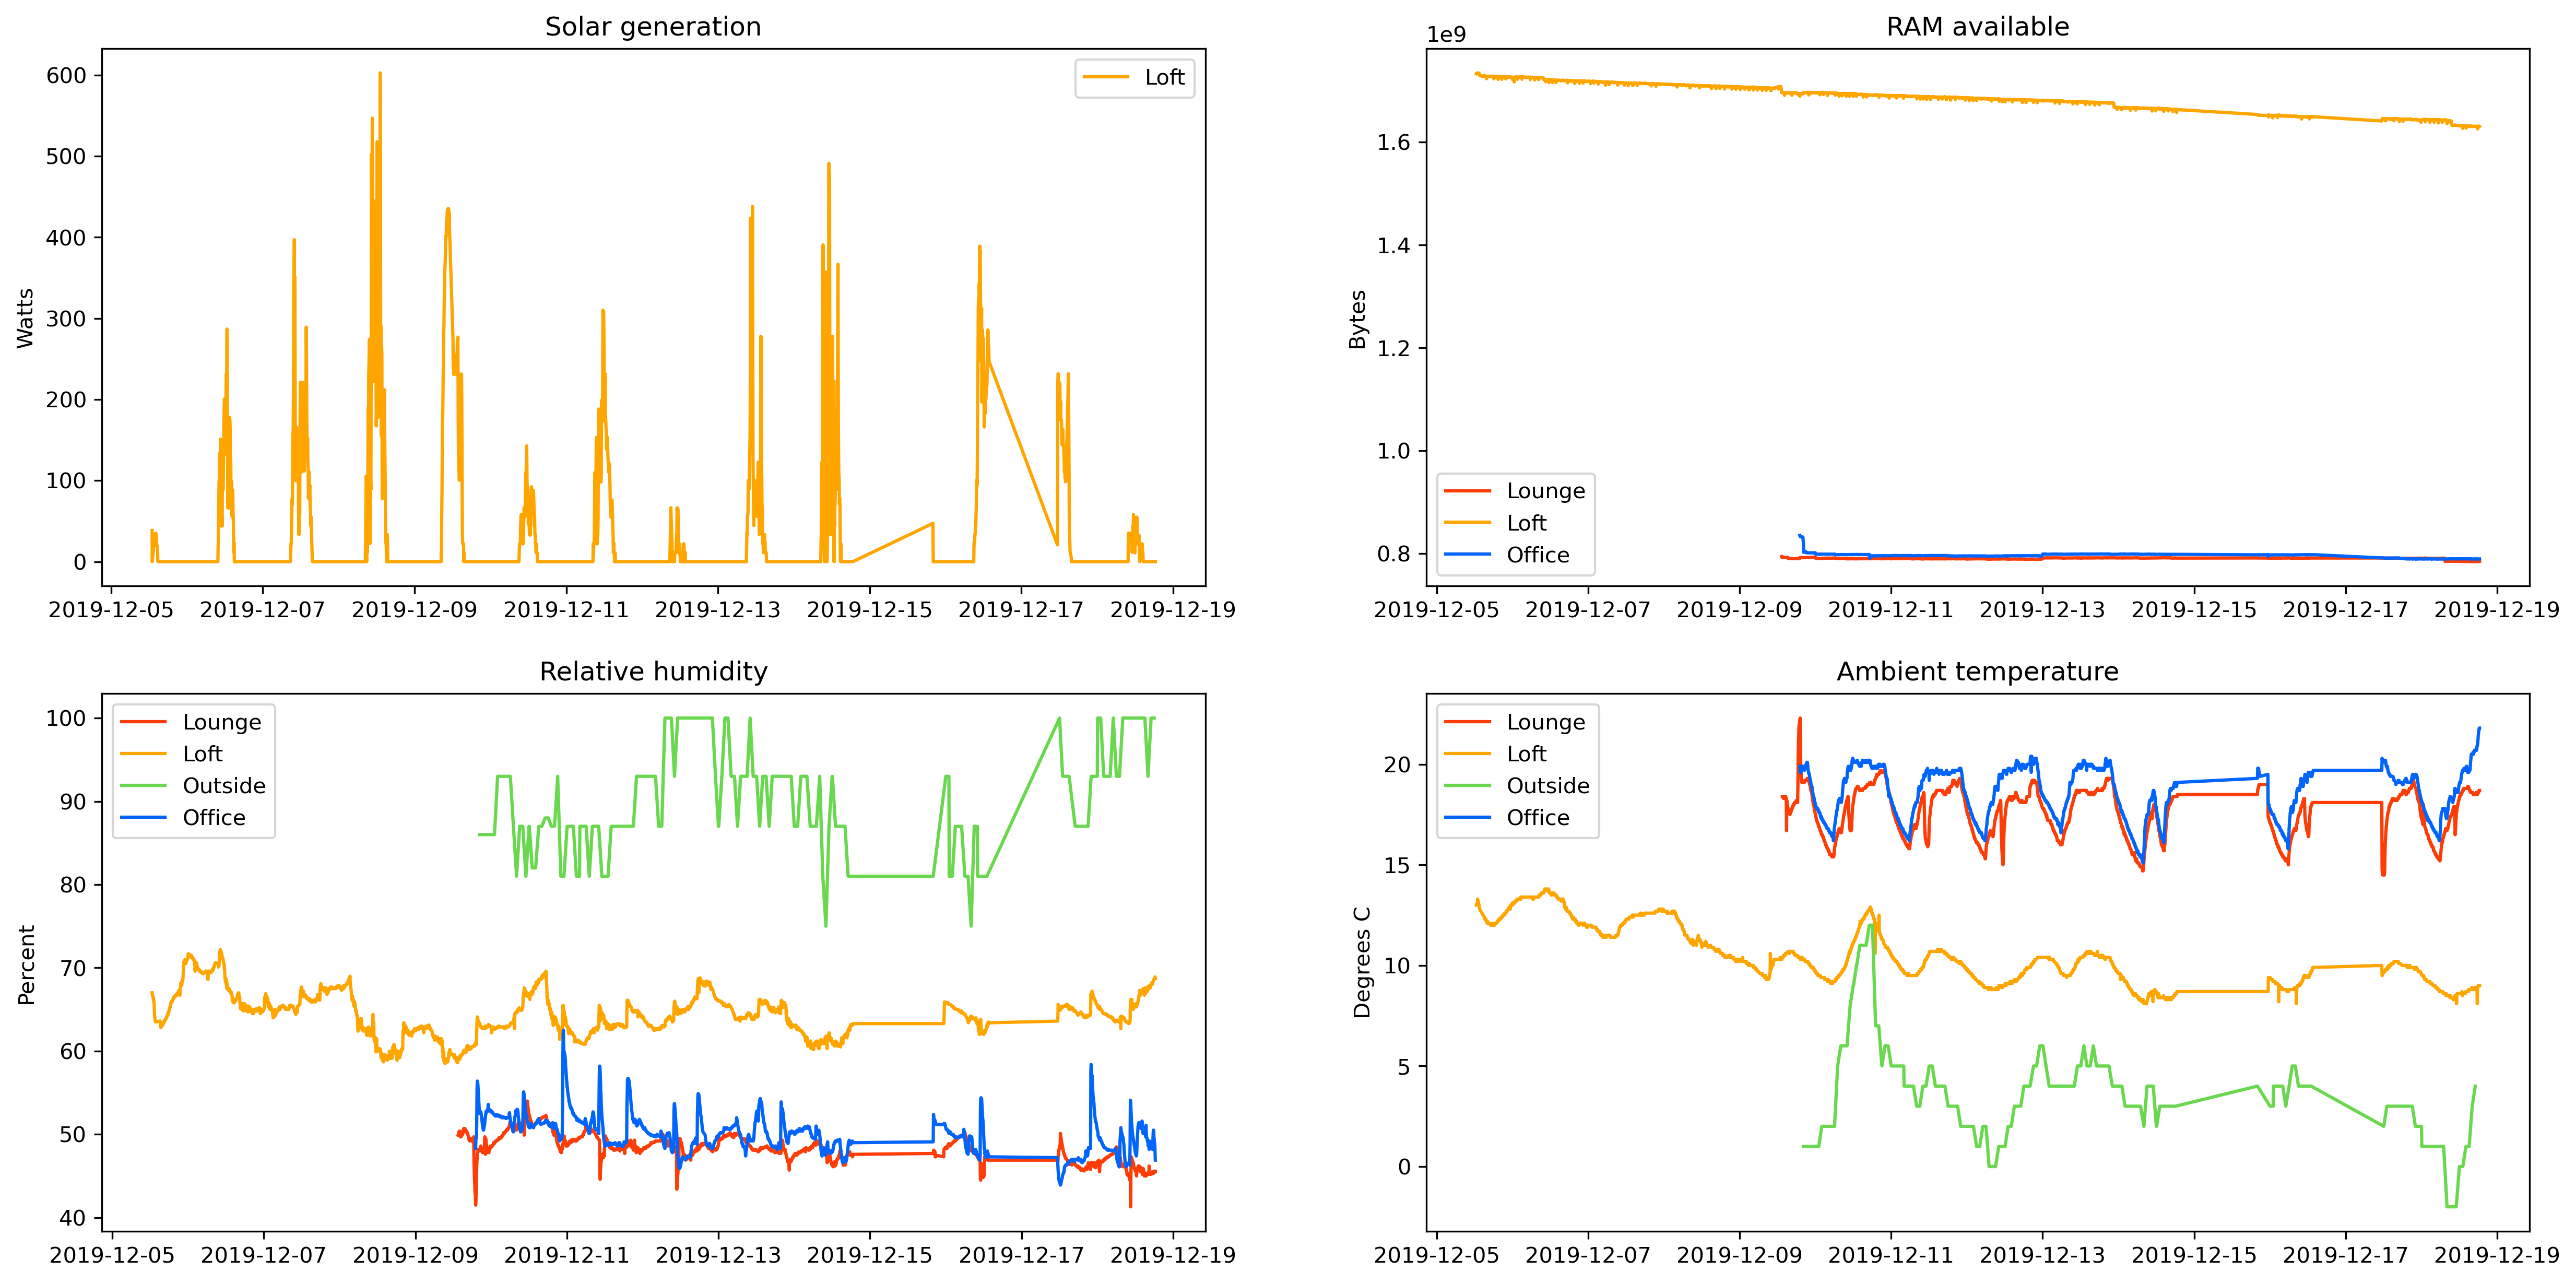

In [10]:
import asyncio
from uuid import UUID

from matplotlib import pyplot as plt

from apd.aggregation.query import with_database
from apd.aggregation.analysis import get_known_configs, plot_sensor


location_names = {
 UUID('53998a51-60de-48ae-b71a-5c37cd1455f2'): "Loft",
 UUID('1bc63cda-e223-48bc-93c2-c1f651779d69'): "Living Room",
 UUID('ea0683de-6772-4678-bfe7-6014f54ffc8e'): "Office",
 UUID('5aaa901a-7564-41fb-8eba-50cdd6fe9f80'): "Outside",
}

with with_database("postgresql+psycopg2://apd@localhost/apd") as session:
    coros = []
    figure = plt.figure(figsize = (20, 10), dpi=300)
    configs = get_known_configs().values()
    for i, config in enumerate(configs, start=1):
        plot = figure.add_subplot(2, 2, i)
        coros.append(plot_sensor(config, plot, location_names))
    await asyncio.gather(*coros)

display(figure)

In [14]:
import asyncio
from uuid import UUID
import functools
from concurrent.futures import ThreadPoolExecutor

import ipywidgets as widgets
from matplotlib import pyplot as plt

from apd.aggregation.query import with_database
from apd.aggregation.analysis import get_known_configs, plot_sensor


def wrap_coroutine(f):
    @functools.wraps(f)
    def run_in_thread(*args, **kwargs):
        loop  = asyncio.new_event_loop()
        wrapped = f(*args, **kwargs)
        with ThreadPoolExecutor(max_workers=1) as pool:
            task = pool.submit(loop.run_until_complete, wrapped)
        return task.result()
    return run_in_thread

@wrap_coroutine
async def plot(*args, **kwargs):
    location_names = {
     UUID('53998a51-60de-48ae-b71a-5c37cd1455f2'): "Loft",
     UUID('1bc63cda-e223-48bc-93c2-c1f651779d69'): "Living Room",
     UUID('ea0683de-6772-4678-bfe7-6014f54ffc8e'): "Office",
     UUID('5aaa901a-7564-41fb-8eba-50cdd6fe9f80'): "Outside",
    }

    with with_database("postgresql+psycopg2://apd@localhost/apd") as session:
        coros = []
        figure = plt.figure(figsize = (20, 10), dpi=300)
        configs = get_known_configs().values()
        for i, config in enumerate(configs, start=1):
            plot = figure.add_subplot(2, 2, i)
            coros.append(plot_sensor(config, plot, location_names, *args, **kwargs))
        await asyncio.gather(*coros)
    return figure


start = widgets.DatePicker(
    description='Start date',
)
end = widgets.DatePicker(
    description='End date',
)
out = widgets.interactive(plot, collected_after=start, collected_before=end)
display(out)


interactive(children=(DatePicker(value=None, description='Start date'), DatePicker(value=None, description='En…

In [12]:
from uuid import UUID
import ipywidgets as widgets
from apd.aggregation.analysis import interactable_plot_multiple_charts, configs

location_names = {
 UUID('53998a51-60de-48ae-b71a-5c37cd1455f2'): "Loft",
 UUID('1bc63cda-e223-48bc-93c2-c1f651779d69'): "Living Room",
 UUID('ea0683de-6772-4678-bfe7-6014f54ffc8e'): "Office",
 UUID('5aaa901a-7564-41fb-8eba-50cdd6fe9f80'): "Outside",
}

start = widgets.DatePicker(
    description='Start date',
)
end = widgets.DatePicker(
    description='End date',
)

plot = interactable_plot_multiple_charts(location_names=location_names)
out = widgets.interactive(plot, collected_after=start, collected_before=end)
display(out)


interactive(children=(DatePicker(value=None, description='Start date'), DatePicker(value=None, description='En…

In [13]:
import datetime
import uuid
import ipywidgets as widgets
from apd.aggregation.analysis import Config, configs, interactable_plot_multiple_charts, draw_map, get_map_cleaner_for
from apd.aggregation.database import DataPoint
from apd.aggregation.utils import merc_x, merc_y

start = widgets.DatePicker(description='Start date')
end = widgets.DatePicker(description='End date')

def get_literal_data():
    # Get manually entered temperature data, as our particular deployment
    # does not contain data of this shape
    raw_data = {(53.8667, -1.3333): -1, (53.35, -2.2833): 1, (52.45, -1.7333): 3, (51.5, -0.1333): 6, (51.55, -2.5667): 5, (54.9667, -1.6167): -1, (55.9667, -3.2167): -1, (54.7667, -1.5833): 0, (53.7667, -0.3): 1, (53.7667, -3.0167): 0, (51.4833, -3.1833): 4, (53.2667, -3.5167): 2, (52.0833, -2.8): 2, (52.0167, -0.6): 2, (52.6667, 1.2667): 5, (50.4333, -4.9833): 9, (50.35, -4.1167): 10, (50.5167, -2.45): 9, (50.8333, -1.1667): 9, (56.45, -5.4333): 4, (57.5333, -4.05): -2, (54.5167, -3.6167): 3, (53.0833, 0.2667): 4, (51.35, 1.3333): 7, (50.8833, 0.3167): 8, (58.45, -3.1): 3, (50.1, -5.6667): 9, (58.2167, -6.3333): 4, (55.6833, -6.25): 7}
    now = datetime.datetime.now()
    async def points():
        for (coord, temp) in raw_data.items():
            deployment_id = uuid.uuid4()
            yield DataPoint(sensor_name="Location", deployment_id=deployment_id, collected_at=now, data=coord)
            yield DataPoint(sensor_name="Temperature", deployment_id=deployment_id, collected_at=now, data=temp)
    async def deployments(*args, **kwargs):
        yield None, points()
    return deployments

def draw_map_with_gb(plot, x, y, colour):
    # Draw the map and add an explicit coastline
    gb_boundary = [(-2.6653539699999556, 51.617254950000074), (-2.6937556629999335, 51.59617747600004), (-2.71312415299991, 51.58661530200004), (-2.760487433999913, 51.579779364000046), (-2.7980850899999155, 51.56350332200009), (-2.816395636999914, 51.555568752000056), (-2.8587133449999556, 51.546128648000035), (-2.943348761999914, 51.54254791900007), (-2.9562882149999155, 51.54572174700007), (-2.9641007149999155, 51.552801825000074), (-2.969471808999913, 51.559881903000075), (-2.9746801419999542, 51.56297435100004), (-2.984038865999935, 51.55853913000004), (-3.0102432929999168, 51.53803131700005), (-3.0156957669999542, 51.53164297100005), (-3.0737198559999115, 51.50836823100008), (-3.0764867829999503, 51.50775788000004), (-3.088937954999949, 51.505072333000044), (-3.105620897999927, 51.49721914300005), (-3.1317032539999445, 51.48041413000004), (-3.1350805329999503, 51.47630442900004), (-3.1409399079999503, 51.46478913000004), (-3.1453751289999445, 51.45994700700004), (-3.1524145169999542, 51.45718008000006), (-3.1666560539999296, 51.45600006700005), (-3.1723933579999084, 51.45327383000006), (-3.1727188789999445, 51.453111070000034), (-3.160064256999931, 51.43183014500005), (-3.167144334999932, 51.41046784100007), (-3.1848038399999155, 51.39760976800005), (-3.204009568999936, 51.401597398000035), (-3.218861456999946, 51.402777411000045), (-3.289418097999942, 51.38422272300005), (-3.539173956999946, 51.398504950000074), (-3.557443813999953, 51.40509674700007), (-3.5753067699999406, 51.420436916000085), (-3.6047257149999155, 51.44570547100005), (-3.6631973949999406, 51.476223049000055), (-3.6769913399999155, 51.47703685100004), (-3.695423956999946, 51.47150299700007), (-3.717925584999932, 51.478583075000074), (-3.7376195949999556, 51.49087148600006), (-3.748036261999914, 51.50092194200005), (-3.7494197259999282, 51.50535716400009), (-3.747670050999943, 51.507025458000044), (-3.7445369129999335, 51.50763580900008), (-3.741851365999935, 51.50836823100008), (-3.7493383449999556, 51.52806224200003), (-3.7519018219999225, 51.53306712400007), (-3.758941209999932, 51.54677969000005), (-3.770130988999938, 51.56329987200007), (-3.782215949999909, 51.57664622600004), (-3.7902725899999155, 51.58197663000004), (-3.8077286449999406, 51.589178778000075), (-3.8169652989999463, 51.59650299700007), (-3.8326716789999296, 51.61554596600007), (-3.8416235019999476, 51.621527411000045), (-3.8548884759999282, 51.62384674700007), (-3.8867895169999542, 51.62140534100007), (-3.9623917309999115, 51.61562734600005), (-3.9766332669999542, 51.61188385600008), (-3.989979620999918, 51.60651276200008), (-3.998768683999913, 51.60028717700004), (-3.999908006999931, 51.59088776200008), (-3.9922582669999542, 51.58112213700008), (-3.9818009109999366, 51.571600653000075), (-3.974598761999914, 51.56297435100004), (-4.016184048999946, 51.56297435100004), (-4.016102667999917, 51.56037018400008), (-4.0208227199999556, 51.555853583000044), (-4.026519334999932, 51.554022528000075), (-4.029204881999931, 51.55927155200004), (-4.031971808999913, 51.56313711100006), (-4.0385636059999115, 51.56622955900008), (-4.046457485999952, 51.568426825000074), (-4.0531306629999335, 51.569240627000056), (-4.056304490999935, 51.56704336100006), (-4.065581834999932, 51.55756256700005), (-4.070220506999931, 51.555568752000056), (-4.0768123039999296, 51.55695221600007), (-4.087269660999937, 51.56191640800006), (-4.112131313999953, 51.565619208000044), (-4.121652798999946, 51.56598541900007), (-4.132191535999937, 51.56297435100004), (-4.142730272999927, 51.55695221600007), (-4.156809048999946, 51.54629140800006), (-4.1664119129999335, 51.54254791900007), (-4.176503058999913, 51.544256903000075), (-4.18773352799991, 51.54877350500004), (-4.1967667309999115, 51.54938385600008), (-4.200550910999937, 51.538763739000046), (-4.213368292999917, 51.539129950000074), (-4.272450324999909, 51.554754950000074), (-4.2899063789999445, 51.555568752000056), (-4.293324347999942, 51.55914948100008), (-4.29515540299991, 51.56195709800005), (-4.297352667999917, 51.569240627000056), (-4.278309699999909, 51.578192450000074), (-4.280832485999952, 51.58881256700005), (-4.2897029289999296, 51.601548570000034), (-4.2899063789999445, 51.61701080900008), (-4.255767381999931, 51.62384674700007), (-4.252023891999954, 51.62710195500006), (-4.241281704999949, 51.63934967700004), (-4.234730597999942, 51.644964911000045), (-4.228505011999914, 51.63743724200003), (-4.234730597999942, 51.63743724200003), (-4.234730597999942, 51.631293036000045), (-4.2278539699999556, 51.628119208000044), (-4.22101803299995, 51.62384674700007), (-4.1900935539999296, 51.63027578300006), (-4.139027472999942, 51.63231028900009), (-4.0912979809999115, 51.639878648000035), (-4.070220506999931, 51.66229889500005), (-4.0698136059999115, 51.66893138200004), (-4.070383266999954, 51.67430247600004), (-4.07054602799991, 51.67597077000005), (-4.0754288399999155, 51.677801825000074), (-4.087269660999937, 51.668850002000056), (-4.095448370999918, 51.66510651200008), (-4.106841600999928, 51.66425202000005), (-4.146351691999939, 51.66705963700008), (-4.200550910999937, 51.68585846600007), (-4.214955206999946, 51.679673570000034), (-4.293690558999913, 51.67226797100005), (-4.3152970039999445, 51.67747630400004), (-4.342355923999946, 51.69086334800005), (-4.3664444649999155, 51.70848216400009), (-4.379261847999942, 51.72687409100007), (-4.338042772999927, 51.72333405200004), (-4.319976365999935, 51.72483958500004), (-4.310454881999931, 51.733710028000075), (-4.328724738999938, 51.73297760600008), (-4.3471573559999115, 51.73578522300005), (-4.3625382149999155, 51.74286530200004), (-4.371815558999913, 51.754787502000056), (-4.368763800999943, 51.75698476800005), (-4.362904425999943, 51.76386139500005), (-4.358021613999938, 51.773138739000046), (-4.358225063999953, 51.782131252000056), (-4.365101691999939, 51.789048570000034), (-4.3714900379999335, 51.78595612200007), (-4.379261847999942, 51.77529531500005), (-4.384917772999927, 51.77187734600005), (-4.3929744129999335, 51.763739325000074), (-4.399159308999913, 51.76162344000005), (-4.409331834999932, 51.76316966400009), (-4.417876756999931, 51.76788971600007), (-4.426503058999913, 51.77529531500005), (-4.445790167999917, 51.77326080900008), (-4.449330206999946, 51.76630280200004), (-4.441395636999914, 51.75678131700005), (-4.426503058999913, 51.747300523000035), (-4.460764126999948, 51.73578522300005), (-4.4988907539999445, 51.73484935100004), (-4.574208136999914, 51.74115631700005), (-4.603423631999931, 51.73924388200004), (-4.639230923999946, 51.73318105700008), (-4.6453751289999445, 51.732123114000046), (-4.678212042999917, 51.71743398600006), (-4.680287238999938, 51.692694403000075), (-4.689442511999914, 51.69159577000005), (-4.69163977799991, 51.689886786000045), (-4.69163977799991, 51.685980536000045), (-4.693959113999938, 51.67841217700004), (-4.712310350999928, 51.650091864000046), (-4.721424933999913, 51.652044989000046), (-4.734934048999946, 51.65924713700008), (-4.741851365999935, 51.65607330900008), (-4.759185350999928, 51.644964911000045), (-4.8482966789999296, 51.64630768400008), (-4.86351477799991, 51.64411041900007), (-4.878977016999954, 51.63743724200003), (-4.887806769999941, 51.62995026200008), (-4.8957413399999155, 51.621079820000034), (-4.904774542999917, 51.61383698100008), (-4.923695441999939, 51.608628648000035), (-4.931996222999942, 51.59902578300006), (-4.941029425999943, 51.59650299700007), (-4.946034308999913, 51.59760163000004), (-4.956450975999928, 51.602769273000035), (-5.021595831999946, 51.61603424700007), (-5.0457657539999445, 51.62689850500004), (-5.0366104809999115, 51.63743724200003), (-5.0511775379999335, 51.65692780200004), (-5.100493943999936, 51.66469961100006), (-5.119740363999938, 51.67841217700004), (-5.113433397999927, 51.68528880400004), (-5.0366104809999115, 51.67841217700004), (-5.038726365999935, 51.68183014500005), (-5.04133053299995, 51.68939850500004), (-5.043446417999917, 51.692694403000075), (-5.028675910999937, 51.69293854400007), (-5.002552863999938, 51.68740469000005), (-4.988189256999931, 51.68585846600007), (-4.974598761999914, 51.687933661000045), (-4.941029425999943, 51.70014069200005), (-4.892648891999954, 51.706366278000075), (-4.868275519999941, 51.716782945000034), (-4.8580623039999296, 51.71832916900007), (-4.844838019999941, 51.71381256700005), (-4.844838019999941, 51.720038153000075), (-4.873402472999942, 51.73773834800005), (-4.879017706999946, 51.76203034100007), (-4.8625382149999155, 51.78237539300005), (-4.824330206999946, 51.788275458000044), (-4.824330206999946, 51.79572174700007), (-4.836008266999954, 51.790716864000046), (-4.864979620999918, 51.783270575000074), (-4.921294725999928, 51.78001536700003), (-4.933583136999914, 51.77529531500005), (-4.9172257149999155, 51.77533600500004), (-4.905181443999936, 51.771185614000046), (-4.900542772999927, 51.76211172100005), (-4.906239386999914, 51.747300523000035), (-4.8920792309999115, 51.73940664300005), (-4.895659959999932, 51.728176174000055), (-4.9105525379999335, 51.71820709800005), (-4.988189256999931, 51.70685455900008), (-5.009917772999927, 51.706366278000075), (-5.149240688999953, 51.718085028000075), (-5.166900193999936, 51.71381256700005), (-5.156971808999913, 51.69757721600007), (-5.1686091789999296, 51.68891022300005), (-5.1828507149999155, 51.68927643400008), (-5.180653449999909, 51.70014069200005), (-5.180653449999909, 51.706366278000075), (-5.230132615999935, 51.73004791900007), (-5.2495011059999115, 51.733710028000075), (-5.228138800999943, 51.73395416900007), (-5.213937954999949, 51.73574453300006), (-5.202870245999918, 51.74079010600008), (-5.191151495999918, 51.75104401200008), (-5.176828579999949, 51.75967031500005), (-5.1432185539999296, 51.76386139500005), (-5.125965949999909, 51.76850006700005), (-5.110259568999936, 51.778509833000044), (-5.107085740999935, 51.78807200700004), (-5.112294074999909, 51.81317780200004), (-5.113392706999946, 51.82880280200004), (-5.11750240799995, 51.84369538000004), (-5.125884568999936, 51.85602448100008), (-5.139637824999909, 51.86399974200003), (-5.146473761999914, 51.85716380400004), (-5.16437740799995, 51.86676666900007), (-5.2037654289999296, 51.87018463700008), (-5.221587693999936, 51.87767161700003), (-5.2358292309999115, 51.87103913000004), (-5.2914119129999335, 51.86399974200003), (-5.3109431629999335, 51.86399974200003), (-5.304269985999952, 51.867621161000045), (-5.297352667999917, 51.87018463700008), (-5.297352667999917, 51.87767161700003), (-5.300689256999931, 51.882025458000044), (-5.302561001999948, 51.88523997600004), (-5.300160285999937, 51.888332424000055), (-5.2905167309999115, 51.89199453300006), (-5.2905167309999115, 51.898138739000046), (-5.2983292309999115, 51.91095612200007), (-5.288929816999939, 51.91693756700005), (-5.252837693999936, 51.91864655200004), (-5.234201626999948, 51.923041083000044), (-5.204172329999949, 51.942287502000056), (-5.191151495999918, 51.946600653000075), (-5.16038977799991, 51.94944896000004), (-5.1195369129999335, 51.95892975500004), (-5.088042772999927, 51.97601959800005), (-5.085031704999949, 52.00185781500005), (-5.070790167999917, 52.00185781500005), (-5.070790167999917, 52.00804271000004), (-5.082753058999913, 52.01447174700007), (-5.081206834999932, 52.021185614000046), (-5.070220506999931, 52.02635325700004), (-5.053700324999909, 52.028509833000044), (-5.0266007149999155, 52.027411200000074), (-5.015044725999928, 52.02533600500004), (-4.961740688999953, 52.007513739000046), (-4.942534959999932, 52.007473049000055), (-4.913685675999943, 52.014837958000044), (-4.920521613999938, 52.028509833000044), (-4.9016007149999155, 52.02643463700008), (-4.863189256999931, 52.01699453300006), (-4.841420050999943, 52.014837958000044), (-4.83226477799991, 52.01898834800005), (-4.833851691999939, 52.02875397300005), (-4.8382869129999335, 52.04010651200008), (-4.838002081999946, 52.04901764500005), (-4.83039303299995, 52.05292389500005), (-4.796986456999946, 52.05646393400008), (-4.77757727799991, 52.064886786000045), (-4.7631729809999115, 52.075873114000046), (-4.7386775379999335, 52.100816148000035), (-4.720285610999952, 52.113348700000074), (-4.7065323559999115, 52.11347077000005), (-4.673451300999943, 52.09739817900004), (-4.675689256999931, 52.126939195000034), (-4.637521938999953, 52.13849518400008), (-4.513824022999927, 52.13568756700005), (-4.50226803299995, 52.138373114000046), (-4.495757615999935, 52.14350006700005), (-4.490956183999913, 52.150376695000034), (-4.484283006999931, 52.156317450000074), (-4.454701300999943, 52.16205475500004), (-4.4348038399999155, 52.170355536000045), (-4.415394660999937, 52.18154531500005), (-4.385568813999953, 52.20343659100007), (-4.371245897999927, 52.20929596600007), (-4.3547257149999155, 52.212103583000044), (-4.334339972999942, 52.21283600500004), (-4.315825975999928, 52.21629466400003), (-4.197132941999939, 52.279282945000034), (-4.1390681629999335, 52.33022695500006), (-4.10960852799991, 52.365301825000074), (-4.096262173999946, 52.387884833000044), (-4.0873917309999115, 52.430121161000045), (-4.0789688789999445, 52.45302969000005), (-4.067941860999952, 52.47361888200004), (-4.056548631999931, 52.48786041900007), (-4.0618383449999556, 52.49705638200004), (-4.064035610999952, 52.50918203300006), (-4.062570766999954, 52.52098216400003), (-4.056548631999931, 52.52944570500006), (-4.048491990999935, 52.530462958000044), (-4.0266007149999155, 52.52338288000004), (-4.016184048999946, 52.52195872600004), (-3.998768683999913, 52.52594635600008), (-3.9473363919999542, 52.549261786000045), (-3.9473363919999542, 52.556708075000074), (-3.9744766919999392, 52.55654531500005), (-4.025868292999917, 52.545355536000045), (-4.0531306629999335, 52.54242584800005), (-4.068470831999946, 52.550116278000075), (-4.1141251289999445, 52.58860911700003), (-4.125477667999917, 52.60390859600005), (-4.122222459999932, 52.62872955900008), (-4.105946417999917, 52.653509833000044), (-4.0848282539999445, 52.67267487200007), (-4.067128058999913, 52.68024323100008), (-4.063547329999949, 52.68309153900003), (-4.05882727799991, 52.696600653000075), (-4.056548631999931, 52.70066966400003), (-4.052723761999914, 52.70221588700008), (-4.041981574999909, 52.70465729400007), (-4.001088019999941, 52.72410716400003), (-3.988270636999914, 52.73427969000005), (-4.014719204999949, 52.73232656500005), (-4.031971808999913, 52.723944403000075), (-4.048817511999914, 52.721584377000056), (-4.125152147999927, 52.77830638200004), (-4.144357876999948, 52.802801825000074), (-4.149037238999938, 52.81207916900007), (-4.146229620999918, 52.82021719000005), (-4.128895636999914, 52.82363515800006), (-4.117339647999927, 52.83075592700004), (-4.1197810539999296, 52.84625885600008), (-4.127756313999953, 52.86172109600005), (-4.132191535999937, 52.86831289300005), (-4.131988084999932, 52.882473049000055), (-4.129872199999909, 52.88922760600008), (-4.123605923999946, 52.89325592700004), (-4.064035610999952, 52.919175523000035), (-4.071400519999941, 52.921087958000044), (-4.074574347999942, 52.92279694200005), (-4.0776261059999115, 52.926662502000056), (-4.0891007149999155, 52.918850002000056), (-4.100493943999936, 52.914129950000074), (-4.1105850899999155, 52.915676174000055), (-4.118560350999928, 52.926662502000056), (-4.144398566999939, 52.91478099200003), (-4.171620245999918, 52.91347890800006), (-4.228505011999914, 52.919175523000035), (-4.300689256999931, 52.905585028000075), (-4.317290818999936, 52.89935944200005), (-4.337310350999928, 52.89203522300005), (-4.406605597999942, 52.89252350500004), (-4.4272354809999115, 52.885972398000035), (-4.446197068999936, 52.87592194200005), (-4.4816788399999155, 52.850897528000075), (-4.477935350999928, 52.84833405200004), (-4.475493943999936, 52.84414297100005), (-4.491363084999932, 52.83820221600007), (-4.500965949999909, 52.82680898600006), (-4.501332160999937, 52.81391022300005), (-4.4891251289999445, 52.803168036000045), (-4.501942511999914, 52.794989325000074), (-4.509185350999928, 52.791449286000045), (-4.5164688789999445, 52.789496161000045), (-4.5285538399999155, 52.79047272300005), (-4.5424698559999115, 52.80068594000005), (-4.5639542309999115, 52.80524323100008), (-4.583078579999949, 52.81464264500005), (-4.594634568999936, 52.81679922100005), (-4.606516079999949, 52.81509023600006), (-4.61351477799991, 52.81110260600008), (-4.619211391999954, 52.80654531500005), (-4.626332160999937, 52.803168036000045), (-4.648589647999927, 52.79962799700007), (-4.704497850999928, 52.803168036000045), (-4.719309048999946, 52.79751211100006), (-4.733225063999953, 52.78750234600005), (-4.747425910999937, 52.78343333500004), (-4.762847459999932, 52.789496161000045), (-4.752512173999946, 52.79877350500004), (-4.7514542309999115, 52.80320872600004), (-4.755441860999952, 52.80931224200003), (-4.7492569649999155, 52.81427643400008), (-4.734934048999946, 52.83047109600005), (-4.596058722999942, 52.92841217700004), (-4.580962693999936, 52.93349844000005), (-4.562082485999952, 52.93451569200005), (-4.543527798999946, 52.937933661000045), (-4.523996548999946, 52.944240627000056), (-4.443430141999954, 52.98216380400004), (-4.423695441999939, 53.00263092700004), (-4.358225063999953, 53.02846914300005), (-4.349964972999942, 53.04148997600004), (-4.345692511999914, 53.059475002000056), (-4.343861456999946, 53.10106028900003), (-4.340891079999949, 53.11273834800005), (-4.334339972999942, 53.11676666900007), (-4.3276261059999115, 53.11469147300005), (-4.324696417999917, 53.10789622600004), (-4.320668097999942, 53.10150788000004), (-4.312245245999918, 53.109442450000074), (-4.304758266999954, 53.12099844000005), (-4.303618943999936, 53.12531159100007), (-4.263539191999939, 53.15452708500004), (-4.2523494129999335, 53.159409898000035), (-4.234527147999927, 53.16400788000004), (-4.221302863999938, 53.175034898000035), (-4.200550910999937, 53.20099518400008), (-4.17796790299991, 53.21759674700007), (-4.151519334999932, 53.22809479400007), (-4.122222459999932, 53.23346588700008), (-4.0906876289999445, 53.23517487200007), (-4.08234615799995, 53.23354726800005), (-4.074330206999946, 53.23065827000005), (-4.066883917999917, 53.22907135600008), (-4.054107225999928, 53.234361070000034), (-4.032297329999949, 53.24070872600004), (-4.008900519999941, 53.24445221600007), (-3.974598761999914, 53.261786200000074), (-3.8653051419999542, 53.289129950000074), (-3.8312882149999155, 53.289129950000074), (-3.841420050999943, 53.30744049700007), (-3.870757615999935, 53.32562897300005), (-3.8784073559999115, 53.337591864000046), (-3.859974738999938, 53.33633047100005), (-3.840565558999913, 53.33283112200007), (-3.822987433999913, 53.32656484600005), (-3.8101293609999516, 53.31708405200004), (-3.7905167309999115, 53.323431708000044), (-3.7688695949999556, 53.31915924700007), (-3.748199022999927, 53.307806708000044), (-3.7319229809999115, 53.29287344000005), (-3.7162979809999115, 53.28693268400008), (-3.6022029289999296, 53.28888580900008), (-3.5623266269999476, 53.29441966400003), (-3.372059699999909, 53.350897528000075), (-3.33031165299991, 53.35179271000004), (-3.2923884759999282, 53.34052155200004), (-3.2713110019999476, 53.33055247600004), (-3.262074347999942, 53.32050202000005), (-3.250803188999953, 53.312567450000074), (-3.122222459999932, 53.26227448100008), (-3.107533331999946, 53.25189850500004), (-3.0951228509999282, 53.23932526200008), (-3.0877579419999392, 53.23468659100007), (-3.0845434239999463, 53.23859284100007), (-3.0845434239999463, 53.25857168200008), (-3.0845434239999463, 53.275458075000074), (-3.09593665299991, 53.28713613500008), (-3.1111954419999392, 53.302801825000074), (-3.1354060539999296, 53.33380768400008), (-3.171538865999935, 53.36225006700005), (-3.185210740999935, 53.37726471600007), (-3.186350063999953, 53.39276764500005), (-3.175526495999918, 53.40273672100005), (-3.157297329999949, 53.40875885600008), (-3.1146541009999282, 53.41266510600008), (-3.0942276679999168, 53.41738515800006), (-3.058257615999935, 53.434759833000044), (-3.0355525379999335, 53.43374258000006), (-3.0121964179999168, 53.41669342700004), (-2.9529516269999476, 53.323919989000046), (-2.9351293609999516, 53.309475002000056), (-2.9105525379999335, 53.29633209800005), (-2.8814998039999296, 53.288397528000075), (-2.850575324999909, 53.289129950000074), (-2.849598761999914, 53.29120514500005), (-2.848378058999913, 53.29555898600006), (-2.8449600899999155, 53.300116278000075), (-2.837554490999935, 53.302801825000074), (-2.8286026679999168, 53.302435614000046), (-2.813384568999936, 53.297756252000056), (-2.8061417309999115, 53.296576239000046), (-2.789784308999913, 53.29743073100008), (-2.775502081999946, 53.29987213700008), (-2.7481176419999542, 53.30963776200008), (-2.753651495999918, 53.32245514500005), (-2.750884568999936, 53.33161041900007), (-2.743153449999909, 53.33852773600006), (-2.734486456999946, 53.34442780200004), (-2.7261449859999516, 53.34198639500005), (-2.7174373039999296, 53.34271881700005), (-2.708607550999943, 53.346136786000045), (-2.6997777989999463, 53.35179271000004), (-2.7141007149999155, 53.35236237200007), (-2.764393683999913, 53.34516022300005), (-2.775380011999914, 53.341009833000044), (-2.782378709999932, 53.32636139500005), (-2.799794074999909, 53.32103099200003), (-2.810332811999956, 53.32172272300005), (-2.843658006999931, 53.323919989000046), (-2.886463995999918, 53.33356354400007), (-2.924956834999932, 53.35000234600005), (-2.956939256999931, 53.37055084800005), (-2.980824347999942, 53.39276764500005), (-3.096587693999936, 53.54433828300006), (-3.101918097999942, 53.55805084800005), (-3.0994766919999392, 53.57200755400004), (-3.087635870999918, 53.58771393400008), (-3.021839972999942, 53.65281810100004), (-2.968658006999931, 53.69403717700004), (-2.9603572259999282, 53.69757721600007), (-2.9517309239999463, 53.70807526200008), (-2.9114477199999556, 53.725043036000045), (-2.899037238999938, 53.73541901200008), (-2.9848526679999168, 53.73607005400004), (-3.021473761999914, 53.745794989000046), (-3.049183722999942, 53.769517320000034), (-3.056385870999918, 53.80304596600007), (-3.044911261999914, 53.87848541900007), (-3.056630011999914, 53.90615469000005), (-3.040679490999935, 53.923529364000046), (-3.017567511999914, 53.93195221600007), (-2.925689256999931, 53.95270416900007), (-2.909250454999949, 53.95384349200003), (-2.896107550999943, 53.94773997600004), (-2.8885391919999392, 53.94603099200003), (-2.885365363999938, 53.950506903000075), (-2.881988084999932, 53.95652903900003), (-2.874175584999932, 53.96165599200003), (-2.865142381999931, 53.96548086100006), (-2.8579809239999463, 53.96759674700007), (-2.869252081999946, 53.97882721600007), (-2.8344620429999168, 53.99982330900008), (-2.830067511999914, 54.01601797100005), (-2.8475235669999392, 54.00836823100008), (-2.864857550999943, 54.00429922100005), (-2.895497199999909, 54.00234609600005), (-2.900298631999931, 54.00495026200008), (-2.9160863919999542, 54.026556708000044), (-2.91820227799991, 54.03432851800005), (-2.911284959999932, 54.03998444200005), (-2.9007869129999335, 54.044907945000034), (-2.8920792309999115, 54.050116278000075), (-2.872670050999943, 54.071600653000075), (-2.8588761059999115, 54.08100006700005), (-2.826771613999938, 54.08881256700005), (-2.815174933999913, 54.09878164300005), (-2.795969204999949, 54.12518952000005), (-2.8128149079999503, 54.139878648000035), (-2.8364151679999168, 54.16758860900006), (-2.8509415359999366, 54.18463776200008), (-2.854237433999913, 54.19407786700003), (-2.8328751289999445, 54.19904205900008), (-2.810292120999918, 54.21190013200004), (-2.7952367829999503, 54.22947825700004), (-2.795969204999949, 54.24872467700004), (-2.8028051419999542, 54.24872467700004), (-2.806630011999914, 54.233710028000075), (-2.8208715489999463, 54.22174713700008), (-2.850575324999909, 54.20774974200003), (-2.886382615999935, 54.19627513200004), (-2.904652472999942, 54.18764883000006), (-2.9126684239999463, 54.176988023000035), (-2.9203995429999168, 54.16205475500004), (-2.939198370999918, 54.15509674700007), (-2.9842016269999476, 54.15314362200007), (-2.997710740999935, 54.15957265800006), (-3.011341925999943, 54.17413971600007), (-3.017323370999918, 54.19009023600006), (-3.008168097999942, 54.20034414300005), (-3.015370245999918, 54.21190013200004), (-3.024484829999949, 54.221584377000056), (-3.035755988999938, 54.22597890800006), (-3.049183722999942, 54.22207265800006), (-3.044667120999918, 54.208319403000075), (-3.047840949999909, 54.19432200700004), (-3.053537563999953, 54.181301174000055), (-3.056630011999914, 54.17023346600007), (-3.0610245429999168, 54.16193268400008), (-3.090728318999936, 54.13947174700007), (-3.10765540299991, 54.11855703300006), (-3.117909308999913, 54.10883209800005), (-3.145253058999913, 54.100043036000045), (-3.147450324999909, 54.08869049700007), (-3.1443985669999392, 54.07514069200005), (-3.1453751289999445, 54.063788153000075), (-3.1805313789999445, 54.09284088700008), (-3.1897680329999503, 54.09788646000004), (-3.2057185539999296, 54.098537502000056), (-3.219553188999953, 54.100775458000044), (-3.2311091789999296, 54.105129299000055), (-3.240956183999913, 54.11212799700007), (-3.2381078769999476, 54.12759023600006), (-3.232533331999946, 54.14468008000006), (-3.233143683999913, 54.15916575700004), (-3.248402472999942, 54.16681549700007), (-3.248402472999942, 54.17365143400008), (-3.215199347999942, 54.17983633000006), (-3.206776495999918, 54.20892975500004), (-3.2090551419999542, 54.24274323100008), (-3.207386847999942, 54.263006903000075), (-3.2231339179999168, 54.25763580900008), (-3.231353318999936, 54.24721914300005), (-3.240956183999913, 54.22207265800006), (-3.232167120999918, 54.20254140800006), (-3.247141079999949, 54.19794342700004), (-3.270130988999938, 54.19912344000005), (-3.2860001289999445, 54.19721100500004), (-3.306792772999927, 54.19188060100004), (-3.3285212879999335, 54.204738674000055), (-3.3644913399999155, 54.24249909100007), (-3.394195115999935, 54.26439036700003), (-3.407378709999932, 54.27773672100005), (-3.412912563999953, 54.29376862200007), (-3.41038977799991, 54.30145905200004), (-3.405995245999918, 54.30963776200008), (-3.4041235019999476, 54.31854889500005), (-3.4114477199999556, 54.33274974200003), (-3.4134415359999366, 54.342962958000044), (-3.4163305329999503, 54.344916083000044), (-3.440174933999913, 54.35175202000005), (-3.474273240999935, 54.39350006700005), (-3.497710740999935, 54.40582916900007), (-3.5918676419999542, 54.48309967700004), (-3.608143683999913, 54.488267320000034), (-3.613189256999931, 54.49164459800005), (-3.6236873039999296, 54.50608958500004), (-3.6341853509999282, 54.512884833000044), (-3.6268204419999392, 54.520412502000056), (-3.616200324999909, 54.52757396000004), (-3.61156165299991, 54.52993398600006), (-3.5903214179999168, 54.56464264500005), (-3.5638321609999366, 54.64276764500005), (-3.5301407539999445, 54.68805573100008), (-3.5160212879999335, 54.712876695000034), (-3.5091853509999282, 54.72166575700004), (-3.500721808999913, 54.72597890800006), (-3.478871222999942, 54.730902411000045), (-3.4681290359999366, 54.73529694200005), (-3.455433722999942, 54.745021877000056), (-3.439564581999946, 54.76146067900004), (-3.4309789699999556, 54.780462958000044), (-3.440174933999913, 54.79743073100008), (-3.4075414699999556, 54.85602448100008), (-3.3879288399999155, 54.88336823100008), (-3.3644913399999155, 54.89980703300006), (-3.3449600899999155, 54.90253327000005), (-3.3333634109999366, 54.89728424700007), (-3.3227432929999168, 54.889878648000035), (-3.3064672519999476, 54.88617584800005), (-3.295725063999953, 54.88690827000005), (-3.254628058999913, 54.89980703300006), (-3.267323370999918, 54.905503648000035), (-3.317290818999936, 54.92031484600005), (-3.2914932929999168, 54.93667226800005), (-3.276519334999932, 54.943426825000074), (-3.213612433999913, 54.954413153000075), (-3.2010391919999392, 54.95221588700008), (-3.1936742829999503, 54.94863515800006), (-3.1879776679999168, 54.94448476800005), (-3.1801651679999168, 54.94082265800006), (-3.14281165299991, 54.93353913000004), (-3.122792120999918, 54.93268463700008), (-3.0395401679999168, 54.94717031500005), (-3.021839972999942, 54.954413153000075), (-3.090728318999936, 54.954413153000075), (-3.090728318999936, 54.96124909100007), (-3.0715225899999155, 54.96312083500004), (-3.0562231109999516, 54.968817450000074), (-3.040923631999931, 54.97247955900008), (-3.021839972999942, 54.968085028000075), (-3.021839972999942, 54.97553131700005), (-3.0462947259999282, 54.982123114000046), (-3.0502913779999403, 54.981510325000045), (-3.1354060539999296, 54.968085028000075), (-3.453846808999913, 54.981756903000075), (-3.470692511999914, 54.984442450000074), (-3.486236131999931, 54.989488023000035), (-3.501047329999949, 54.99249909100007), (-3.515288865999935, 54.98920319200005), (-3.5123591789999296, 54.98712799700007), (-3.511463995999918, 54.98688385600008), (-3.510894334999932, 54.985988674000055), (-3.5091853509999282, 54.981756903000075), (-3.5260310539999296, 54.97711823100008), (-3.5418595039999445, 54.98065827000005), (-3.57054602799991, 54.995428778000075), (-3.583607550999943, 54.968085028000075), (-3.5756729809999115, 54.95734284100007), (-3.5706274079999503, 54.937567450000074), (-3.5687556629999335, 54.916001695000034), (-3.57054602799991, 54.89980703300006), (-3.581695115999935, 54.88361237200007), (-3.598378058999913, 54.87799713700008), (-3.691761847999942, 54.88320547100005), (-3.7176407539999445, 54.880845445000034), (-3.739247199999909, 54.859808661000045), (-3.8101293609999516, 54.86627838700008), (-3.8078507149999155, 54.86107005400004), (-3.806792772999927, 54.86090729400007), (-3.803334113999938, 54.85887278900003), (-3.8123673169999392, 54.855169989000046), (-3.8198136059999115, 54.855902411000045), (-3.826079881999931, 54.85993073100008), (-3.8312882149999155, 54.86627838700008), (-3.819976365999935, 54.878566799000055), (-3.815052863999938, 54.87714264500005), (-3.8101293609999516, 54.87250397300005), (-3.8116348949999406, 54.88003164300005), (-3.813221808999913, 54.88312409100007), (-3.8169652989999463, 54.88617584800005), (-3.828846808999913, 54.874986070000034), (-3.8443090489999463, 54.86627838700008), (-3.839751756999931, 54.855902411000045), (-3.8374731109999516, 54.851996161000045), (-3.844105597999942, 54.85097890800006), (-3.8578995429999168, 54.84454987200007), (-3.823841925999943, 54.82469310100004), (-3.833607550999943, 54.82005442900004), (-3.885731574999909, 54.80646393400008), (-3.9641820949999556, 54.771918036000045), (-4.011708136999914, 54.76821523600006), (-4.042876756999931, 54.76947663000004), (-4.042876756999931, 54.77692291900007), (-4.046783006999931, 54.77802155200004), (-4.050200975999928, 54.778550523000035), (-4.053334113999938, 54.77997467700004), (-4.055775519999941, 54.782538153000075), (-4.05296790299991, 54.78546784100007), (-4.050160285999937, 54.78900788000004), (-4.049712693999936, 54.78998444200005), (-4.051747199999909, 54.800034898000035), (-4.0477188789999445, 54.81305573100008), (-4.049956834999932, 54.82322825700004), (-4.063588019999941, 54.82684967700004), (-4.064035610999952, 54.83152903900003), (-4.078602667999917, 54.82412344000005), (-4.09007727799991, 54.809759833000044), (-4.093495245999918, 54.792669989000046), (-4.083851691999939, 54.77692291900007), (-4.122954881999931, 54.77301666900007), (-4.173939581999946, 54.792303778000075), (-4.209136522999927, 54.826239325000074), (-4.200550910999937, 54.86627838700008), (-4.215402798999946, 54.861029364000046), (-4.2397354809999115, 54.843003648000035), (-4.255767381999931, 54.838324286000045), (-4.2707413399999155, 54.83942291900007), (-4.345285610999952, 54.86017487200007), (-4.3569229809999115, 54.86554596600007), (-4.3656306629999335, 54.87250397300005), (-4.375152147999927, 54.88690827000005), (-4.379872199999909, 54.89789459800005), (-4.386789516999954, 54.90477122600004), (-4.402902798999946, 54.90729401200008), (-4.409006313999953, 54.90302155200004), (-4.416818813999953, 54.89280833500004), (-4.423573370999918, 54.88035716400003), (-4.426503058999913, 54.86945221600007), (-4.4172257149999155, 54.84593333500004), (-4.4094132149999155, 54.831244208000044), (-4.402902798999946, 54.82469310100004), (-4.386708136999914, 54.82416413000004), (-4.372425910999937, 54.82184479400007), (-4.35960852799991, 54.81663646000004), (-4.347645636999914, 54.80731842700004), (-4.344471808999913, 54.79450104400007), (-4.353179490999935, 54.78310781500005), (-4.358143683999913, 54.77098216400003), (-4.343861456999946, 54.75641510600008), (-4.356516079999949, 54.741888739000046), (-4.353260870999918, 54.72089264500005), (-4.348133917999917, 54.70197174700007), (-4.3547257149999155, 54.693793036000045), (-4.360340949999909, 54.69159577000005), (-4.365305141999954, 54.68695709800005), (-4.371896938999953, 54.68227773600006), (-4.382394985999952, 54.68008047100005), (-4.405262824999909, 54.682074286000045), (-4.426503058999913, 54.687567450000074), (-4.4518123039999296, 54.69879791900007), (-4.46117102799991, 54.701239325000074), (-4.4967341789999296, 54.70062897300005), (-4.505604620999918, 54.70465729400007), (-4.563628709999932, 54.75641510600008), (-4.596669074999909, 54.77529531500005), (-4.714466925999943, 54.81785716400003), (-4.759592251999948, 54.82534414300005), (-4.781076626999948, 54.83307526200008), (-4.799631313999953, 54.86127350500004), (-4.821034308999913, 54.86664459800005), (-4.859120245999918, 54.86627838700008), (-4.88304602799991, 54.86009349200003), (-4.905873175999943, 54.84979889500005), (-4.925770636999914, 54.83738841400003), (-4.941029425999943, 54.82469310100004), (-4.9496150379999335, 54.81582265800006), (-4.953684048999946, 54.81000397300005), (-4.954823370999918, 54.804754950000074), (-4.954701300999943, 54.79743073100008), (-4.952870245999918, 54.78896719000005), (-4.9479060539999296, 54.777329820000034), (-4.940256313999953, 54.76703522300005), (-4.930165167999917, 54.76264069200005), (-4.923247850999928, 54.75185781500005), (-4.911936001999948, 54.728216864000046), (-4.8959854809999115, 54.70453522300005), (-4.867258266999954, 54.69013092700004), (-4.866932745999918, 54.68146393400008), (-4.872141079999949, 54.663316148000035), (-4.872425910999937, 54.65403880400004), (-4.872059699999909, 54.64923737200007), (-4.859120245999918, 54.63296133000006), (-4.880604620999918, 54.63621653900003), (-4.923491990999935, 54.649725653000075), (-4.944081183999913, 54.652777411000045), (-4.953684048999946, 54.65973541900007), (-4.959868943999936, 54.67552317900004), (-4.958973761999914, 54.69196198100008), (-4.947255011999914, 54.701239325000074), (-4.954823370999918, 54.707464911000045), (-4.958892381999931, 54.714056708000044), (-4.959055141999954, 54.72093333500004), (-4.954701300999943, 54.728501695000034), (-4.973378058999913, 54.729722398000035), (-4.981556769999941, 54.731634833000044), (-4.988189256999931, 54.73529694200005), (-4.992665167999917, 54.74433014500005), (-4.997059699999909, 54.75836823100008), (-5.003285285999937, 54.77130768400008), (-5.0130102199999556, 54.77692291900007), (-5.033192511999914, 54.782416083000044), (-5.1282445949999556, 54.848944403000075), (-5.157134568999936, 54.87909577000005), (-5.175526495999918, 54.91461823100008), (-5.180653449999909, 54.954413153000075), (-5.177601691999939, 54.99054596600007), (-5.170806443999936, 55.008693752000056), (-5.156727667999917, 55.01654694200005), (-5.1356095039999445, 55.01585521000004), (-5.124582485999952, 55.016791083000044), (-5.119740363999938, 55.01992422100005), (-5.115142381999931, 55.03156159100007), (-5.105213995999918, 55.02619049700007), (-5.095529751999948, 55.01508209800005), (-5.091867641999954, 55.00971100500004), (-5.076893683999913, 54.99555084800005), (-5.069488084999932, 54.986029364000046), (-5.064564581999946, 54.97553131700005), (-5.0637914699999556, 54.96458567900004), (-5.065256313999953, 54.940334377000056), (-5.06086178299995, 54.93113841400003), (-5.0475154289999296, 54.92031484600005), (-5.030995245999918, 54.911322333000044), (-5.013091600999928, 54.90961334800005), (-4.9955948559999115, 54.92031484600005), (-4.992298956999946, 54.924261786000045), (-4.988189256999931, 54.927720445000034), (-4.988189256999931, 54.93455638200004), (-5.0240779289999296, 54.97638580900008), (-5.029774542999917, 54.98550039300005), (-5.032500779999907, 54.99371979400007), (-5.033029751999948, 54.99526601800005), (-5.047027147999927, 55.01508209800005), (-5.0502823559999115, 55.02680084800005), (-5.0496720039999445, 55.04897695500006), (-5.047596808999913, 55.05573151200008), (-5.043446417999917, 55.06427643400008), (-5.0257869129999335, 55.08869049700007), (-5.018950975999928, 55.10224030200004), (-5.016184048999946, 55.12262604400007), (-5.007801886999914, 55.14118073100008), (-4.988270636999914, 55.15265534100007), (-4.947255011999914, 55.16791413000004), (-4.882394985999952, 55.21857330900008), (-4.877552863999938, 55.22089264500005), (-4.867258266999954, 55.22247955900008), (-4.865305141999954, 55.22565338700008), (-4.865589972999942, 55.236314195000034), (-4.864816860999952, 55.24135976800005), (-4.841949022999927, 55.275091864000046), (-4.838002081999946, 55.28400299700007), (-4.8372289699999556, 55.293850002000056), (-4.839751756999931, 55.31557851800005), (-4.838002081999946, 55.32501862200007), (-4.832508917999917, 55.33112213700008), (-4.7992244129999335, 55.354722398000035), (-4.781076626999948, 55.36351146000004), (-4.773101365999935, 55.36937083500004), (-4.767160610999952, 55.37905508000006), (-4.758778449999909, 55.40228913000004), (-4.7492569649999155, 55.413763739000046), (-4.71703040299991, 55.43048737200007), (-4.650502081999946, 55.448472398000035), (-4.626332160999937, 55.468410549000055), (-4.617787238999938, 55.49559153900003), (-4.626779751999948, 55.51972077000005), (-4.6507869129999335, 55.53705475500004), (-4.687163865999935, 55.544134833000044), (-4.66624915299991, 55.562201239000046), (-4.666493292999917, 55.56329987200007), (-4.6711319649999155, 55.584418036000045), (-4.692738410999937, 55.60521067900004), (-4.7219945949999556, 55.619208075000074), (-4.776519334999932, 55.632879950000074), (-4.808745897999927, 55.63361237200007), (-4.818104620999918, 55.63719310100004), (-4.810617641999954, 55.646551825000074), (-4.810617641999954, 55.653998114000046), (-4.868560350999928, 55.67560455900008), (-4.900990363999938, 55.69232819200005), (-4.920521613999938, 55.70856354400007), (-4.876332160999937, 55.735256252000056), (-4.861073370999918, 55.756740627000056), (-4.865305141999954, 55.79047272300005), (-4.8717341789999296, 55.802435614000046), (-4.8777970039999445, 55.81102122600004), (-4.882720506999931, 55.82135651200008), (-4.888661261999914, 55.864528713000084), (-4.888824022999927, 55.865301825000074), (-4.892648891999954, 55.89288971600007), (-4.886463995999918, 55.91966380400004), (-4.872141079999949, 55.937201239000046), (-4.849354620999918, 55.94822825700004), (-4.818104620999918, 55.95563385600008), (-4.799387173999946, 55.957912502000056), (-4.7857966789999296, 55.95697663000004), (-4.722320115999935, 55.94009023600006), (-4.705433722999942, 55.93846263200004), (-4.693959113999938, 55.94135163000004), (-4.6725154289999296, 55.93378327000005), (-4.505970831999946, 55.91909414300005), (-4.4816788399999155, 55.92829010600008), (-4.590606248999961, 55.941514390000066), (-4.630034959999932, 55.94627513200004), (-4.673451300999943, 55.96185944200005), (-4.724517381999931, 55.99835846600007), (-4.765044725999928, 56.007066148000035), (-4.78343665299991, 56.017645575000074), (-4.7992244129999335, 56.030951239000046), (-4.810617641999954, 56.04376862200007), (-4.8237198559999115, 56.07367584800005), (-4.824330206999946, 56.07851797100005), (-4.8391820949999556, 56.08063385600008), (-4.844309048999946, 56.07298411700003), (-4.843739386999914, 56.06297435100004), (-4.837554490999935, 56.05060455900008), (-4.790150519999941, 56.010199286000045), (-4.778920050999943, 55.99209219000005), (-4.785308397999927, 55.984035549000055), (-4.803618943999936, 55.982082424000055), (-4.828033006999931, 55.98232656500005), (-4.851551886999914, 55.98802317900004), (-4.862294074999909, 56.00214264500005), (-4.865386522999927, 56.02020905200004), (-4.866851365999935, 56.05833567900004), (-4.865386522999927, 56.06671784100007), (-4.826324022999927, 56.124212958000044), (-4.755441860999952, 56.188381252000056), (-4.750884568999936, 56.20270416900007), (-4.755523240999935, 56.20652903900003), (-4.7662654289999296, 56.20209381700005), (-4.7799373039999296, 56.191473700000074), (-4.837269660999937, 56.12441640800006), (-4.851673956999946, 56.112616278000075), (-4.873117641999954, 56.11200592700004), (-4.880604620999918, 56.11985911700003), (-4.878977016999954, 56.15053945500006), (-4.883168097999942, 56.16400788000004), (-4.893544074999909, 56.174261786000045), (-4.9070938789999445, 56.177069403000075), (-4.920521613999938, 56.16791413000004), (-4.909087693999936, 56.14996979400007), (-4.895253058999913, 56.11473216400003), (-4.8862198559999115, 56.08038971600007), (-4.889149542999917, 56.06484609600005), (-4.901926235999952, 56.06191640800006), (-4.904367641999954, 56.054348049000055), (-4.900054490999935, 56.03412506700005), (-4.900054490999935, 56.01459381700005), (-4.898019985999952, 56.001166083000044), (-4.892648891999954, 55.98973216400003), (-4.906402147999927, 55.98574453300006), (-4.921457485999952, 55.98867422100005), (-4.937489386999914, 55.993841864000046), (-4.954701300999943, 55.99656810100004), (-4.954701300999943, 55.98973216400003), (-4.942005988999938, 55.986314195000034), (-4.928863084999932, 55.98114655200004), (-4.918446417999917, 55.97333405200004), (-4.913685675999943, 55.96185944200005), (-4.917388475999928, 55.94745514500005), (-4.9272354809999115, 55.93768952000005), (-4.9387100899999155, 55.92963288000004), (-4.947255011999914, 55.92084381700005), (-4.952137824999909, 55.90912506700005), (-4.954986131999931, 55.89935944200005), (-4.95921790299991, 55.89012278900003), (-4.96898352799991, 55.87986888200004), (-4.983143683999913, 55.87103913000004), (-4.994740363999938, 55.86981842700004), (-5.026356574999909, 55.87372467700004), (-5.0424698559999115, 55.884751695000034), (-5.056752081999946, 55.91030508000006), (-5.0668025379999335, 55.938788153000075), (-5.070790167999917, 55.958685614000046), (-5.1108292309999115, 55.98895905200004), (-5.116037563999953, 56.00169505400004), (-5.123605923999946, 56.00991445500006), (-5.139637824999909, 56.00275299700007), (-5.123768683999913, 55.986314195000034), (-5.085682745999918, 55.93187083500004), (-5.078236456999946, 55.91095612200007), (-5.086537238999938, 55.901271877000056), (-5.105620897999927, 55.90497467700004), (-5.171538865999935, 55.935532945000034), (-5.180653449999909, 55.948431708000044), (-5.180653449999909, 55.96930573100008), (-5.190825975999928, 55.96173737200007), (-5.1996150379999335, 55.948553778000075), (-5.2057185539999296, 55.93451569200005), (-5.207915818999936, 55.92462799700007), (-5.212635870999918, 55.91714101800005), (-5.242054816999939, 55.89288971600007), (-5.218129035999937, 55.86469147300005), (-5.208159959999932, 55.849269924000055), (-5.201079881999931, 55.83148834800005), (-5.2193904289999296, 55.83144765800006), (-5.2631729809999115, 55.845770575000074), (-5.296701626999948, 55.85268789300005), (-5.307118292999917, 55.86041901200008), (-5.313384568999936, 55.88544342700004), (-5.319325324999909, 55.889105536000045), (-5.327219204999949, 55.89154694200005), (-5.3348282539999445, 55.89667389500005), (-5.3382869129999335, 55.90375397300005), (-5.3391007149999155, 55.91303131700005), (-5.3382869129999335, 55.93138255400004), (-5.336089647999927, 55.93919505400004), (-5.326161261999914, 55.95026276200008), (-5.323963995999918, 55.958685614000046), (-5.325754360999952, 55.967230536000045), (-5.3382869129999335, 55.99656810100004), (-5.313628709999932, 56.01235586100006), (-5.204497850999928, 56.11945221600007), (-5.146473761999914, 56.13312409100007), (-5.104603644999941, 56.15151601800005), (-5.0949600899999155, 56.15737539300005), (-5.0594376289999445, 56.203111070000034), (-5.043446417999917, 56.21629466400003), (-5.013295050999943, 56.22760651200008), (-4.974964972999942, 56.23700592700004), (-4.9400935539999296, 56.25141022300005), (-4.920521613999938, 56.277777411000045), (-4.938099738999938, 56.27098216400003), (-4.975087042999917, 56.24799225500004), (-4.991932745999918, 56.24298737200007), (-5.0327042309999115, 56.24115631700005), (-5.049549933999913, 56.23704661700003), (-5.064564581999946, 56.22931549700007), (-5.0754288399999155, 56.21698639500005), (-5.099436001999948, 56.18195221600007), (-5.1088761059999115, 56.174709377000056), (-5.228138800999943, 56.12921784100007), (-5.3109431629999335, 56.05805084800005), (-5.319935675999943, 56.05491771000004), (-5.338042772999927, 56.05410390800006), (-5.345692511999914, 56.051214911000045), (-5.345285610999952, 56.046128648000035), (-5.350209113999938, 56.03192780200004), (-5.356353318999936, 56.01976146000004), (-5.359364386999914, 56.020738023000035), (-5.3686417309999115, 56.009426174000055), (-5.390288865999935, 56.00568268400008), (-5.415028449999909, 56.00690338700008), (-5.43382727799991, 56.010199286000045), (-5.434559699999909, 56.014960028000075), (-5.434722459999932, 56.02362702000005), (-5.437123175999943, 56.03001536700003), (-5.444406704999949, 56.02757396000004), (-5.4479060539999296, 56.02228424700007), (-5.448231574999909, 56.016058661000045), (-5.447621222999942, 56.009426174000055), (-5.454986131999931, 55.95563385600008), (-5.45140540299991, 55.95343659100007), (-5.436431443999936, 55.94896067900004), (-5.430775519999941, 55.94818756700005), (-5.420806443999936, 55.92829010600008), (-5.416737433999913, 55.91681549700007), (-5.416005011999914, 55.907416083000044), (-5.4125056629999335, 55.899603583000044), (-5.400380011999914, 55.89288971600007), (-5.400380011999914, 55.886704820000034), (-5.407215949999909, 55.886704820000034), (-5.407215949999909, 55.87986888200004), (-5.402943488999938, 55.87872955900008), (-5.39289303299995, 55.87372467700004), (-5.3976944649999155, 55.87156810100004), (-5.402495897999927, 55.868353583000044), (-5.407215949999909, 55.86627838700008), (-5.35179602799991, 55.83242422100005), (-5.326771613999938, 55.808579820000034), (-5.317779100999928, 55.78302643400008), (-5.324574347999942, 55.769232489000046), (-5.3385310539999296, 55.76264069200005), (-5.372425910999937, 55.75641510600008), (-5.3875626289999445, 55.75031159100007), (-5.433461066999939, 55.72101471600007), (-5.4445694649999155, 55.71161530200004), (-5.4539688789999445, 55.70058828300006), (-5.46117102799991, 55.68813711100006), (-5.463612433999913, 55.67983633000006), (-5.466175910999937, 55.662176825000074), (-5.468617316999939, 55.653998114000046), (-5.490101691999939, 55.644598700000074), (-5.488270636999914, 55.640326239000046), (-5.484283006999931, 55.63572825700004), (-5.482289191999939, 55.632879950000074), (-5.4838761059999115, 55.61005280200004), (-5.474761522999927, 55.603949286000045), (-5.462635870999918, 55.60203685100004), (-5.454986131999931, 55.59194570500006), (-5.461089647999927, 55.57880280200004), (-5.476918097999942, 55.57489655200004), (-5.488758917999917, 55.56907786700003), (-5.482289191999939, 55.55027903900003), (-5.503529425999943, 55.52651601800005), (-5.509632941999939, 55.516791083000044), (-5.5106095039999445, 55.51146067900004), (-5.509632941999939, 55.49258047100005), (-5.5109757149999155, 55.484442450000074), (-5.514271613999938, 55.48387278900003), (-5.5187882149999155, 55.48517487200007), (-5.523264126999948, 55.48265208500004), (-5.545521613999938, 55.44916413000004), (-5.561512824999909, 55.435532945000034), (-5.5846248039999296, 55.427435614000046), (-5.5846248039999296, 55.421210028000075), (-5.572132941999939, 55.422308661000045), (-5.562082485999952, 55.41986725500004), (-5.553089972999942, 55.41453685100004), (-5.543690558999913, 55.40692780200004), (-5.527455206999946, 55.38434479400007), (-5.5266820949999556, 55.38027578300006), (-5.5149633449999556, 55.37368398600006), (-5.525054490999935, 55.358628648000035), (-5.557972785999937, 55.33185455900008), (-5.574370897999927, 55.32200755400004), (-5.594105597999942, 55.31313711100006), (-5.616281704999949, 55.30658600500004), (-5.6399633449999556, 55.303900458000044), (-5.649525519999941, 55.30516185100004), (-5.669097459999932, 55.31085846600007), (-5.6808975899999155, 55.31134674700007), (-5.691395636999914, 55.308579820000034), (-5.714019334999932, 55.29913971600007), (-5.725575324999909, 55.29706452000005), (-5.7545466789999296, 55.29734935100004), (-5.772287563999953, 55.30125560100004), (-5.782866990999935, 55.31354401200008), (-5.794667120999918, 55.35639069200005), (-5.796701626999948, 55.37909577000005), (-5.7914119129999335, 55.39862702000005), (-5.763417120999918, 55.41205475500004), (-5.725412563999953, 55.437567450000074), (-5.715646938999953, 55.44790273600006), (-5.7152400379999335, 55.46889883000006), (-5.720122850999928, 55.491522528000075), (-5.7219132149999155, 55.51386139500005), (-5.707753058999913, 55.54336172100005), (-5.712066209999932, 55.55072663000004), (-5.718861456999946, 55.55731842700004), (-5.721831834999932, 55.56460195500006), (-5.718129035999937, 55.57575104400007), (-5.694488084999932, 55.605536200000074), (-5.6733292309999115, 55.640611070000034), (-5.6694229809999115, 55.66071198100008), (-5.6808975899999155, 55.67446523600006), (-5.626535610999952, 55.70062897300005), (-5.61945553299995, 55.71198151200008), (-5.613189256999931, 55.725775458000044), (-5.5982966789999296, 55.74298737200007), (-5.581206834999932, 55.75763580900008), (-5.5678604809999115, 55.76386139500005), (-5.539173956999946, 55.77094147300005), (-5.504628058999913, 55.78937409100007), (-5.4735001289999445, 55.815659898000035), (-5.454986131999931, 55.845770575000074), (-5.551747199999909, 55.783636786000045), (-5.587473110999952, 55.76715729400007), (-5.599436001999948, 55.76422760600008), (-5.6126195949999556, 55.76386139500005), (-5.60578365799995, 55.77684153900003), (-5.6332087879999335, 55.78278229400007), (-5.64671790299991, 55.78750234600005), (-5.66038977799991, 55.79734935100004), (-5.667958136999914, 55.81102122600004), (-5.669016079999949, 55.83783600500004), (-5.67406165299991, 55.845770575000074), (-5.631988084999932, 55.88178131700005), (-5.625599738999938, 55.889837958000044), (-5.61937415299991, 55.90314362200007), (-5.6043595039999445, 55.91364166900007), (-5.586293097999942, 55.92332591400003), (-5.571034308999913, 55.93451569200005), (-5.593495245999918, 55.92796458500004), (-5.6275935539999296, 55.90534088700008), (-5.6537979809999115, 55.89760976800005), (-5.671701626999948, 55.88690827000005), (-5.6808975899999155, 55.886704820000034), (-5.687977667999917, 55.89337799700007), (-5.694162563999953, 55.90497467700004), (-5.696400519999941, 55.91596100500004), (-5.586822068999936, 56.01203034100007), (-5.57843990799995, 56.02448151200008), (-5.5826716789999296, 56.028957424000055), (-5.576649542999917, 56.032538153000075), (-5.571034308999913, 56.037543036000045), (-5.583892381999931, 56.040716864000046), (-5.596424933999913, 56.036810614000046), (-5.609852667999917, 56.03001536700003), (-5.625599738999938, 56.02448151200008), (-5.6317032539999445, 56.005926825000074), (-5.674875454999949, 55.977728583000044), (-5.67406165299991, 55.95563385600008), (-5.690785285999937, 55.93764883000006), (-5.694488084999932, 55.93451569200005), (-5.704497850999928, 55.936753648000035), (-5.707508917999917, 55.942572333000044), (-5.705881313999953, 55.949652411000045), (-5.701975063999953, 55.95563385600008), (-5.696441209999932, 55.98216380400004), (-5.659901495999918, 56.02326080900008), (-5.5846248039999296, 56.08466217700004), (-5.5815323559999115, 56.08828359600005), (-5.580067511999914, 56.09292226800005), (-5.5774633449999556, 56.096991278000075), (-5.571034308999913, 56.09902578300006), (-5.564605272999927, 56.098089911000045), (-5.556548631999931, 56.09589264500005), (-5.550689256999931, 56.09349192900004), (-5.550526495999918, 56.09218984600005), (-5.547840949999909, 56.09003327000005), (-5.5394587879999335, 56.08685944200005), (-5.531605597999942, 56.08633047100005), (-5.530100063999953, 56.09218984600005), (-5.534738735999952, 56.098537502000056), (-5.5414119129999335, 56.10248444200005), (-5.5475154289999296, 56.10488515800006), (-5.550526495999918, 56.10643138200004), (-5.55695553299995, 56.12221914300005), (-5.558705206999946, 56.13080475500004), (-5.554676886999914, 56.13739655200004), (-5.522531704999949, 56.16575755400004), (-5.515736456999946, 56.174709377000056), (-5.509632941999939, 56.188381252000056), (-5.5399063789999445, 56.18341705900008), (-5.562489386999914, 56.16791413000004), (-5.5826716789999296, 56.15058014500005), (-5.60578365799995, 56.139960028000075), (-5.599354620999918, 56.160589911000045), (-5.586415167999917, 56.18113841400003), (-5.569406704999949, 56.20026276200008), (-5.550526495999918, 56.21629466400003), (-5.5594376289999445, 56.22955963700008), (-5.547230597999942, 56.24017975500004), (-5.52562415299991, 56.247259833000044), (-5.50617428299995, 56.24982330900008), (-5.494740363999938, 56.253119208000044), (-5.4928279289999296, 56.26040273600006), (-5.4992569649999155, 56.267645575000074), (-5.512684699999909, 56.27094147300005), (-5.554269985999952, 56.26349518400008), (-5.5631404289999296, 56.26032135600008), (-5.572621222999942, 56.25385163000004), (-5.58234615799995, 56.24876536700003), (-5.592152472999942, 56.24982330900008), (-5.5980525379999335, 56.25861237200007), (-5.595570441999939, 56.26992422100005), (-5.5846248039999296, 56.29075755400004), (-5.57258053299995, 56.32807038000004), (-5.56273352799991, 56.341050523000035), (-5.543690558999913, 56.352850653000075), (-5.525217251999948, 56.34662506700005), (-5.498199022999927, 56.34833405200004), (-5.4481095039999445, 56.35968659100007), (-5.4481095039999445, 56.36591217700004), (-5.4721573559999115, 56.364935614000046), (-5.515370245999918, 56.35683828300006), (-5.5375056629999335, 56.35968659100007), (-5.517323370999918, 56.39276764500005), (-5.509632941999939, 56.40062083500004), (-5.498931443999936, 56.404730536000045), (-5.486073370999918, 56.40810781500005), (-5.4780167309999115, 56.41290924700007), (-5.482289191999939, 56.421128648000035), (-5.457020636999914, 56.44086334800005), (-5.423573370999918, 56.45001862200007), (-5.322865363999938, 56.45498281500005), (-5.242054816999939, 56.44220612200007), (-5.208729620999918, 56.44684479400007), (-5.18187415299991, 56.45966217700004), (-5.118519660999937, 56.50775788000004), (-5.085682745999918, 56.54877350500004), (-5.064564581999946, 56.56513092700004), (-5.086537238999938, 56.55849844000005), (-5.099598761999914, 56.54364655200004), (-5.1105850899999155, 56.52586497600004), (-5.125965949999909, 56.51048411700003), (-5.166900193999936, 56.49005768400008), (-5.190174933999913, 56.46865469000005), (-5.201079881999931, 56.462103583000044), (-5.243763800999943, 56.45921458500004), (-5.350168423999946, 56.47296784100007), (-5.378081834999932, 56.458970445000034), (-5.394276495999918, 56.46548086100006), (-5.4105525379999335, 56.50364817900004), (-5.42414303299995, 56.500067450000074), (-5.4359431629999335, 56.49115631700005), (-5.454986131999931, 56.46954987200007), (-5.468617316999939, 56.47573476800005), (-5.433338995999918, 56.52362702000005), (-5.427642381999931, 56.53782786700003), (-5.4037979809999115, 56.524603583000044), (-5.379261847999942, 56.519191799000055), (-5.3566788399999155, 56.51968008000006), (-5.3382869129999335, 56.52415599200003), (-5.2905167309999115, 56.54466380400004), (-5.265044725999928, 56.551214911000045), (-5.252552863999938, 56.556341864000046), (-5.242054816999939, 56.56513092700004), (-5.27562415299991, 56.553615627000056), (-5.286773240999935, 56.552069403000075), (-5.306792772999927, 56.552801825000074), (-5.3109431629999335, 56.552069403000075), (-5.327707485999952, 56.54466380400004), (-5.338693813999953, 56.542303778000075), (-5.360340949999909, 56.53221263200004), (-5.372425910999937, 56.53034088700008), (-5.384348110999952, 56.53343333500004), (-5.400502081999946, 56.54364655200004), (-5.413929816999939, 56.54466380400004), (-5.410878058999913, 56.552069403000075), (-5.407297329999949, 56.55532461100006), (-5.402699347999942, 56.55744049700007), (-5.396636522999927, 56.561712958000044), (-5.392689581999946, 56.566473700000074), (-5.3893123039999296, 56.57489655200004), (-5.386626756999931, 56.57880280200004), (-5.360707160999937, 56.60626862200007), (-5.351918097999942, 56.612941799000055), (-5.31086178299995, 56.63361237200007), (-5.304514126999948, 56.64016347900008), (-5.298451300999943, 56.64642975500004), (-5.317779100999928, 56.65387604400007), (-5.317779100999928, 56.661322333000044), (-5.309071417999917, 56.66425202000005), (-5.286773240999935, 56.674994208000044), (-5.261463995999918, 56.67332591400003), (-5.248199022999927, 56.67405833500004), (-5.218902147999927, 56.688666083000044), (-5.196441209999932, 56.688666083000044), (-5.153309699999909, 56.68121979400007), (-5.132639126999948, 56.68451569200005), (-5.093373175999943, 56.69904205900008), (-5.012806769999941, 56.70929596600007), (-4.9955948559999115, 56.71596914300005), (-5.1605525379999335, 56.69586823100008), (-5.238270636999914, 56.71662018400008), (-5.23851477799991, 56.72256094000005), (-5.228423631999931, 56.73647695500006), (-5.222075975999928, 56.741522528000075), (-5.154652472999942, 56.78229401200008), (-5.136382615999935, 56.79877350500004), (-5.119740363999938, 56.818426825000074), (-5.179066535999937, 56.78925202000005), (-5.187489386999914, 56.78115469000005), (-5.191761847999942, 56.774644273000035), (-5.202259894999941, 56.76911041900007), (-5.214670376999948, 56.76520416900007), (-5.224964972999942, 56.763739325000074), (-5.233469204999949, 56.76068756700005), (-5.237049933999913, 56.75336334800005), (-5.2389216789999296, 56.74445221600007), (-5.242054816999939, 56.73647695500006), (-5.255238410999937, 56.721584377000056), (-5.268462693999936, 56.71308014500005), (-5.283355272999927, 56.70937734600005), (-5.30101477799991, 56.70856354400007), (-5.3098038399999155, 56.70648834800005), (-5.319162563999953, 56.69749583500004), (-5.34015865799995, 56.693060614000046), (-5.348378058999913, 56.687201239000046), (-5.359364386999914, 56.674994208000044), (-5.388050910999937, 56.65521881700005), (-5.403879360999952, 56.64923737200007), (-5.4242244129999335, 56.64704010600008), (-5.434396938999953, 56.64288971600007), (-5.4487198559999115, 56.62457916900007), (-5.458119269999941, 56.620347398000035), (-5.470773891999954, 56.618394273000035), (-5.482574022999927, 56.613267320000034), (-5.493316209999932, 56.60639069200005), (-5.53343665299991, 56.57290273600006), (-5.599598761999914, 56.52903880400004), (-5.667388475999928, 56.498480536000045), (-5.67406165299991, 56.49689362200007), (-5.683013475999928, 56.50063711100006), (-5.694691535999937, 56.51386139500005), (-5.70539303299995, 56.51666901200008), (-5.721791144999941, 56.51850006700005), (-5.740834113999938, 56.52326080900008), (-5.7582087879999335, 56.52997467700004), (-5.770253058999913, 56.53782786700003), (-5.7551977199999556, 56.554022528000075), (-5.751047329999949, 56.56199778900003), (-5.749134894999941, 56.571966864000046), (-5.756662563999953, 56.571966864000046), (-5.793853318999936, 56.54328034100007), (-5.8543595039999445, 56.550482489000046), (-6.0034073559999115, 56.61871979400007), (-6.009836391999954, 56.62653229400007), (-6.008168097999942, 56.642279364000046), (-5.998036261999914, 56.64988841400003), (-5.983509894999941, 56.65281810100004), (-5.933583136999914, 56.654730536000045), (-5.899037238999938, 56.650824286000045), (-5.866851365999935, 56.64154694200005), (-5.8391820949999556, 56.62653229400007), (-5.831695115999935, 56.633978583000044), (-5.855620897999927, 56.64472077000005), (-5.865589972999942, 56.65143463700008), (-5.865834113999938, 56.661322333000044), (-5.75999915299991, 56.70075104400007), (-5.735503709999932, 56.702337958000044), (-5.672596808999913, 56.68414948100008), (-5.647368943999936, 56.68121979400007), (-5.5941462879999335, 56.68333567900004), (-5.564808722999942, 56.68764883000006), (-5.543690558999913, 56.69546133000006), (-5.636545376999948, 56.688666083000044), (-5.658558722999942, 56.690741278000075), (-5.708851691999939, 56.70856354400007), (-5.749989386999914, 56.714544989000046), (-5.859038865999935, 56.68121979400007), (-5.89679928299995, 56.675116278000075), (-5.907378709999932, 56.674994208000044), (-5.9203181629999335, 56.67796458500004), (-5.942738410999937, 56.686753648000035), (-5.955555792999917, 56.688666083000044), (-6.0248917309999115, 56.68569570500006), (-6.098622199999909, 56.696966864000046), (-6.123850063999953, 56.69562409100007), (-6.143544074999909, 56.684881903000075), (-6.161732550999943, 56.67820872600004), (-6.186594204999949, 56.68109772300005), (-6.2096248039999296, 56.68846263200004), (-6.222767706999946, 56.69546133000006), (-6.228179490999935, 56.70107656500005), (-6.232533331999946, 56.70652903900003), (-6.235340949999909, 56.71238841400003), (-6.236398891999954, 56.71906159100007), (-6.234486456999946, 56.728583075000074), (-6.229562954999949, 56.72907135600008), (-6.222767706999946, 56.72719961100006), (-6.215321417999917, 56.72964101800005), (-6.193470831999946, 56.74852122600004), (-6.1805313789999445, 56.75462474200003), (-6.026966925999943, 56.763739325000074), (-6.0148819649999155, 56.76703522300005), (-5.979888475999928, 56.78156159100007), (-5.965199347999942, 56.784857489000046), (-5.948231574999909, 56.782538153000075), (-5.937977667999917, 56.77692291900007), (-5.928537563999953, 56.769964911000045), (-5.913644985999952, 56.763739325000074), (-5.860910610999952, 56.75079987200007), (-5.8522029289999296, 56.746975002000056), (-5.853342251999948, 56.757879950000074), (-5.858143683999913, 56.768459377000056), (-5.8683975899999155, 56.77586497600004), (-5.886341925999943, 56.777411200000074), (-5.886341925999943, 56.784857489000046), (-5.874012824999909, 56.78571198100008), (-5.861805792999917, 56.78510163000004), (-5.850087042999917, 56.782456773000035), (-5.8391820949999556, 56.777411200000074), (-5.8246150379999335, 56.78758372600004), (-5.8020727199999556, 56.79181549700007), (-5.7766007149999155, 56.787990627000056), (-5.756662563999953, 56.784857489000046), (-5.831695115999935, 56.80536530200004), (-5.8508194649999155, 56.818019924000055), (-5.851185675999943, 56.82892487200007), (-5.837473110999952, 56.83661530200004), (-5.7338761059999115, 56.84479401200008), (-5.692738410999937, 56.85492584800005), (-5.66038977799991, 56.87299225500004), (-5.673573370999918, 56.87653229400007), (-5.692005988999938, 56.87531159100007), (-5.7084854809999115, 56.87055084800005), (-5.724354620999918, 56.85382721600007), (-5.744496222999942, 56.85415273600006), (-5.783924933999913, 56.85993073100008), (-5.775380011999914, 56.86994049700007), (-5.735503709999932, 56.89411041900007), (-5.7805883449999556, 56.89874909100007), (-5.874867316999939, 56.887152411000045), (-5.9211319649999155, 56.89411041900007), (-5.8875626289999445, 56.89911530200004), (-5.8522029289999296, 56.90033600500004), (-5.8522029289999296, 56.90770091400003), (-5.859852667999917, 56.91054922100005), (-5.8801163399999155, 56.92202383000006), (-5.8625382149999155, 56.93374258000006), (-5.851429816999939, 56.95425039300005), (-5.842518683999913, 56.977443752000056), (-5.831695115999935, 56.99713776200008), (-5.814116990999935, 57.00950755400004), (-5.786040818999936, 57.02057526200008), (-5.755238410999937, 57.026556708000044), (-5.729318813999953, 57.02383047100005), (-5.719878709999932, 57.017564195000034), (-5.699940558999913, 56.998114325000074), (-5.688303188999953, 56.98969147300005), (-5.67406165299991, 56.983587958000044), (-5.658558722999942, 56.97947825700004), (-5.625599738999938, 56.976629950000074), (-5.571278449999909, 56.98383209800005), (-5.523264126999948, 56.99713776200008), (-5.523264126999948, 57.003973700000074), (-5.540435350999928, 57.001166083000044), (-5.556507941999939, 56.996079820000034), (-5.571278449999909, 56.99331289300005), (-5.5846248039999296, 56.99713776200008), (-5.607085740999935, 56.98851146000004), (-5.628814256999931, 56.991888739000046), (-5.6498917309999115, 56.999660549000055), (-5.6703181629999335, 57.003973700000074), (-5.685536261999914, 57.00958893400008), (-5.681711391999954, 57.02240631700005), (-5.680043097999942, 57.03620026200008), (-5.701975063999953, 57.044907945000034), (-5.710926886999914, 57.044175523000035), (-5.731353318999936, 57.03900788000004), (-5.742339647999927, 57.03807200700004), (-5.752552863999938, 57.04059479400007), (-5.769602016999954, 57.04975006700005), (-5.780181443999936, 57.05174388200004), (-5.791127081999946, 57.05927155200004), (-5.776193813999953, 57.075832424000055), (-5.734486456999946, 57.10541413000004), (-5.722645636999914, 57.116441148000035), (-5.715646938999953, 57.12006256700005), (-5.703277147999927, 57.120754299000055), (-5.673695441999939, 57.11904531500005), (-5.663482225999928, 57.12372467700004), (-5.645863410999937, 57.12946198100008), (-5.620838995999918, 57.12409088700008), (-5.57843990799995, 57.10639069200005), (-5.558257615999935, 57.10040924700007), (-5.4598282539999445, 57.09979889500005), (-5.454986131999931, 57.10297272300005), (-5.447417772999927, 57.11017487200007), (-5.430775519999941, 57.11074453300006), (-5.41429602799991, 57.10822174700007), (-5.407215949999909, 57.10639069200005), (-5.400380011999914, 57.10639069200005), (-5.400380011999914, 57.11383698100008), (-5.420033331999946, 57.12067291900007), (-5.503895636999914, 57.11269765800006), (-5.527414516999954, 57.107489325000074), (-5.540638800999943, 57.10639069200005), (-5.5477188789999445, 57.11009349200003), (-5.573312954999949, 57.12787506700005), (-5.5846248039999296, 57.133693752000056), (-5.668446417999917, 57.147650458000044), (-5.6808975899999155, 57.157904364000046), (-5.673817511999914, 57.174994208000044), (-5.638824022999927, 57.202378648000035), (-5.625599738999938, 57.21625397300005), (-5.644154425999943, 57.23322174700007), (-5.620106574999909, 57.25214264500005), (-5.578236456999946, 57.26675039300005), (-5.543690558999913, 57.27090078300006), (-5.511586066999939, 57.25763580900008), (-5.480091925999943, 57.23700592700004), (-5.446278449999909, 57.22304922100005), (-5.407215949999909, 57.22992584800005), (-5.407215949999909, 57.23672109600005), (-5.448841925999943, 57.24209219000005), (-5.458119269999941, 57.24664948100008), (-5.47288977799991, 57.26121653900003), (-5.482899542999917, 57.268011786000045), (-5.49250240799995, 57.27090078300006), (-5.501942511999914, 57.27765534100007), (-5.4889216789999296, 57.29242584800005), (-5.464833136999914, 57.306626695000034), (-5.4406632149999155, 57.311835028000075), (-5.4406632149999155, 57.31928131700005), (-5.464995897999927, 57.32493724200003), (-5.4817602199999556, 57.31671784100007), (-5.494292772999927, 57.30442942900004), (-5.50617428299995, 57.298163153000075), (-5.523426886999914, 57.29515208500004), (-5.558461066999939, 57.28143952000005), (-5.57843990799995, 57.27765534100007), (-5.599436001999948, 57.27924225500004), (-5.637440558999913, 57.28900788000004), (-5.656971808999913, 57.29132721600007), (-5.7000626289999445, 57.28359609600005), (-5.720570441999939, 57.284491278000075), (-5.729318813999953, 57.298163153000075), (-5.7252498039999296, 57.30158112200007), (-5.701975063999953, 57.33234284100007), (-5.6937556629999335, 57.337103583000044), (-5.671986456999946, 57.34442780200004), (-5.663482225999928, 57.349676825000074), (-5.654367641999954, 57.353949286000045), (-5.647206183999913, 57.34992096600007), (-5.6414688789999445, 57.34320709800005), (-5.636545376999948, 57.33978913000004), (-5.613189256999931, 57.34198639500005), (-5.5012914699999556, 57.37099844000005), (-5.456654425999943, 57.39354075700004), (-5.4481095039999445, 57.42169830900008), (-5.46507727799991, 57.423895575000074), (-5.492054816999939, 57.40875885600008), (-5.5375056629999335, 57.373928127000056), (-5.563465949999909, 57.36310455900008), (-5.586659308999913, 57.36505768400008), (-5.610910610999952, 57.37140534100007), (-5.6399633449999556, 57.373928127000056), (-5.615589972999942, 57.382473049000055), (-5.607085740999935, 57.389105536000045), (-5.609201626999948, 57.397772528000075), (-5.617746548999946, 57.41010163000004), (-5.619618292999917, 57.41669342700004), (-5.624012824999909, 57.41640859600005), (-5.6399633449999556, 57.40802643400008), (-5.707183397999927, 57.35976797100005), (-5.732411261999914, 57.352769273000035), (-5.784575975999928, 57.34857819200005), (-5.807769334999932, 57.35492584800005), (-5.8248591789999296, 57.39435455900008), (-5.822255011999914, 57.39350006700005), (-5.817372199999909, 57.39520905200004), (-5.812855597999942, 57.398098049000055), (-5.8111873039999296, 57.40119049700007), (-5.813872850999928, 57.40452708500004), (-5.8231095039999445, 57.41233958500004), (-5.8248591789999296, 57.41547272300005), (-5.825266079999949, 57.428900458000044), (-5.821888800999943, 57.435532945000034), (-5.8111873039999296, 57.44220612200007), (-5.8215225899999155, 57.44546133000006), (-5.852528449999909, 57.450384833000044), (-5.859038865999935, 57.45270416900007), (-5.861195441999939, 57.46344635600008), (-5.870513475999928, 57.48078034100007), (-5.872670050999943, 57.49371979400007), (-5.869699673999946, 57.500881252000056), (-5.856068488999938, 57.51780833500004), (-5.8522029289999296, 57.52411530200004), (-5.8510636059999115, 57.538397528000075), (-5.851470506999931, 57.55109284100007), (-5.847075975999928, 57.55890534100007), (-5.831695115999935, 57.55882396000004), (-5.833851691999939, 57.563381252000056), (-5.837025519999941, 57.57477448100008), (-5.8391820949999556, 57.579291083000044), (-5.821400519999941, 57.583197333000044), (-5.803618943999936, 57.581366278000075), (-5.7863663399999155, 57.57518138200004), (-5.732574022999927, 57.54523346600007), (-5.715646938999953, 57.538397528000075), (-5.707020636999914, 57.542303778000075), (-5.68976803299995, 57.52789948100008), (-5.6808975899999155, 57.52411530200004), (-5.650868292999917, 57.51264069200005), (-5.6399633449999556, 57.511053778000075), (-5.645334438999953, 57.51666901200008), (-5.648304816999939, 57.52187734600005), (-5.650542772999927, 57.52680084800005), (-5.6535538399999155, 57.53156159100007), (-5.5815323559999115, 57.538397528000075), (-5.5402725899999155, 57.534491278000075), (-5.5168350899999155, 57.534857489000046), (-5.512684699999909, 57.54148997600004), (-5.543120897999927, 57.55536530200004), (-5.588368292999917, 57.56102122600004), (-5.632720506999931, 57.55768463700008), (-5.66038977799991, 57.544582424000055), (-5.694488084999932, 57.56631094000005), (-5.689198370999918, 57.56940338700008), (-5.6808975899999155, 57.579291083000044), (-5.714222785999937, 57.58270905200004), (-5.7316788399999155, 57.59829336100006), (-5.744252081999946, 57.61798737200007), (-5.762806769999941, 57.633978583000044), (-5.778146938999953, 57.63743724200003), (-5.7936091789999296, 57.63857656500005), (-5.8058975899999155, 57.642645575000074), (-5.8111873039999296, 57.65509674700007), (-5.805409308999913, 57.667181708000044), (-5.785023566999939, 57.67951080900008), (-5.790760870999918, 57.68854401200008), (-5.790760870999918, 57.69599030200004), (-5.753570115999935, 57.707464911000045), (-5.734486456999946, 57.70795319200005), (-5.704986131999931, 57.69013092700004), (-5.692494269999941, 57.691066799000055), (-5.68195553299995, 57.69871653900003), (-5.67406165299991, 57.70966217700004), (-5.685170050999943, 57.71141185100004), (-5.692290818999936, 57.716498114000046), (-5.698841925999943, 57.723089911000045), (-5.708851691999939, 57.72955963700008), (-5.720529751999948, 57.73338450700004), (-5.803822394999941, 57.743841864000046), (-5.80695553299995, 57.75462474200003), (-5.8020727199999556, 57.780585028000075), (-5.803822394999941, 57.792222398000035), (-5.801258917999917, 57.800441799000055), (-5.809925910999937, 57.82062409100007), (-5.8111873039999296, 57.833197333000044), (-5.807362433999913, 57.84393952000005), (-5.799956834999932, 57.85370514500005), (-5.789540167999917, 57.86200592700004), (-5.776519334999932, 57.86790599200003), (-5.751128709999932, 57.87335846600007), (-5.724761522999927, 57.87352122600004), (-5.698638475999928, 57.86908600500004), (-5.67406165299991, 57.86050039300005), (-5.677886522999927, 57.846909898000035), (-5.674794074999909, 57.82709381700005), (-5.667958136999914, 57.80695221600007), (-5.66038977799991, 57.792222398000035), (-5.650542772999927, 57.78180573100008), (-5.6373591789999296, 57.77423737200007), (-5.622141079999949, 57.77020905200004), (-5.60578365799995, 57.77049388200004), (-5.613270636999914, 57.77521393400008), (-5.617909308999913, 57.78021881700005), (-5.625599738999938, 57.792222398000035), (-5.613026495999918, 57.792629299000055), (-5.603260870999918, 57.791083075000074), (-5.5846248039999296, 57.784816799000055), (-5.591175910999937, 57.80442942900004), (-5.587025519999941, 57.81858958500004), (-5.5852758449999556, 57.83144765800006), (-5.598988410999937, 57.846869208000044), (-5.6375626289999445, 57.86635976800005), (-5.650380011999914, 57.87775299700007), (-5.6399633449999556, 57.88784414300005), (-5.6476944649999155, 57.88898346600007), (-5.6507869129999335, 57.89081452000005), (-5.6535538399999155, 57.89468008000006), (-5.643950975999928, 57.90420156500005), (-5.620757615999935, 57.92088450700004), (-5.6126195949999556, 57.92877838700008), (-5.598215298999946, 57.91901276200008), (-5.587310350999928, 57.91510651200008), (-5.550526495999918, 57.91510651200008), (-5.556263800999943, 57.88776276200008), (-5.527902798999946, 57.86758047100005), (-5.487049933999913, 57.85586172100005), (-5.454986131999931, 57.85370514500005), (-5.46117102799991, 57.86050039300005), (-5.449045376999948, 57.869126695000034), (-5.437123175999943, 57.897650458000044), (-5.427642381999931, 57.908270575000074), (-5.4149063789999445, 57.90814850500004), (-5.369496222999942, 57.89752838700008), (-5.355620897999927, 57.89126211100006), (-5.327504035999937, 57.87327708500004), (-5.293853318999936, 57.86204661700003), (-5.221587693999936, 57.846869208000044), (-5.236317511999914, 57.86078522300005), (-5.2475479809999115, 57.86701080900008), (-5.276763475999928, 57.87417226800005), (-5.320668097999942, 57.898504950000074), (-5.384917772999927, 57.914129950000074), (-5.39289303299995, 57.91819896000004), (-5.394398566999939, 57.923895575000074), (-5.396839972999942, 57.926214911000045), (-5.3973282539999445, 57.928900458000044), (-5.39289303299995, 57.935614325000074), (-5.386545376999948, 57.936428127000056), (-5.378977016999954, 57.93183014500005), (-5.3717341789999296, 57.93105703300006), (-5.366200324999909, 57.943060614000046), (-5.3471573559999115, 57.936712958000044), (-5.319162563999953, 57.91474030200004), (-5.297352667999917, 57.908270575000074), (-5.2860001289999445, 57.90875885600008), (-5.266957160999937, 57.91400788000004), (-5.2562556629999335, 57.91510651200008), (-5.2436417309999115, 57.91290924700007), (-5.22101803299995, 57.90403880400004), (-5.211293097999942, 57.90208567900004), (-5.198801235999952, 57.897772528000075), (-5.162261522999927, 57.87848541900007), (-5.1199845039999445, 57.86798737200007), (-5.0911352199999556, 57.84031810100004), (-5.070790167999917, 57.833197333000044), (-5.07648678299995, 57.83852773600006), (-5.083404100999928, 57.84756094000005), (-5.0893448559999115, 57.85724518400008), (-5.091867641999954, 57.86420319200005), (-5.0971573559999115, 57.87091705900008), (-5.197255011999914, 57.91787344000005), (-5.221587693999936, 57.92133209800005), (-5.221587693999936, 57.92877838700008), (-5.201893683999913, 57.92865631700005), (-5.193959113999938, 57.935980536000045), (-5.19554602799991, 57.94765859600005), (-5.204497850999928, 57.960150458000044), (-5.216704881999931, 57.96588776200008), (-5.2488907539999445, 57.96938711100006), (-5.2631729809999115, 57.976548570000034), (-5.292632615999935, 57.98061758000006), (-5.333892381999931, 58.00853099200003), (-5.359364386999914, 58.011379299000055), (-5.357167120999918, 58.01406484600005), (-5.3566788399999155, 58.014878648000035), (-5.351918097999942, 58.01752350500004), (-5.366932745999918, 58.02887604400007), (-5.386586066999939, 58.032538153000075), (-5.427642381999931, 58.03119538000004), (-5.424305792999917, 58.03554922100005), (-5.422352667999917, 58.03896719000005), (-5.419585740999935, 58.04205963700008), (-5.413929816999939, 58.04547760600008), (-5.413929816999939, 58.05231354400007), (-5.447010870999918, 58.08437734600005), (-5.428089972999942, 58.09796784100007), (-5.390044725999928, 58.09218984600005), (-5.366200324999909, 58.06598541900007), (-5.344309048999946, 58.075506903000075), (-5.322865363999938, 58.07172272300005), (-5.300770636999914, 58.07013580900008), (-5.276763475999928, 58.08641185100004), (-5.283070441999939, 58.08641185100004), (-5.278065558999913, 58.09625885600008), (-5.2787979809999115, 58.10537344000005), (-5.283558722999942, 58.11347077000005), (-5.2905167309999115, 58.12055084800005), (-5.276763475999928, 58.12055084800005), (-5.276763475999928, 58.127386786000045), (-5.297352667999917, 58.134833075000074), (-5.284087693999936, 58.14008209800005), (-5.255523240999935, 58.143784898000035), (-5.242054816999939, 58.14789459800005), (-5.242054816999939, 58.15534088700008), (-5.275054490999935, 58.15452708500004), (-5.290842251999948, 58.156317450000074), (-5.304798956999946, 58.162095445000034), (-5.297352667999917, 58.168402411000045), (-5.304798956999946, 58.17332591400003), (-5.313059048999946, 58.17731354400007), (-5.321888800999943, 58.18024323100008), (-5.331450975999928, 58.18203359600005), (-5.3293350899999155, 58.186712958000044), (-5.326161261999914, 58.198431708000044), (-5.323963995999918, 58.203111070000034), (-5.336822068999936, 58.203192450000074), (-5.346791144999941, 58.20685455900008), (-5.39289303299995, 58.24469635600008), (-5.3920792309999115, 58.261379299000055), (-5.375884568999936, 58.26422760600008), (-5.352894660999937, 58.25893789300005), (-5.31078040299991, 58.243394273000035), (-5.293853318999936, 58.24091217700004), (-5.276966925999943, 58.243394273000035), (-5.237294074999909, 58.25763580900008), (-5.2160538399999155, 58.261419989000046), (-5.194325324999909, 58.25999583500004), (-5.173207160999937, 58.25092194200005), (-5.165638800999943, 58.258246161000045), (-5.152251756999931, 58.264837958000044), (-5.138335740999935, 58.269598700000074), (-5.129383917999917, 58.27138906500005), (-5.11156165299991, 58.26825592700004), (-5.0812882149999155, 58.25409577000005), (-5.0676977199999556, 58.25092194200005), (-5.017730272999927, 58.253241278000075), (-5.002430792999917, 58.25092194200005), (-4.933583136999914, 58.22304922100005), (-4.943430141999954, 58.233587958000044), (-4.954823370999918, 58.23981354400007), (-4.982004360999952, 58.25092194200005), (-4.968861456999946, 58.25678131700005), (-4.940337693999936, 58.259466864000046), (-4.926747199999909, 58.26459381700005), (-4.990223761999914, 58.27142975500004), (-5.009917772999927, 58.27138906500005), (-5.018055792999917, 58.26862213700008), (-5.029367641999954, 58.25971100500004), (-5.040028449999909, 58.25775788000004), (-5.0501195949999556, 58.25991445500006), (-5.0707087879999335, 58.269232489000046), (-5.081654425999943, 58.27138906500005), (-5.096424933999913, 58.27676015800006), (-5.125965949999909, 58.30019765800006), (-5.1362198559999115, 58.305568752000056), (-5.137440558999913, 58.30927155200004), (-5.156361456999946, 58.32461172100005), (-5.160145636999914, 58.326605536000045), (-5.167795376999948, 58.33926015800006), (-5.171009894999941, 58.34666575700004), (-5.173207160999937, 58.353949286000045), (-5.153309699999909, 58.353949286000045), (-5.1634008449999556, 58.364569403000075), (-5.162912563999953, 58.37449778900003), (-5.155913865999935, 58.384466864000046), (-5.146473761999914, 58.394964911000045), (-5.145497199999909, 58.400051174000055), (-5.14671790299991, 58.40664297100005), (-5.146839972999942, 58.41242096600007), (-5.143055792999917, 58.41478099200003), (-5.135487433999913, 58.413763739000046), (-5.122222459999932, 58.40957265800006), (-5.116037563999953, 58.40859609600005), (-5.057972785999937, 58.38727448100008), (-5.016184048999946, 58.38812897300005), (-5.043934699999909, 58.400091864000046), (-5.0533748039999296, 58.40664297100005), (-5.0502823559999115, 58.41478099200003), (-5.0570369129999335, 58.42218659100007), (-5.066151495999918, 58.41714101800005), (-5.076161261999914, 58.414496161000045), (-5.086822068999936, 58.41388580900008), (-5.0980525379999335, 58.41478099200003), (-5.0980525379999335, 58.42218659100007), (-5.08812415299991, 58.421942450000074), (-5.085031704999949, 58.42218659100007), (-5.085031704999949, 58.429022528000075), (-5.091786261999914, 58.429754950000074), (-5.09601803299995, 58.43146393400008), (-5.105539516999954, 58.43650950700004), (-5.0501195949999556, 58.45380280200004), (-5.025542772999927, 58.447699286000045), (-4.9955948559999115, 58.43650950700004), (-5.105539516999954, 58.48737213700008), (-5.105620897999927, 58.505560614000046), (-5.103667772999927, 58.51422760600008), (-5.095855272999927, 58.518866278000075), (-5.042795376999948, 58.53546784100007), (-5.0279841789999296, 58.54409414300005), (-5.016184048999946, 58.55939362200007), (-5.0229386059999115, 58.55939362200007), (-5.015207485999952, 58.580064195000034), (-5.011586066999939, 58.60057200700004), (-5.004953579999949, 58.61774323100008), (-4.988189256999931, 58.62832265800006), (-4.859486456999946, 58.61322663000004), (-4.835926886999914, 58.60504791900007), (-4.818104620999918, 58.59292226800005), (-4.817941860999952, 58.587591864000046), (-4.81281490799995, 58.571966864000046), (-4.806752081999946, 58.55841705900008), (-4.803822394999941, 58.55939362200007), (-4.804595506999931, 58.54832591400003), (-4.807240363999938, 58.53961823100008), (-4.811634894999941, 58.53204987200007), (-4.818104620999918, 58.524644273000035), (-4.799794074999909, 58.532456773000035), (-4.791818813999953, 58.54165273600006), (-4.7899063789999445, 58.55174388200004), (-4.790150519999941, 58.562486070000034), (-4.785755988999938, 58.577053127000056), (-4.777088995999918, 58.583319403000075), (-4.771595831999946, 58.59039948100008), (-4.776519334999932, 58.60716380400004), (-4.758859829999949, 58.59910716400003), (-4.7280167309999115, 58.577460028000075), (-4.7113337879999335, 58.57306549700007), (-4.683257615999935, 58.56150950700004), (-4.670399542999917, 58.55939362200007), (-4.660023566999939, 58.555853583000044), (-4.659291144999941, 58.54755280200004), (-4.663238084999932, 58.538397528000075), (-4.6673070949999556, 58.53204987200007), (-4.6790258449999556, 58.52391185100004), (-4.714466925999943, 58.50560130400004), (-4.732411261999914, 58.480454820000034), (-4.751535610999952, 58.46161530200004), (-4.7609757149999155, 58.44798411700003), (-4.74242102799991, 58.44953034100007), (-4.682972785999937, 58.48456452000005), (-4.673451300999943, 58.48737213700008), (-4.6668595039999445, 58.50291575700004), (-4.650502081999946, 58.50995514500005), (-4.630441860999952, 58.514960028000075), (-4.612131313999953, 58.524644273000035), (-4.6010636059999115, 58.54193756700005), (-4.595122850999928, 58.56000397300005), (-4.584950324999909, 58.57416413000004), (-4.560536261999914, 58.57990143400008), (-4.517486131999931, 58.575506903000075), (-4.475493943999936, 58.565619208000044), (-4.426503058999913, 58.54637278900003), (-4.426503058999913, 58.53888580900008), (-4.427886522999927, 58.53530508000006), (-4.428700324999909, 58.53473541900007), (-4.426503058999913, 58.524644273000035), (-4.449940558999913, 58.510199286000045), (-4.464751756999931, 58.49201080900008), (-4.477650519999941, 58.47134023600006), (-4.4953507149999155, 58.44953034100007), (-4.478098110999952, 58.453558661000045), (-4.46117102799991, 58.46246979400007), (-4.43390865799995, 58.483628648000035), (-4.432728644999941, 58.487616278000075), (-4.4339900379999335, 58.49237702000005), (-4.4342341789999296, 58.49628327000005), (-4.430165167999917, 58.49799225500004), (-4.425933397999927, 58.49909088700008), (-4.385365363999938, 58.52240631700005), (-4.382394985999952, 58.524644273000035), (-4.343861456999946, 58.53888580900008), (-4.317005988999938, 58.54572174700007), (-4.306996222999942, 58.54637278900003), (-4.287180141999954, 58.54291413000004), (-4.2573136059999115, 58.52798086100006), (-4.234730597999942, 58.524644273000035), (-4.248931443999936, 58.53204987200007), (-4.238189256999931, 58.536444403000075), (-4.232248501999948, 58.54242584800005), (-4.227691209999932, 58.548163153000075), (-4.22101803299995, 58.551947333000044), (-4.209706183999913, 58.55292389500005), (-4.190785285999937, 58.54783763200004), (-4.1769913399999155, 58.54637278900003), (-4.16820227799991, 58.54938385600008), (-4.1605525379999335, 58.562567450000074), (-4.149322068999936, 58.565619208000044), (-4.111195441999939, 58.565619208000044), (-4.0902400379999335, 58.56207916900007), (-4.081450975999928, 58.561835028000075), (-4.070220506999931, 58.565619208000044), (-4.061512824999909, 58.57282135600008), (-4.048817511999914, 58.58958567900004), (-4.039784308999913, 58.59292226800005), (-4.030629035999937, 58.59406159100007), (-4.029042120999918, 58.59516022300005), (-4.027821417999917, 58.59271881700005), (-4.0092667309999115, 58.57330963700008), (-4.003773566999939, 58.57062409100007), (-3.981434699999909, 58.57306549700007), (-3.8957413399999155, 58.565619208000044), (-3.8101293609999516, 58.57306549700007), (-3.7669571609999366, 58.58372630400004), (-3.6983536449999406, 58.61115143400008), (-3.659901495999918, 58.62083567900004), (-3.597564256999931, 58.62714264500005), (-3.565500454999949, 58.626613674000055), (-3.542591925999943, 58.62083567900004), (-3.552479620999918, 58.61546458500004), (-3.556263800999943, 58.61399974200003), (-3.532053188999953, 58.60211823100008), (-3.504017706999946, 58.60333893400008), (-3.447010870999918, 58.61399974200003), (-3.3914688789999445, 58.60065338700008), (-3.364084438999953, 58.600816148000035), (-3.3508194649999155, 58.62083567900004), (-3.3677465489999463, 58.624701239000046), (-3.3860570949999556, 58.631740627000056), (-3.402251756999931, 58.64203522300005), (-3.412912563999953, 58.655585028000075), (-3.3900447259999282, 58.67177969000005), (-3.3748673169999392, 58.677069403000075), (-3.3582657539999445, 58.675482489000046), (-3.3543595039999445, 58.67015208500004), (-3.35179602799991, 58.66083405200004), (-3.34788977799991, 58.652044989000046), (-3.340565558999913, 58.648138739000046), (-3.3098852199999556, 58.648138739000046), (-3.244252081999946, 58.65900299700007), (-3.204090949999909, 58.66111888200004), (-3.1519262359999516, 58.64126211100006), (-3.118763800999943, 58.64109935100004), (-3.052886522999927, 58.648138739000046), (-3.0191137359999516, 58.640326239000046), (-3.025380011999914, 58.62213776200008), (-3.0444229809999115, 58.601629950000074), (-3.049183722999942, 58.58673737200007), (-3.060454881999931, 58.57843659100007), (-3.0754288399999155, 58.56037018400008), (-3.0845434239999463, 58.551947333000044), (-3.1107478509999282, 58.53864166900007), (-3.1180313789999445, 58.53204987200007), (-3.129261847999942, 58.51264069200005), (-3.1293025379999335, 58.49640534100007), (-3.1187231109999516, 58.484442450000074), (-3.0975235669999392, 58.47748444200005), (-3.0850723949999406, 58.47825755400004), (-3.073963995999918, 58.481675523000035), (-3.064442511999914, 58.48297760600008), (-3.056630011999914, 58.47748444200005), (-3.053334113999938, 58.46576569200005), (-3.0577286449999406, 58.45685455900008), (-3.066761847999942, 58.451157945000034), (-3.077056443999936, 58.44953034100007), (-3.0863337879999335, 58.41421133000006), (-3.129790818999936, 58.36928945500006), (-3.182769334999932, 58.32843659100007), (-3.2205297519999476, 58.305568752000056), (-3.2622777989999463, 58.292629299000055), (-3.34984290299991, 58.27610911700003), (-3.38499915299991, 58.26459381700005), (-3.438099738999938, 58.236029364000046), (-3.447010870999918, 58.22675202000005), (-3.454741990999935, 58.210150458000044), (-3.473459438999953, 58.193426825000074), (-3.515288865999935, 58.168402411000045), (-3.7350154289999296, 58.07217031500005), (-3.809193488999938, 58.05190664300005), (-3.8275040359999366, 58.04205963700008), (-3.8362524079999503, 58.03143952000005), (-3.8460994129999335, 58.01117584800005), (-3.851714647999927, 58.003892320000034), (-3.8605850899999155, 57.998928127000056), (-3.8856095039999445, 57.991400458000044), (-3.9173070949999556, 57.98745351800005), (-3.981434699999909, 57.96356842700004), (-3.990956183999913, 57.96039459800005), (-3.997670050999943, 57.954413153000075), (-4.001372850999928, 57.94611237200007), (-4.001942511999914, 57.935614325000074), (-4.018299933999913, 57.940619208000044), (-4.023060675999943, 57.943060614000046), (-4.016184048999946, 57.949286200000074), (-4.0301407539999445, 57.953192450000074), (-4.055775519999941, 57.95498281500005), (-4.0843806629999335, 57.964178778000075), (-4.0891007149999155, 57.960150458000044), (-4.0863337879999335, 57.95189036700003), (-4.0776261059999115, 57.943060614000046), (-4.062652147999927, 57.93695709800005), (-4.03148352799991, 57.93618398600006), (-4.016184048999946, 57.93219635600008), (-4.009429490999935, 57.92767975500004), (-3.988270636999914, 57.908270575000074), (-4.008941209999932, 57.88959381700005), (-4.013824022999927, 57.879339911000045), (-4.009348110999952, 57.86790599200003), (-4.025135870999918, 57.868068752000056), (-4.054839647999927, 57.874335028000075), (-4.070220506999931, 57.87417226800005), (-4.0793350899999155, 57.87026601800005), (-4.0969132149999155, 57.85736725500004), (-4.1049698559999115, 57.85370514500005), (-4.132923956999946, 57.85415273600006), (-4.190419074999909, 57.87006256700005), (-4.218169725999928, 57.87417226800005), (-4.298898891999954, 57.86277903900003), (-4.3209529289999296, 57.87103913000004), (-4.353179490999935, 57.89520905200004), (-4.3723038399999155, 57.90448639500005), (-4.392404751999948, 57.908270575000074), (-4.339588995999918, 57.86570872600004), (-4.307728644999941, 57.85146719000005), (-4.269398566999939, 57.846869208000044), (-4.229074673999946, 57.85724518400008), (-4.2082413399999155, 57.85919830900008), (-4.190581834999932, 57.85028717700004), (-4.173451300999943, 57.83901601800005), (-4.1497289699999556, 57.82982005400004), (-4.1334529289999296, 57.830145575000074), (-4.1390681629999335, 57.846869208000044), (-4.0750626289999445, 57.82318756700005), (-4.0399063789999445, 57.81818268400008), (-3.9835098949999406, 57.84235260600008), (-3.9514867829999503, 57.838324286000045), (-3.933705206999946, 57.82566966400003), (-3.9473363919999542, 57.81268952000005), (-3.914784308999913, 57.80768463700008), (-3.877674933999913, 57.81671784100007), (-3.8418676419999542, 57.83490631700005), (-3.813547329999949, 57.857123114000046), (-3.798451300999943, 57.866522528000075), (-3.786040818999936, 57.86542389500005), (-3.779449022999927, 57.85565827000005), (-3.782215949999909, 57.83942291900007), (-3.790028449999909, 57.83071523600006), (-3.92601477799991, 57.734808661000045), (-3.948841925999943, 57.72492096600007), (-3.975209113999938, 57.70327383000006), (-3.988270636999914, 57.69599030200004), (-4.00804602799991, 57.693793036000045), (-4.02367102799991, 57.69782135600008), (-4.0286352199999556, 57.70770905200004), (-4.016184048999946, 57.72333405200004), (-4.042958136999914, 57.73729075700004), (-4.077951626999948, 57.73029205900008), (-4.155344204999949, 57.692572333000044), (-4.168568488999938, 57.689439195000034), (-4.1939998039999296, 57.68854401200008), (-4.2592667309999115, 57.67869700700004), (-4.277821417999917, 57.68060944200005), (-4.294789191999939, 57.68016185100004), (-4.302154100999928, 57.66860586100006), (-4.30882727799991, 57.65485260600008), (-4.324045376999948, 57.64826080900008), (-4.33820553299995, 57.64508698100008), (-4.4031876289999445, 57.60952383000006), (-4.412180141999954, 57.60297272300005), (-4.4203181629999335, 57.592962958000044), (-4.428456183999913, 57.57754140800006), (-4.423451300999943, 57.57680898600006), (-4.409901495999918, 57.582464911000045), (-4.379872199999909, 57.58934153900003), (-4.365101691999939, 57.59723541900007), (-4.3510636059999115, 57.60736725500004), (-4.340809699999909, 57.617173570000034), (-4.328724738999938, 57.626288153000075), (-4.283111131999931, 57.64142487200007), (-4.2445369129999335, 57.66303131700005), (-4.201893683999913, 57.674994208000044), (-4.1937556629999335, 57.67552317900004), (-4.182240363999938, 57.67279694200005), (-4.169016079999949, 57.663763739000046), (-4.118723110999952, 57.65770091400003), (-4.096791144999941, 57.65810781500005), (-4.0807185539999296, 57.66498444200005), (-4.068104620999918, 57.672308661000045), (-4.0246475899999155, 57.687201239000046), (-4.009348110999952, 57.68854401200008), (-4.004505988999938, 57.67597077000005), (-4.025257941999939, 57.65521881700005), (-4.0541886059999115, 57.63572825700004), (-4.083404100999928, 57.62335846600007), (-4.118560350999928, 57.592962958000044), (-4.11546790299991, 57.58783600500004), (-4.112294074999909, 57.58413320500006), (-4.1088761059999115, 57.58144765800006), (-4.1049698559999115, 57.579291083000044), (-4.151356574999909, 57.57684967700004), (-4.170643683999913, 57.570746161000045), (-4.187489386999914, 57.55882396000004), (-4.178089972999942, 57.54954661700003), (-4.184925910999937, 57.548163153000075), (-4.207997199999909, 57.552069403000075), (-4.262603318999936, 57.552069403000075), (-4.262603318999936, 57.544582424000055), (-4.233957485999952, 57.54511139500005), (-4.220285610999952, 57.543402411000045), (-4.207997199999909, 57.538397528000075), (-4.226307745999918, 57.51544830900008), (-4.237456834999932, 57.50531647300005), (-4.248931443999936, 57.49746328300006), (-4.212798631999931, 57.492173570000034), (-4.1948136059999115, 57.49160390800006), (-4.173898891999954, 57.49746328300006), (-4.157622850999928, 57.50849030200004), (-4.150054490999935, 57.51504140800006), (-4.149322068999936, 57.51788971600007), (-4.126779751999948, 57.518866278000075), (-4.116200324999909, 57.52179596600007), (-4.097523566999939, 57.53668854400007), (-4.082997199999909, 57.54441966400003), (-4.067290818999936, 57.54995351800005), (-4.0531306629999335, 57.552069403000075), (-4.034982876999948, 57.55687083500004), (-4.046457485999952, 57.56785716400003), (-4.083851691999939, 57.58612702000005), (-4.056019660999937, 57.585150458000044), (-3.9643448559999115, 57.592962958000044), (-3.8682755199999406, 57.587876695000034), (-3.8374731109999516, 57.592962958000044), (-3.6848038399999155, 57.65444570500006), (-3.625152147999927, 57.66193268400008), (-3.632557745999918, 57.65094635600008), (-3.637684699999909, 57.64622630400004), (-3.6456192699999406, 57.64142487200007), (-3.632476365999935, 57.635646877000056), (-3.6196182929999168, 57.63621653900003), (-3.606068488999938, 57.63947174700007), (-3.590972459999932, 57.64142487200007), (-3.61156165299991, 57.66811758000006), (-3.5747777989999463, 57.66111888200004), (-3.55492102799991, 57.659857489000046), (-3.535755988999938, 57.66193268400008), (-3.521473761999914, 57.66779205900008), (-3.5054418609999516, 57.67865631700005), (-3.4959610669999392, 57.69135163000004), (-3.501698370999918, 57.702826239000046), (-3.491851365999935, 57.71312083500004), (-3.4828181629999335, 57.71401601800005), (-3.4730525379999335, 57.711004950000074), (-3.460682745999918, 57.70966217700004), (-3.447865363999938, 57.71246979400007), (-3.4212540359999366, 57.72138092700004), (-3.409169074999909, 57.72333405200004), (-3.2847387359999516, 57.72044505400004), (-3.2100723949999406, 57.69399648600006), (-3.0786840489999463, 57.66941966400003), (-3.034901495999918, 57.66860586100006), (-2.994496222999942, 57.67552317900004), (-2.932687954999949, 57.69961172100005), (-2.9160863919999542, 57.702826239000046), (-2.75804602799991, 57.702826239000046), (-2.7512100899999155, 57.70062897300005), (-2.741118943999936, 57.69086334800005), (-2.731068488999938, 57.68854401200008), (-2.719878709999932, 57.690619208000044), (-2.711537238999938, 57.69399648600006), (-2.7035212879999335, 57.69472890800006), (-2.6929418609999516, 57.68854401200008), (-2.658924933999913, 57.69745514500005), (-2.573394334999932, 57.68146393400008), (-2.541981574999909, 57.68235911700003), (-2.526112433999913, 57.66860586100006), (-2.5181371739999463, 57.67011139500005), (-2.5110570949999556, 57.677801825000074), (-2.497954881999931, 57.68235911700003), (-2.4800512359999516, 57.68121979400007), (-2.4328507149999155, 57.66811758000006), (-2.425526495999918, 57.67572663000004), (-2.4177953769999476, 57.674261786000045), (-2.4087621739999463, 57.669623114000046), (-2.398060675999943, 57.66811758000006), (-2.3865860669999392, 57.671576239000046), (-2.369496222999942, 57.680568752000056), (-2.360503709999932, 57.68235911700003), (-2.3410538399999155, 57.675848700000074), (-2.3289688789999445, 57.67405833500004), (-2.3235977859999366, 57.678941148000035), (-2.32054602799991, 57.68455638200004), (-2.313384568999936, 57.68992747600004), (-2.3040665359999366, 57.69399648600006), (-2.295643683999913, 57.69599030200004), (-2.274322068999936, 57.69383372600004), (-2.230132615999935, 57.67914459800005), (-2.209950324999909, 57.67552317900004), (-2.1840714179999168, 57.67845286700003), (-2.1243383449999556, 57.702826239000046), (-2.108143683999913, 57.70498281500005), (-1.9976700509999432, 57.702826239000046), (-1.9969376289999445, 57.69904205900008), (-1.990834113999938, 57.69037506700005), (-1.982167120999918, 57.68109772300005), (-1.9735001289999445, 57.67552317900004), (-1.961293097999942, 57.674709377000056), (-1.9447322259999282, 57.68256256700005), (-1.9324845039999445, 57.68235911700003), (-1.9256892569999309, 57.678168036000045), (-1.914214647999927, 57.66474030200004), (-1.8294571609999366, 57.61347077000005), (-1.820464647999927, 57.59634023600006), (-1.817005988999938, 57.578192450000074), (-1.8113907539999445, 57.56049225500004), (-1.7960098949999406, 57.544582424000055), (-1.7960098949999406, 57.538397528000075), (-1.8000382149999155, 57.52586497600004), (-1.7895401679999168, 57.514837958000044), (-1.7611384759999282, 57.49746328300006), (-1.7753800119999141, 57.496527411000045), (-1.7821345689999362, 57.48899974200003), (-1.7812393869999141, 57.48041413000004), (-1.7717179029999102, 57.476263739000046), (-1.7593481109999516, 57.47357819200005), (-1.7659399079999503, 57.46743398600006), (-1.7891739569999459, 57.45644765800006), (-1.8301488919999542, 57.42617422100005), (-1.8474828769999476, 57.40814850500004), (-1.849964972999942, 57.39435455900008), (-1.9544978509999282, 57.341131903000075), (-1.9802953769999476, 57.31928131700005), (-2.044667120999918, 57.22650788000004), (-2.068511522999927, 57.17462799700007), (-2.074126756999931, 57.15420156500005), (-2.0714005199999406, 57.13556549700007), (-2.052357550999943, 57.12742747600004), (-2.0493057929999168, 57.118841864000046), (-2.065256313999953, 57.10053131700005), (-2.0658259759999282, 57.09983958500004), (-2.156158006999931, 57.020697333000044), (-2.1869197259999282, 56.98468659100007), (-2.200103318999936, 56.94871653900003), (-2.1971329419999392, 56.94025299700007), (-2.1912328769999476, 56.93414948100008), (-2.186268683999913, 56.92674388200004), (-2.1863907539999445, 56.91453685100004), (-2.191314256999931, 56.90892161700003), (-2.209706183999913, 56.895819403000075), (-2.213693813999953, 56.890692450000074), (-2.219878709999932, 56.87262604400007), (-2.23460852799991, 56.861395575000074), (-2.2689509759999282, 56.84634023600006), (-2.295806443999936, 56.82526276200008), (-2.3198136059999115, 56.80158112200007), (-2.336089647999927, 56.79083893400008), (-2.3918350899999155, 56.771185614000046), (-2.4086807929999168, 56.762925523000035), (-2.4264216789999296, 56.751288153000075), (-2.4359431629999335, 56.74038320500006), (-2.4407445949999556, 56.73484935100004), (-2.4516495429999168, 56.69098541900007), (-2.4637345039999445, 56.67877838700008), (-2.4774063789999445, 56.66868724200003), (-2.487456834999932, 56.65387604400007), (-2.4875382149999155, 56.64606354400007), (-2.481271938999953, 56.63239166900007), (-2.480620897999927, 56.62653229400007), (-2.4861954419999392, 56.619574286000045), (-2.504058397999927, 56.60883209800005), (-2.514556443999936, 56.591498114000046), (-2.530018683999913, 56.58075592700004), (-2.623768683999913, 56.543402411000045), (-2.6409399079999503, 56.522365627000056), (-2.6613663399999155, 56.51422760600008), (-2.6997777989999463, 56.50364817900004), (-2.708729620999918, 56.49599844000005), (-2.7276505199999406, 56.46954987200007), (-2.737294074999909, 56.46702708500004), (-2.74437415299991, 56.46954987200007), (-2.752308722999942, 56.47361888200004), (-2.764800584999932, 56.47573476800005), (-2.819325324999909, 56.47129954600007), (-3.055653449999909, 56.45213450700004), (-3.0606176419999542, 56.45172760600008), (-3.099273240999935, 56.44188060100004), (-3.1339005199999406, 56.426947333000044), (-3.238189256999931, 56.36774323100008), (-3.280181443999936, 56.35789622600004), (-3.3234757149999155, 56.36591217700004), (-3.311512824999909, 56.35651276200008), (-3.294016079999949, 56.352769273000035), (-3.2515356109999516, 56.352850653000075), (-3.230620897999927, 56.35602448100008), (-3.188384568999936, 56.37018463700008), (-3.149566209999932, 56.37555573100008), (-2.950266079999949, 56.43187083500004), (-2.9399307929999168, 56.43854401200008), (-2.930653449999909, 56.44806549700007), (-2.909087693999936, 56.45571523600006), (-2.88499915299991, 56.45799388200004), (-2.867909308999913, 56.45184967700004), (-2.8500870429999168, 56.44204336100006), (-2.8147680329999503, 56.44041575700004), (-2.8028051419999542, 56.42796458500004), (-2.800892706999946, 56.40892161700003), (-2.808257615999935, 56.391058661000045), (-2.8216039699999556, 56.376166083000044), (-2.837554490999935, 56.36591217700004), (-2.8129776679999168, 56.36591217700004), (-2.809193488999938, 56.36286041900007), (-2.8047582669999542, 56.34910716400003), (-2.8028051419999542, 56.345404364000046), (-2.7914932929999168, 56.34247467700004), (-2.7826228509999282, 56.34162018400008), (-2.7752579419999392, 56.33942291900007), (-2.768625454999949, 56.33234284100007), (-2.6771541009999282, 56.32843659100007), (-2.655262824999909, 56.32217031500005), (-2.621205206999946, 56.30442942900004), (-2.613189256999931, 56.30190664300005), (-2.5768123039999296, 56.28392161700003), (-2.5768123039999296, 56.277777411000045), (-2.6301163399999155, 56.24852122600004), (-2.648345506999931, 56.22870514500005), (-2.672027147999927, 56.22239817900004), (-2.7202042309999115, 56.21629466400003), (-2.7835994129999335, 56.19196198100008), (-2.8061417309999115, 56.188381252000056), (-2.8307185539999296, 56.190741278000075), (-2.8920792309999115, 56.20888906500005), (-2.940052863999938, 56.209418036000045), (-2.9643448559999115, 56.20563385600008), (-2.9746801419999542, 56.19830963700008), (-2.982411261999914, 56.189113674000055), (-3.0355525379999335, 56.16791413000004), (-3.0910538399999155, 56.13226959800005), (-3.107533331999946, 56.12689850500004), (-3.127552863999938, 56.12287018400008), (-3.138295050999943, 56.112209377000056), (-3.152251756999931, 56.07851797100005), (-3.1635636059999115, 56.06386953300006), (-3.1783748039999296, 56.05809153900003), (-3.2484431629999335, 56.055975653000075), (-3.268381313999953, 56.05093008000006), (-3.3030492829999503, 56.037543036000045), (-3.342681443999936, 56.02716705900008), (-3.381825324999909, 56.02338288000004), (-3.420969204999949, 56.02488841400003), (-3.5825902989999463, 56.05174388200004), (-3.671498175999943, 56.050848700000074), (-3.710031704999949, 56.05809153900003), (-3.7454320949999556, 56.07221100500004), (-3.7464900379999335, 56.072780666000085), (-3.782215949999909, 56.09218984600005), (-3.8031306629999335, 56.107123114000046), (-3.817005988999938, 56.11225006700005), (-3.8374731109999516, 56.112616278000075), (-3.8374731109999516, 56.10643138200004), (-3.777699347999942, 56.08283112200007), (-3.769154425999943, 56.07514069200005), (-3.7608536449999406, 56.07245514500005), (-3.7264298169999392, 56.03803131700005), (-3.721424933999913, 56.03070709800005), (-3.712635870999918, 56.028998114000046), (-3.693470831999946, 56.03115469000005), (-3.6866348949999406, 56.03070709800005), (-3.6795548169999392, 56.025458075000074), (-3.674794074999909, 56.01870351800005), (-3.6682836579999503, 56.01276276200008), (-3.656239386999914, 56.010199286000045), (-3.599720831999946, 56.017238674000055), (-3.5773819649999155, 56.01703522300005), (-3.405425584999932, 55.98973216400003), (-3.3582657539999445, 55.98973216400003), (-3.340891079999949, 55.99445221600007), (-3.331044074999909, 55.99408600500004), (-3.320423956999946, 55.986029364000046), (-3.303456183999913, 55.97760651200008), (-3.121815558999913, 55.96930573100008), (-3.1147354809999115, 55.966131903000075), (-3.096831834999932, 55.95197174700007), (-3.090728318999936, 55.94818756700005), (-3.078236456999946, 55.94684479400007), (-3.0156957669999542, 55.950506903000075), (-2.9399307929999168, 55.96930573100008), (-2.9166560539999296, 55.98061758000006), (-2.900054490999935, 55.996161200000074), (-2.8828832669999542, 56.00849030200004), (-2.8579809239999463, 56.010199286000045), (-2.863636847999942, 56.02228424700007), (-2.8663223949999406, 56.02676015800006), (-2.8709610669999392, 56.03070709800005), (-2.8527725899999155, 56.03978099200003), (-2.823150193999936, 56.059759833000044), (-2.8028051419999542, 56.06484609600005), (-2.635121222999942, 56.05805084800005), (-2.615956183999913, 56.053168036000045), (-2.587554490999935, 56.030951239000046), (-2.569406704999949, 56.02448151200008), (-2.57835852799991, 56.00800202000005), (-2.583648240999935, 56.00275299700007), (-2.5695694649999155, 55.99994538000004), (-2.5440567699999406, 56.00267161700003), (-2.528960740999935, 55.99656810100004), (-2.5248103509999282, 56.00055573100008), (-2.514556443999936, 56.00576406500005), (-2.507923956999946, 56.010199286000045), (-2.4932755199999406, 56.00153229400007), (-2.4525040359999366, 55.985256252000056), (-2.4143774079999503, 55.97833893400008), (-2.3509415359999366, 55.94818756700005), (-2.307769334999932, 55.93500397300005), (-2.146839972999942, 55.917303778000075), (-2.1380102199999556, 55.91461823100008), (-2.132557745999918, 55.90643952000005), (-2.13109290299991, 55.89720286700003), (-2.1287735669999392, 55.88979726800005), (-2.1209610669999392, 55.886704820000034), (-2.0994766919999392, 55.88178131700005), (-2.080189581999946, 55.86937083500004), (-2.0228572259999282, 55.80548737200007), (-2.009673631999931, 55.79083893400008), (-1.8778376939999362, 55.69489166900007), (-1.8631892569999309, 55.67161692900004), (-1.8530981109999516, 55.65932851800005), (-1.8315323559999115, 55.65070221600007), (-1.8260798819999309, 55.64362213700008), (-1.8216853509999282, 55.636419989000046), (-1.8164770169999542, 55.632879950000074), (-1.8071182929999168, 55.63450755400004), (-1.8007706369999141, 55.63922760600008), (-1.7962947259999282, 55.644232489000046), (-1.7925919259999432, 55.646551825000074), (-1.781402147999927, 55.64565664300005), (-1.768625454999949, 55.641913153000075), (-1.7564998039999296, 55.63361237200007), (-1.7476700509999432, 55.619208075000074), (-1.7679744129999335, 55.619208075000074), (-1.7679744129999335, 55.612982489000046), (-1.7559708319999459, 55.60887278900003), (-1.720855272999927, 55.614569403000075), (-1.6991267569999309, 55.612982489000046), (-1.6308487619999141, 55.58510976800005), (-1.6308487619999141, 55.57827383000006), (-1.6363419259999432, 55.57168203300006), (-1.6346736319999309, 55.56439850500004), (-1.6276749339999128, 55.55711497600004), (-1.6171768869999141, 55.55027903900003), (-1.6308487619999141, 55.544134833000044), (-1.6308487619999141, 55.53729889500005), (-1.6222224599999322, 55.534084377000056), (-1.6029353509999282, 55.52362702000005), (-1.6029353509999282, 55.516791083000044), (-1.6113175119999141, 55.50804271000004), (-1.6063533189999362, 55.503241278000075), (-1.5963435539999296, 55.49990469000005), (-1.5893448559999115, 55.49567291900007), (-1.5849503249999088, 55.483710028000075), (-1.5813695949999556, 55.41665273600006), (-1.5831192699999406, 55.40692780200004), (-1.5882869129999335, 55.39057038000004), (-1.5891007149999155, 55.385199286000045), (-1.5893448559999115, 55.37653229400007), (-1.5833227199999556, 55.354722398000035), (-1.5585831369999141, 55.32892487200007), (-1.5558162099999322, 55.31134674700007), (-1.5570369129999335, 55.306626695000034), (-1.5589900379999335, 55.302069403000075), (-1.5619197259999282, 55.29779694200005), (-1.5657445949999556, 55.29364655200004), (-1.570057745999918, 55.28620026200008), (-1.5682266919999392, 55.27960846600007), (-1.5642797519999476, 55.27326080900008), (-1.5620824859999516, 55.26666901200008), (-1.5564672519999476, 55.25503164300005), (-1.5439346999999088, 55.24388255400004), (-1.5209854809999115, 55.229396877000056), (-1.5291641919999392, 55.21625397300005), (-1.5240779289999296, 55.21010976800005), (-1.514271613999938, 55.204779364000046), (-1.507964647999927, 55.194647528000075), (-1.510812954999949, 55.184759833000044), (-1.5175675119999141, 55.176214911000045), (-1.5221248039999296, 55.16746653900003), (-1.517933722999942, 55.157131252000056), (-1.5007218089999128, 55.141791083000044), (-1.4959610669999392, 55.13458893400008), (-1.492543097999942, 55.112982489000046), (-1.4837540359999366, 55.09170156500005), (-1.4800919259999432, 55.08539459800005), (-1.4762263659999348, 55.083644924000055), (-1.4632869129999335, 55.08030833500004), (-1.459584113999938, 55.07859935100004), (-1.458078579999949, 55.07575104400007), (-1.4547013009999432, 55.067572333000044), (-1.438303188999953, 55.042303778000075), (-1.4291886059999115, 55.033270575000074), (-1.4240616529999102, 55.02435944200005), (-1.4195043609999516, 55.011704820000034), (-1.412912563999953, 55.00031159100007), (-1.4015193349999322, 54.995428778000075), (-1.398182745999918, 54.992621161000045), (-1.3702286449999406, 54.97553131700005), (-1.3626602859999366, 54.96478913000004), (-1.3617244129999335, 54.958685614000046), (-1.3635147779999102, 54.95425039300005), (-1.3640030589999128, 54.94818756700005), (-1.3628637359999516, 54.92593008000006), (-1.3603409499999088, 54.91705963700008), (-1.3531388009999432, 54.91351959800005), (-1.355824347999942, 54.904282945000034), (-1.2967830069999309, 54.77993398600006), (-1.2754613919999542, 54.74843984600005), (-1.2404679029999102, 54.72166575700004), (-1.2250870429999168, 54.71503327000005), (-1.172230597999942, 54.701239325000074), (-1.172230597999942, 54.693793036000045), (-1.1926163399999155, 54.693793036000045), (-1.192453579999949, 54.68927643400008), (-1.1907852859999366, 54.68618398600006), (-1.1851700509999432, 54.68008047100005), (-1.1827286449999406, 54.67206452000005), (-1.1788223949999406, 54.66474030200004), (-1.172922329999949, 54.65835195500006), (-1.1647029289999296, 54.652777411000045), (-1.172922329999949, 54.644191799000055), (-1.1824845039999445, 54.63922760600008), (-1.2062882149999155, 54.63296133000006), (-1.203724738999938, 54.62571849200003), (-1.1988419259999432, 54.62156810100004), (-1.1918025379999335, 54.61977773600006), (-1.1821182929999168, 54.61928945500006), (-1.1793513659999348, 54.62091705900008), (-1.1784561839999128, 54.624212958000044), (-1.1769913399999155, 54.62677643400008), (-1.172230597999942, 54.62612539300005), (-1.1695857409999348, 54.62360260600008), (-1.1654353509999282, 54.61871979400007), (-1.1629532539999445, 54.61395905200004), (-1.1647029289999296, 54.61180247600004), (-1.1526586579999503, 54.61318594000005), (-1.1467179029999102, 54.618475653000075), (-1.1380509109999366, 54.646551825000074), (-1.1205948559999115, 54.63300202000005), (-1.1036270819999459, 54.624660549000055), (-1.0842179029999102, 54.620428778000075), (-1.042062954999949, 54.61709219000005), (-0.9934789699999556, 54.59813060100004), (-0.7879125639999529, 54.56077708500004), (-0.5629776679999168, 54.47736237200007), (-0.5346573559999115, 54.461004950000074), (-0.5228572259999282, 54.44708893400008), (-0.5217992829999503, 54.43805573100008), (-0.5235896479999269, 54.43024323100008), (-0.5204158189999362, 54.42007070500006), (-0.5099991529999102, 54.41156647300005), (-0.47679602799991017, 54.39720286700003), (-0.46275794199993925, 54.38898346600007), (-0.4477432929999168, 54.37319570500006), (-0.43057206899993616, 54.349310614000046), (-0.4184464179999168, 54.32404205900008), (-0.41803951699995423, 54.303941148000035), (-0.4145401679999168, 54.297308661000045), (-0.4090063139999529, 54.29075755400004), (-0.4011938139999529, 54.28563060100004), (-0.39073645699994586, 54.28351471600007), (-0.3948868479999419, 54.273138739000046), (-0.39757239499994057, 54.269191799000055), (-0.3892716139999379, 54.26406484600005), (-0.3704727859999366, 54.247707424000055), (-0.3627823559999115, 54.24249909100007), (-0.3220108709999181, 54.23607005400004), (-0.31191972599992823, 54.231634833000044), (-0.30011959499995555, 54.224676825000074), (-0.2770889959999181, 54.21775950700004), (-0.26960201699995423, 54.20766836100006), (-0.26256262899994454, 54.18109772300005), (-0.2603653639999379, 54.176988023000035), (-0.2338761059999115, 54.16046784100007), (-0.11143958199994586, 54.13157786700003), (-0.07551021999995555, 54.11212799700007), (-0.16392981699993925, 54.08340078300006), (-0.1946915359999366, 54.06232330900008), (-0.2194718089999128, 54.022772528000075), (-0.1974177729999269, 53.99481842700004), (-0.1686905589999128, 53.929348049000055), (-0.1511124339999128, 53.899318752000056), (-0.045155402999910166, 53.801214911000045), (0.13347415500004445, 53.642645575000074), (0.1492619150000678, 53.60960521000004), (0.13689212300005238, 53.57713450700004), (0.13119550900006516, 53.573431708000044), (0.1096297540000819, 53.56289297100005), (0.1313582690000885, 53.59369538000004), (0.1359969410000872, 53.610663153000075), (0.12020918100006384, 53.61810944200005), (0.09945722700007309, 53.622300523000035), (0.056162957000083225, 53.64126211100006), (0.034515821000070446, 53.64606354400007), (0.014821811000047092, 53.64325592700004), (-0.023915167999916775, 53.62885163000004), (-0.04503333199994586, 53.62555573100008), (-0.06940670499994894, 53.626939195000034), (-0.09227454299991678, 53.63104889500005), (-0.11261959499995555, 53.63751862200007), (-0.1300349599999322, 53.64606354400007), (-0.2253311839999128, 53.719916083000044), (-0.2603653639999379, 53.73541901200008), (-0.2956436839999128, 53.738796291000085), (-0.3051651679999168, 53.73969147300005), (-0.4311417309999115, 53.71430084800005), (-0.4496964179999168, 53.71430084800005), (-0.5104874339999128, 53.71430084800005), (-0.5444229809999115, 53.70945872600004), (-0.5515030589999128, 53.71116771000004), (-0.5762426419999542, 53.72565338700008), (-0.5791723299999489, 53.72797272300005), (-0.6370336579999503, 53.73200104400007), (-0.6583552729999269, 53.72797272300005), (-0.7264705069999309, 53.70062897300005), (-0.7173559239999463, 53.69867584800005), (-0.7085668609999516, 53.695746161000045), (-0.7001846999999088, 53.691839911000045), (-0.6924535799999489, 53.68699778900003), (-0.6774796209999181, 53.702826239000046), (-0.6498103509999282, 53.710598049000055), (-0.6195369129999335, 53.71185944200005), (-0.5961807929999168, 53.70807526200008), (-0.5554906889999529, 53.69049713700008), (-0.5447485019999476, 53.683579820000034), (-0.5299373039999296, 53.67767975500004), (-0.5140274729999419, 53.681301174000055), (-0.48631751199991413, 53.69448476800005), (-0.3072403639999379, 53.71426015800006), (-0.27936764199995423, 53.707098700000074), (-0.2603653639999379, 53.68699778900003), (-0.1886287099999322, 53.620428778000075), (-0.1440323559999115, 53.606634833000044), (-0.11318925699993088, 53.58462148600006), (-0.09593665299991017, 53.57713450700004), (-0.06094316299993352, 53.57396067900004), (-0.0466202459999181, 53.570379950000074), (9.199300006912381e-05, 53.53534577000005), (0.0959578790000819, 53.488348700000074), (0.11508222700007309, 53.48322174700007), (0.1340438160000872, 53.48061758000006), (0.15186608200008322, 53.475816148000035), (0.1678166020000731, 53.464504299000055), (0.17090905000009116, 53.457017320000034), (0.1731063160000872, 53.44676341400003), (0.17579186300008587, 53.43768952000005), (0.1814884770000731, 53.43374258000006), (0.1906030610000471, 53.43187083500004), (0.21949303500008455, 53.41950104400007), (0.21192467500009116, 53.41266510600008), (0.2293400400000678, 53.40477122600004), (0.24488366000008455, 53.39093659100007), (0.2561141290000819, 53.375067450000074), (0.26042728000004445, 53.36147695500006), (0.34213300900006516, 53.22630442900004), (0.35621178500008455, 53.18854401200008), (0.3566186860000471, 53.145738023000035), (0.3357853520000731, 53.093451239000046), (0.32984459700008983, 53.08649323100008), (0.31869550900006516, 53.083685614000046), (0.29883873800008587, 53.08120351800005), (0.2824813160000872, 53.07485586100006), (0.19304446700004974, 53.02008698100008), (0.17448978000004445, 53.01544830900008), (0.16081790500004445, 53.008978583000044), (0.08212324300006912, 52.938666083000044), (0.061167839000063395, 52.924994208000044), (0.03760826900008851, 52.919175523000035), (0.022146030000044448, 52.91258372600004), (0.008555535000084546, 52.89862702000005), (0.010264519000088512, 52.88646067900004), (0.04066002700005811, 52.88507721600007), (0.09253991000008455, 52.89252350500004), (0.10564212300005238, 52.88934967700004), (0.13347415500004445, 52.87518952000005), (0.14714603000004445, 52.87201569200005), (0.17090905000009116, 52.86212799700007), (0.22242272200008983, 52.813666083000044), (0.24675540500004445, 52.79572174700007), (0.2644962900000678, 52.80369700700004), (0.2856551440000885, 52.805568752000056), (0.32553144600007045, 52.803168036000045), (0.34180748800008587, 52.79743073100008), (0.36988366000008455, 52.77301666900007), (0.38453209700008983, 52.76837799700007), (0.38453209700008983, 52.77521393400008), (0.37924238400006516, 52.79083893400008), (0.39942467500009116, 52.80951569200005), (0.42554772200008983, 52.827378648000035), (0.4386499360000471, 52.840725002000056), (0.44402103000004445, 52.86505768400008), (0.45671634200004974, 52.89199453300006), (0.47234134200004974, 52.916449286000045), (0.48568769600007045, 52.93349844000005), (0.5202742850000845, 52.95526764500005), (0.5695906910000872, 52.96930573100008), (0.6233830090000652, 52.97565338700008), (0.6718856130000859, 52.97443268400008), (0.6643986340000652, 52.98187897300005), (0.6847436860000471, 52.986395575000074), (0.7067977220000898, 52.98322174700007), (0.7291772800000444, 52.97748444200005), (0.7504988940000885, 52.97443268400008), (0.8357039720000898, 52.97443268400008), (0.8754988940000885, 52.96816640800006), (0.9210718110000471, 52.95465729400007), (0.9684350920000497, 52.94749583500004), (1.013926629000082, 52.960150458000044), (1.0034285820000832, 52.96474844000005), (0.9915470710000704, 52.96747467700004), (0.9790145190000885, 52.968410549000055), (0.9660750660000872, 52.96759674700007), (0.9660750660000872, 52.97443268400008), (1.2746688160000872, 52.92918528900003), (1.3960067070000832, 52.89142487200007), (1.6442163420000497, 52.775824286000045), (1.6733504570000832, 52.75568268400008), (1.6970320970000898, 52.73102448100008), (1.7158309250000912, 52.68374258000006), (1.7341414720000898, 52.65460846600007), (1.747243686000047, 52.62518952000005), (1.7407332690000885, 52.60390859600005), (1.7468367850000845, 52.58852773600006), (1.7487085300000444, 52.568793036000045), (1.7475692070000832, 52.53278229400007), (1.7711694670000497, 52.48590729400007), (1.7671004570000832, 52.47695547100005), (1.7544051440000885, 52.46735260600008), (1.7292586600000845, 52.41559479400007), (1.7301538420000497, 52.405910549000055), (1.7278751960000704, 52.39630768400008), (1.6836043630000859, 52.32453034100007), (1.6518660820000832, 52.289129950000074), (1.6411238940000885, 52.28180573100008), (1.6305444670000497, 52.27045319200005), (1.6282658210000704, 52.24481842700004), (1.6308699880000859, 52.19977448100008), (1.6254988940000885, 52.18036530200004), (1.6074324880000859, 52.14594147300005), (1.6035262380000859, 52.127834377000056), (1.5892033210000704, 52.100816148000035), (1.5875757170000497, 52.08698151200008), (1.582286004000082, 52.08148834800005), (1.5036727220000898, 52.060980536000045), (1.4868270190000885, 52.04901764500005), (1.4720158210000704, 52.05621979400007), (1.4668074880000859, 52.04800039300005), (1.4638778000000912, 52.035142320000034), (1.4558211600000845, 52.028509833000044), (1.4489852220000898, 52.02496979400007), (1.4248153000000912, 52.00185781500005), (1.3548283210000704, 51.95404694200005), (1.3435164720000898, 51.94285716400009), (1.332286004000082, 51.94009023600006), (1.2644149100000845, 51.99437083500004), (1.2348738940000885, 52.00031159100007), (1.1852319670000497, 52.025091864000046), (1.1578882170000497, 52.028509833000044), (1.1578882170000497, 52.02167389500005), (1.1935327480000524, 52.00079987200007), (1.2143660820000832, 51.991441148000035), (1.2602645190000885, 51.984808661000045), (1.2707625660000872, 51.98151276200008), (1.2751570970000898, 51.976996161000045), (1.2744246750000912, 51.96088288000004), (1.2710067070000832, 51.95644765800006), (1.2507430350000845, 51.95962148600006), (1.2389429050000444, 51.958644924000055), (1.2176212900000678, 51.954331773000035), (1.2057397800000444, 51.95343659100007), (1.193207227000073, 51.955511786000045), (1.1652938160000872, 51.96702708500004), (1.1430770190000885, 51.966050523000035), (1.0944930350000845, 51.955959377000056), (1.0691024100000845, 51.95343659100007), (1.0954695970000898, 51.945746161000045), (1.2620548840000652, 51.939154364000046), (1.2819930350000845, 51.946600653000075), (1.278493686000047, 51.92792389500005), (1.1995548840000652, 51.87767161700003), (1.2122501960000704, 51.87164948100008), (1.2278751960000704, 51.86737702000005), (1.2644149100000845, 51.86399974200003), (1.2747501960000704, 51.870306708000044), (1.2822371750000912, 51.880560614000046), (1.2866317070000832, 51.88165924700007), (1.288259311000047, 51.860581773000035), (1.2763778000000912, 51.84479401200008), (1.2192488940000885, 51.811835028000075), (1.167816602000073, 51.790228583000044), (1.1354272800000444, 51.78172435100004), (1.0654403000000912, 51.77529531500005), (1.0466414720000898, 51.777044989000046), (1.0372827480000524, 51.78217194200005), (1.021332227000073, 51.80255768400008), (0.9887801440000885, 51.83026764500005), (0.9798283210000704, 51.84357330900008), (0.9770613940000885, 51.82461172100005), (0.9620874360000471, 51.813788153000075), (0.9251408210000704, 51.80255768400008), (0.8942977220000898, 51.78461334800005), (0.8869735040000819, 51.782131252000056), (0.8864038420000497, 51.776678778000075), (0.8834741550000444, 51.76471588700008), (0.8789168630000859, 51.75275299700007), (0.8737085300000444, 51.747300523000035), (0.8619897800000444, 51.74555084800005), (0.8459578790000819, 51.736761786000045), (0.8357039720000898, 51.733710028000075), (0.8234969410000872, 51.73383209800005), (0.8014429050000444, 51.73969147300005), (0.7917586600000845, 51.74115631700005), (0.7671004570000832, 51.739447333000044), (0.7208764980000524, 51.728176174000055), (0.6985783210000704, 51.720038153000075), (0.7142033210000704, 51.715277411000045), (0.7324324880000859, 51.713771877000056), (0.7492781910000872, 51.70848216400009), (0.7607528000000912, 51.692694403000075), (0.7890731130000859, 51.710150458000044), (0.8530379570000832, 51.71889883000006), (0.8835555350000845, 51.72687409100007), (0.9123641290000819, 51.741522528000075), (0.9300236340000652, 51.74359772300005), (0.9455672540000819, 51.733710028000075), (0.9474389980000524, 51.72524648600006), (0.9445906910000872, 51.71548086100006), (0.9404403000000912, 51.70799388200004), (0.9381616550000444, 51.706366278000075), (0.9401961600000845, 51.698431708000044), (0.9440210300000444, 51.69057851800005), (0.9518335300000444, 51.67841217700004), (0.9417423840000652, 51.673041083000044), (0.9379988940000885, 51.664496161000045), (0.9381616550000444, 51.64126211100006), (0.9347436860000471, 51.63589101800005), (0.9267684250000912, 51.630926825000074), (0.9114689460000704, 51.62384674700007), (0.9384871750000912, 51.624986070000034), (0.9480900400000678, 51.621527411000045), (0.9518335300000444, 51.61701080900008), (0.9244897800000444, 51.588324286000045), (0.8733016290000819, 51.559475002000056), (0.8282983730000524, 51.541856187000064), (0.8162541020000731, 51.537176825000074), (0.7712508470000898, 51.52826569200005), (0.6920679050000444, 51.536322333000044), (0.6643986340000652, 51.53506094000005), (0.6637475920000497, 51.53554922100005), (0.6505639980000524, 51.53579336100006), (0.6466577480000524, 51.53534577000005), (0.6440535820000832, 51.53506094000005), (0.6427514980000524, 51.53351471600007), (0.6233830090000652, 51.52204010600008), (0.6086531910000872, 51.51898834800005), (0.5952254570000832, 51.51862213700008), (0.5822860040000819, 51.51654694200005), (0.5688582690000885, 51.50836823100008), (0.5527449880000859, 51.51797109600005), (0.5472111340000652, 51.51772695500006), (0.5254012380000859, 51.516913153000075), (0.45606530000009116, 51.505560614000046), (0.45085696700004974, 51.49827708500004), (0.44800866000008455, 51.48822663000004), (0.4416610040000819, 51.47703685100004), (0.42847741000008455, 51.46710846600007), (0.41407311300008587, 51.46190013200004), (0.39918053500008455, 51.45840078300006), (0.38453209700008983, 51.453111070000034), (0.4484155610000471, 51.45994700700004), (0.45679772200008983, 51.46312083500004), (0.4614363940000885, 51.47016022300005), (0.46485436300008587, 51.47724030200004), (0.4695744150000678, 51.48041413000004), (0.5348413420000497, 51.49168528900009), (0.6948348320000832, 51.47703685100004), (0.7094832690000885, 51.47052643400008), (0.7219344410000872, 51.456284898000035), (0.7231551440000885, 51.44672272300005), (0.7131453790000819, 51.44122955900008), (0.6923934250000912, 51.439520575000074), (0.6565047540000819, 51.444525458000044), (0.6409611340000652, 51.44415924700007), (0.6093856130000859, 51.425116278000075), (0.5727645190000885, 51.419582424000055), (0.5545353520000731, 51.412176825000074), (0.5622664720000898, 51.40656159100007), (0.5691024100000845, 51.399603583000044), (0.5765080090000652, 51.39362213700008), (0.5859481130000859, 51.391058661000045), (0.6718856130000859, 51.391058661000045), (0.7129012380000859, 51.38422272300005), (0.7049259770000731, 51.39598216400009), (0.7003686860000471, 51.409816799000055), (0.7053328790000819, 51.41950104400007), (0.7264103520000731, 51.41901276200008), (0.7283634770000731, 51.406236070000034), (0.7392684250000912, 51.387925523000035), (0.7534285820000832, 51.371527411000045), (0.7644149100000845, 51.36440664300005), (0.9772241550000444, 51.34918854400007), (1.1009220710000704, 51.37323639500005), (1.4238387380000859, 51.39207591400009), (1.4482528000000912, 51.382879950000074), (1.4391382170000497, 51.35008372600004), (1.4355574880000859, 51.343736070000034), (1.430837436000047, 51.33779531500005), (1.4251408210000704, 51.33295319200005), (1.4186304050000444, 51.32965729400007), (1.3829858730000524, 51.329779364000046), (1.3776147800000444, 51.326239325000074), (1.3806258470000898, 51.304754950000074), (1.387868686000047, 51.28790924700007), (1.4043074880000859, 51.261379299000055), (1.4130965500000912, 51.22174713700008), (1.4047957690000885, 51.18353913000004), (1.3844507170000497, 51.151678778000075), (1.3571883470000898, 51.13100820500006), (1.2903751960000704, 51.116522528000075), (1.2629500660000872, 51.10325755400004), (1.2516382170000497, 51.10252513200004), (1.2299910820000832, 51.10370514500005), (1.2181095710000704, 51.10097890800006), (1.2082625660000872, 51.09467194200005), (1.1997176440000885, 51.087591864000046), (1.1920679050000444, 51.08258698100008), (1.1722111340000652, 51.077378648000035), (1.1067000660000872, 51.07636139500005), (1.0871688160000872, 51.07298411700003), (1.0669051440000885, 51.06439850500004), (1.027598504000082, 51.04165273600006), (0.9764103520000731, 50.99445221600007), (0.9664819670000497, 50.98273346600007), (0.9690861340000652, 50.95685455900008), (0.9798283210000704, 50.91815827000005), (0.9451603520000731, 50.909369208000044), (0.8698022800000444, 50.925116278000075), (0.8022567070000832, 50.93919505400004), (0.7624617850000845, 50.930894273000035), (0.6643986340000652, 50.870306708000044), (0.6241968110000471, 50.858710028000075), (0.4074813160000872, 50.829331773000035), (0.3702905610000471, 50.818793036000045), (0.36524498800008587, 50.81899648600006), (0.35425866000008455, 50.80963776200008), (0.34441165500004445, 50.79905833500004), (0.3422957690000885, 50.79515208500004), (0.3081160820000832, 50.780951239000046), (0.2710067070000832, 50.747381903000075), (0.23389733200008322, 50.74701569200005), (0.2141219410000872, 50.748928127000056), (0.16830488400006516, 50.759833075000074), (0.1573999360000471, 50.761053778000075), (0.12208092500009116, 50.76080963700008), (0.11304772200008983, 50.76414622600004), (0.09555097700007309, 50.775051174000055), (0.07703698000005943, 50.778998114000046), (0.034515821000070446, 50.780951239000046), (0.01754804800009424, 50.784857489000046), (-0.17316646999995555, 50.829006252000056), (-0.20612545499994894, 50.83104075700004), (-0.20889238199993088, 50.83010488500008), (-0.2331436839999128, 50.821926174000055), (-0.2696833979999269, 50.831284898000035), (-0.39757239499994057, 50.802069403000075), (-0.5689591139999379, 50.802069403000075), (-0.7327367829999503, 50.767279364000046), (-0.7415665359999366, 50.769232489000046), (-0.7498673169999392, 50.773871161000045), (-0.7582087879999335, 50.77708567900004), (-0.7675675119999141, 50.774725653000075), (-0.7731013659999348, 50.76601797100005), (-0.7662654289999296, 50.74713776200008), (-0.7709854809999115, 50.73688385600008), (-0.7899470689999362, 50.73004791900007), (-0.8128149079999503, 50.73476797100005), (-0.9041235019999476, 50.77187734600005), (-0.9114884109999366, 50.77781810100004), (-0.9058731759999432, 50.78803131700005), (-0.8924861319999309, 50.794623114000046), (-0.8636368479999419, 50.802069403000075), (-0.8636368479999419, 50.808254299000055), (-0.8736059239999463, 50.812933661000045), (-0.8931371739999463, 50.82534414300005), (-0.9046931629999335, 50.829331773000035), (-0.9095352859999366, 50.82599518400008), (-0.9217016269999476, 50.821600653000075), (-0.9289444649999155, 50.82282135600008), (-0.9190160799999489, 50.83616771000004), (-0.9297989569999459, 50.83999258000006), (-0.9391983709999181, 50.84324778900009), (-0.9707738919999542, 50.846991278000075), (-0.9948624339999128, 50.84707265800006), (-1.0018611319999309, 50.84711334800005), (-1.0207413399999155, 50.84365469000005), (-1.033558722999942, 50.82591380400004), (-1.0426326159999348, 50.80190664300005), (-1.0562231109999516, 50.78302643400008), (-1.0827530589999128, 50.780951239000046), (-1.1030167309999115, 50.79547760600008), (-1.0936173169999392, 50.812933661000045), (-1.0753067699999406, 50.83002350500004), (-1.069162563999953, 50.84365469000005), (-1.0873103509999282, 50.84979889500005), (-1.0881241529999102, 50.84975820500006), (-1.1498103509999282, 50.84666575700004), (-1.1647029289999296, 50.84365469000005), (-1.129709438999953, 50.825100002000056), (-1.1237686839999128, 50.818793036000045), (-1.1212052069999459, 50.79938385600008), (-1.1249080069999309, 50.788723049000055), (-1.1380509109999366, 50.780951239000046), (-1.1511124339999128, 50.78139883000006), (-1.1693416009999282, 50.78587474200003), (-1.1856176419999542, 50.79242584800005), (-1.1926163399999155, 50.79865143400008), (-1.1992895169999542, 50.807928778000075), (-1.231516079999949, 50.81891510600008), (-1.2551977199999556, 50.83193594000005), (-1.288156704999949, 50.839178778000075), (-1.3014216789999296, 50.84365469000005), (-1.3185929029999102, 50.85691966400009), (-1.338937954999949, 50.872707424000055), (-1.4492895169999542, 50.91205475500004), (-1.4664200509999432, 50.91815827000005), (-1.4664200509999432, 50.91193268400008), (-1.4564509759999282, 50.90875885600008), (-1.4379776679999168, 50.90131256700005), (-1.4256078769999476, 50.900091864000046), (-1.4011124339999128, 50.88117096600007), (-1.323068813999953, 50.82575104400007), (-1.3142797519999476, 50.812160549000055), (-1.3172908189999362, 50.80023834800005), (-1.3398331369999141, 50.79515208500004), (-1.4039607409999348, 50.79157135600008), (-1.4186905589999128, 50.788397528000075), (-1.4113663399999155, 50.78489817900004), (-1.4049373039999296, 50.780951239000046), (-1.4049373039999296, 50.774725653000075), (-1.4505102199999556, 50.76935455900008), (-1.4762263659999348, 50.76341380400004), (-1.4875382149999155, 50.75771719000005), (-1.491932745999918, 50.75726959800005), (-1.5247289699999556, 50.761053778000075), (-1.5571996739999463, 50.72329336100006), (-1.559396938999953, 50.71922435100004), (-1.5611873039999296, 50.71898021000004), (-1.5807185539999296, 50.722642320000034), (-1.6021215489999463, 50.731756903000075), (-1.6706436839999128, 50.74005768400008), (-1.672922329999949, 50.74005768400008), (-1.6930232409999348, 50.739935614000046), (-1.7150772779999102, 50.73578522300005), (-1.7535294259999432, 50.72284577000005), (-1.7717179029999102, 50.72011953300006), (-1.7974340489999463, 50.723171291000085), (-1.8350723949999406, 50.72768789300005), (-1.8574112619999141, 50.72695547100005), (-1.8773494129999335, 50.72284577000005), (-1.8963516919999392, 50.71629466400009), (-1.8968806629999335, 50.716050523000035), (-1.9138891269999476, 50.70742422100005), (-1.9291072259999282, 50.69586823100008), (-1.9400121739999463, 50.69082265800006), (-1.9443253249999088, 50.69765859600005), (-1.946115688999953, 50.707912502000056), (-1.9492895169999542, 50.713324286000045), (-1.9877009759999282, 50.72011953300006), (-2.01390540299991, 50.71893952000005), (-2.0219620429999168, 50.72011953300006), (-2.0254613919999542, 50.723863023000035), (-2.026193813999953, 50.72508372600004), (-2.0338435539999296, 50.73712799700007), (-2.038970506999931, 50.739935614000046), (-2.0480850899999155, 50.734808661000045), (-2.0826716789999296, 50.69896067900004), (-2.0695694649999155, 50.700100002000056), (-2.0577286449999406, 50.702826239000046), (-2.046620245999918, 50.70726146000004), (-2.0356339179999168, 50.713324286000045), (-2.0141495429999168, 50.688788153000075), (-2.0025121739999463, 50.681301174000055), (-1.984120245999918, 50.67853424700007), (-1.9674373039999296, 50.67865631700005), (-1.9527888659999348, 50.67658112200007), (-1.9458715489999463, 50.668850002000056), (-1.9529516269999476, 50.65184153900009), (-1.9382218089999128, 50.645819403000075), (-1.9324845039999445, 50.64443594000005), (-1.9672745429999168, 50.61709219000005), (-1.965199347999942, 50.60219961100006), (-1.9837133449999556, 50.59662506700005), (-2.065174933999913, 50.59552643400008), (-2.082183397999927, 50.59784577000005), (-2.1573380199999406, 50.62051015800006), (-2.3426407539999445, 50.63377513200004), (-2.377064581999946, 50.64752838700008), (-2.398345506999931, 50.64557526200008), (-2.435902472999942, 50.63751862200007), (-2.447621222999942, 50.62787506700005), (-2.4600723949999406, 50.60651276200008), (-2.465646938999953, 50.585150458000044), (-2.4564509759999282, 50.575506903000075), (-2.4312231109999516, 50.57025788000004), (-2.428700324999909, 50.55756256700005), (-2.4392797519999476, 50.54181549700007), (-2.45335852799991, 50.52765534100007), (-2.4595434239999463, 50.52765534100007), (-2.4603572259999282, 50.56549713700008), (-2.4835098949999406, 50.59039948100008), (-2.6929418609999516, 50.69281647300005), (-2.8648168609999516, 50.73379140800006), (-2.887318488999938, 50.734361070000034), (-2.94554602799991, 50.725816148000035), (-2.9627579419999392, 50.72329336100006), (-2.998199022999927, 50.708238023000035), (-3.021839972999942, 50.70648834800005), (-3.059722459999932, 50.713324286000045), (-3.071359829999949, 50.711004950000074), (-3.0941462879999335, 50.69896067900004), (-3.099232550999943, 50.69708893400008), (-3.115834113999938, 50.68797435100004), (-3.1254776679999168, 50.68528880400004), (-3.135894334999932, 50.68593984600005), (-3.1551407539999445, 50.69135163000004), (-3.1664932929999168, 50.69281647300005), (-3.1856176419999542, 50.690741278000075), (-3.2191462879999335, 50.68081289300005), (-3.2598363919999542, 50.67454661700003), (-3.271392381999931, 50.664496161000045), (-3.280425584999932, 50.65119049700007), (-3.2955623039999296, 50.63751862200007), (-3.368153449999909, 50.61709219000005), (-3.390736456999946, 50.61782461100006), (-3.4075414699999556, 50.62128327000005), (-3.420969204999949, 50.62946198100008), (-3.433338995999918, 50.64443594000005), (-3.446359829999949, 50.66828034100007), (-3.4504288399999155, 50.672308661000045), (-3.453277147999927, 50.67328522300005), (-3.455433722999942, 50.675441799000055), (-3.458607550999943, 50.67755768400008), (-3.4644262359999516, 50.67853424700007), (-3.467762824999909, 50.67641836100006), (-3.468902147999927, 50.67169830900008), (-3.467844204999949, 50.66697825700004), (-3.45531165299991, 50.657904364000046), (-3.4420466789999296, 50.62352122600004), (-3.433338995999918, 50.610256252000056), (-3.451161261999914, 50.59943268400008), (-3.4672745429999168, 50.585598049000055), (-3.4817602199999556, 50.56854889500005), (-3.494862433999913, 50.548163153000075), (-3.505970831999946, 50.520819403000075), (-3.505034959999932, 50.501206773000035), (-3.487456834999932, 50.459418036000045), (-3.509755011999914, 50.45848216400009), (-3.532134568999936, 50.454779364000046), (-3.549427863999938, 50.446519273000035), (-3.556263800999943, 50.43211497600004), (-3.5493057929999168, 50.41559479400007), (-3.531971808999913, 50.410223700000074), (-3.487456834999932, 50.41156647300005), (-3.487456834999932, 50.40477122600004), (-3.4974666009999282, 50.38735586100006), (-3.49828040299991, 50.383693752000056), (-3.5073136059999115, 50.382798570000034), (-3.5149633449999556, 50.37995026200008), (-3.520130988999938, 50.37482330900008), (-3.5269262359999516, 50.34979889500005), (-3.5388891269999476, 50.34442780200004), (-3.5545141269999476, 50.347642320000034), (-3.57054602799991, 50.35639069200005), (-3.577788865999935, 50.334051825000074), (-3.5991104809999115, 50.325832424000055), (-3.6215714179999168, 50.321926174000055), (-3.631988084999932, 50.31232330900008), (-3.6373591789999296, 50.29539622600004), (-3.6475723949999406, 50.27456289300005), (-3.653309699999909, 50.25104401200008), (-3.6456192699999406, 50.22601959800005), (-3.6606339179999168, 50.22101471600007), (-3.700917120999918, 50.21352773600006), (-3.7180069649999155, 50.21238841400009), (-3.740386522999927, 50.21588776200008), (-3.758615688999953, 50.22174713700008), (-3.774240688999953, 50.22296784100007), (-3.788970506999931, 50.21238841400009), (-3.826324022999927, 50.23419830900008), (-3.8841853509999282, 50.280462958000044), (-3.949940558999913, 50.31899648600006), (-3.9610082669999542, 50.322251695000034), (-3.9702042309999115, 50.320746161000045), (-3.995757615999935, 50.311428127000056), (-4.005604620999918, 50.30923086100006), (-4.011341925999943, 50.30695221600007), (-4.024769660999937, 50.29718659100007), (-4.032948370999918, 50.294907945000034), (-4.044056769999941, 50.29645416900007), (-4.054351365999935, 50.30036041900007), (-4.070220506999931, 50.30923086100006), (-4.067941860999952, 50.31281159100007), (-4.064035610999952, 50.322251695000034), (-4.086008266999954, 50.326239325000074), (-4.1082657539999445, 50.33661530200004), (-4.118723110999952, 50.35187409100007), (-4.1049698559999115, 50.37067291900007), (-4.141753709999932, 50.36904531500005), (-4.1527400379999335, 50.37067291900007), (-4.1655167309999115, 50.37636953300006), (-4.171457485999952, 50.382798570000034), (-4.175770636999914, 50.39085521000004), (-4.18382727799991, 50.40106842700004), (-4.191477016999954, 50.417629299000055), (-4.18390865799995, 50.431708075000074), (-4.1703181629999335, 50.44513580900008), (-4.159535285999937, 50.459418036000045), (-4.179432745999918, 50.45307038000004), (-4.189564581999946, 50.45368073100008), (-4.200550910999937, 50.459418036000045), (-4.203684048999946, 50.45140208500004), (-4.204741990999935, 50.44867584800005), (-4.2123917309999115, 50.441473700000074), (-4.222523566999939, 50.43797435100004), (-4.234730597999942, 50.43829987200007), (-4.234730597999942, 50.43211497600004), (-4.2202042309999115, 50.425848700000074), (-4.2161352199999556, 50.415716864000046), (-4.219715949999909, 50.40509674700007), (-4.228505011999914, 50.397365627000056), (-4.2414444649999155, 50.39468008000006), (-4.2899063789999445, 50.397365627000056), (-4.273019985999952, 50.38190338700008), (-4.216175910999937, 50.38776276200008), (-4.1937556629999335, 50.37689850500004), (-4.228505011999914, 50.37067291900007), (-4.228505011999914, 50.36383698100008), (-4.220122850999928, 50.365301825000074), (-4.200550910999937, 50.36383698100008), (-4.207997199999909, 50.35639069200005), (-4.180043097999942, 50.35639069200005), (-4.180043097999942, 50.35016510600008), (-4.191314256999931, 50.34756094000005), (-4.197987433999913, 50.342230536000045), (-4.199126756999931, 50.33539459800005), (-4.1937556629999335, 50.32843659100007), (-4.1937556629999335, 50.322251695000034), (-4.214995897999927, 50.323146877000056), (-4.225697394999941, 50.33539459800005), (-4.235096808999913, 50.34955475500004), (-4.2523494129999335, 50.35639069200005), (-4.337717251999948, 50.37067291900007), (-4.383697068999936, 50.36749909100007), (-4.456206834999932, 50.33820221600007), (-4.4953507149999155, 50.32843659100007), (-4.659820115999935, 50.322251695000034), (-4.659575975999928, 50.32062409100007), (-4.662709113999938, 50.31777578300006), (-4.667795376999948, 50.315334377000056), (-4.673451300999943, 50.31541575700004), (-4.687163865999935, 50.34271881700005), (-4.694325324999909, 50.343451239000046), (-4.700184699999909, 50.34088776200008), (-4.705555792999917, 50.337551174000055), (-4.7113337879999335, 50.33588288000004), (-4.731556769999941, 50.33466217700004), (-4.752105272999927, 50.33030833500004), (-4.763295050999943, 50.32208893400008), (-4.755441860999952, 50.30923086100006), (-4.755441860999952, 50.30174388200004), (-4.7623591789999296, 50.298041083000044), (-4.771636522999927, 50.29157135600008), (-4.779855923999946, 50.28432851800005), (-4.783355272999927, 50.27789948100008), (-4.7818904289999296, 50.27179596600007), (-4.776519334999932, 50.26508209800005), (-4.776519334999932, 50.26080963700008), (-4.788441535999937, 50.24209219000005), (-4.790150519999941, 50.23655833500004), (-4.800160285999937, 50.22955963700008), (-4.849720831999946, 50.23456452000005), (-4.868723110999952, 50.22943756700005), (-4.887318488999938, 50.21499258000006), (-4.904774542999917, 50.20844147300005), (-4.947255011999914, 50.19936758000006), (-4.960682745999918, 50.19049713700008), (-5.002430792999917, 50.14411041900007), (-5.014556443999936, 50.15656159100007), (-5.0203751289999445, 50.19196198100008), (-5.033192511999914, 50.19936758000006), (-5.05296790299991, 50.19578685100004), (-5.053618943999936, 50.18691640800006), (-5.051869269999941, 50.17552317900004), (-5.064564581999946, 50.16461823100008), (-5.064564581999946, 50.15839264500005), (-5.058501756999931, 50.155462958000044), (-5.043446417999917, 50.14411041900007), (-5.051869269999941, 50.144598700000074), (-5.058461066999939, 50.14272695500006), (-5.070790167999917, 50.13727448100008), (-5.08031165299991, 50.13271719000005), (-5.081613735999952, 50.12539297100005), (-5.080962693999936, 50.117173570000034), (-5.085031704999949, 50.10993073100008), (-5.093902147999927, 50.105536200000074), (-5.125965949999909, 50.09634023600006), (-5.114654100999928, 50.09662506700005), (-5.106068488999938, 50.09511953300006), (-5.091867641999954, 50.089504299000055), (-5.086903449999909, 50.089056708000044), (-5.075347459999932, 50.09048086100006), (-5.070790167999917, 50.089504299000055), (-5.068470831999946, 50.085150458000044), (-5.064930792999917, 50.07184479400007), (-5.06086178299995, 50.06903717700004), (-5.056507941999939, 50.060614325000074), (-5.069488084999932, 50.042181708000044), (-5.0980525379999335, 50.01439036700003), (-5.107289191999939, 50.013006903000075), (-5.127430792999917, 50.01544830900008), (-5.139637824999909, 50.01439036700003), (-5.146473761999914, 50.01056549700007), (-5.176136847999942, 49.987941799000055), (-5.18773352799991, 49.964504299000055), (-5.191151495999918, 49.95913320500006), (-5.200103318999936, 49.961371161000045), (-5.210357225999928, 49.96674225500004), (-5.240386522999927, 49.988348700000074), (-5.245228644999941, 49.99310944200005), (-5.2495011059999115, 50.000067450000074), (-5.253041144999941, 50.01264069200005), (-5.25226803299995, 50.020697333000044), (-5.252674933999913, 50.027777411000045), (-5.259755011999914, 50.03766510600008), (-5.2884008449999556, 50.067694403000075), (-5.304351365999935, 50.08026764500005), (-5.323963995999918, 50.089504299000055), (-5.384185350999928, 50.10797760600008), (-5.424712693999936, 50.11273834800005), (-5.458119269999941, 50.125881252000056), (-5.47484290299991, 50.13043854400007), (-5.495676235999952, 50.12962474200003), (-5.521839972999942, 50.12372467700004), (-5.540923631999931, 50.11347077000005), (-5.540638800999943, 50.09975820500006), (-5.5346573559999115, 50.08234284100007), (-5.5455623039999296, 50.06891510600008), (-5.563465949999909, 50.05963776200008), (-5.57843990799995, 50.054754950000074), (-5.61945553299995, 50.046210028000075), (-5.667388475999928, 50.04287344000005), (-5.705148891999954, 50.05231354400007), (-5.715646938999953, 50.08270905200004), (-5.705962693999936, 50.08348216400009), (-5.698801235999952, 50.08539459800005), (-5.694488084999932, 50.089504299000055), (-5.694406704999949, 50.095770575000074), (-5.697092251999948, 50.10053131700005), (-5.700306769999941, 50.103216864000046), (-5.701975063999953, 50.103176174000055), (-5.707386847999942, 50.12201569200005), (-5.70921790299991, 50.13263580900008), (-5.70539303299995, 50.13727448100008), (-5.7035212879999335, 50.140611070000034), (-5.684641079999949, 50.16152578300006), (-5.676747199999909, 50.16502513200004), (-5.647368943999936, 50.17206452000005), (-5.583607550999943, 50.19586823100008), (-5.549427863999938, 50.20351797100005), (-5.5109757149999155, 50.21946849200003), (-5.4891251289999445, 50.21979401200008), (-5.458119269999941, 50.20075104400007), (-5.437977667999917, 50.19432200700004), (-5.417388475999928, 50.202460028000075), (-5.402943488999938, 50.21735260600008), (-5.395863410999937, 50.22724030200004), (-5.39289303299995, 50.23655833500004), (-5.3875626289999445, 50.240301825000074), (-5.351918097999942, 50.240301825000074), (-5.3148494129999335, 50.253607489000046), (-5.200306769999941, 50.33075592700004), (-5.1635636059999115, 50.34723541900007), (-5.1498917309999115, 50.35016510600008), (-5.146473761999914, 50.35529205900008), (-5.145659959999932, 50.366888739000046), (-5.147043423999946, 50.37938060100004), (-5.153675910999937, 50.39948151200008), (-5.142404751999948, 50.40448639500005), (-5.12726803299995, 50.40521881700005), (-5.119740363999938, 50.40477122600004), (-5.0502823559999115, 50.42869700700004), (-5.0481664699999556, 50.43439362200007), (-5.038726365999935, 50.44790273600006), (-5.029774542999917, 50.486761786000045), (-5.0286352199999556, 50.507025458000044), (-5.025257941999939, 50.52423737200007), (-5.015614386999914, 50.53803131700005), (-4.9955948559999115, 50.548163153000075), (-4.975168423999946, 50.548163153000075), (-4.967844204999949, 50.55158112200007), (-4.954823370999918, 50.56122467700004), (-4.947255011999914, 50.56244538000004), (-4.941477016999954, 50.55695221600007), (-4.937123175999943, 50.54531484600005), (-4.9344376289999445, 50.53164297100005), (-4.933583136999914, 50.52024974200003), (-4.926869269999941, 50.52289459800005), (-4.924305792999917, 50.52448151200008), (-4.920521613999938, 50.52765534100007), (-4.902414516999954, 50.52057526200008), (-4.860951300999943, 50.519191799000055), (-4.844838019999941, 50.51406484600005), (-4.855824347999942, 50.527411200000074), (-4.87328040299991, 50.534084377000056), (-4.906239386999914, 50.54197825700004), (-4.921864386999914, 50.55487702000005), (-4.92023678299995, 50.564154364000046), (-4.915191209999932, 50.57249583500004), (-4.920521613999938, 50.58295319200005), (-4.920521613999938, 50.589178778000075), (-4.895659959999932, 50.585923570000034), (-4.821197068999936, 50.589178778000075), (-4.7924698559999115, 50.59520091400009), (-4.7766007149999155, 50.60984935100004), (-4.765044725999928, 50.62799713700008), (-4.7492569649999155, 50.64443594000005), (-4.755441860999952, 50.659369208000044), (-4.751942511999914, 50.67007070500006), (-4.741932745999918, 50.67487213700008), (-4.728138800999943, 50.672308661000045), (-4.657297329999949, 50.71112702000005), (-4.645578579999949, 50.723537502000056), (-4.637806769999941, 50.74115631700005), (-4.619007941999939, 50.754787502000056), (-4.577259894999941, 50.774725653000075), (-4.5501195949999556, 50.80955638200004), (-4.55492102799991, 50.897772528000075), (-4.543771938999953, 50.93919505400004), (-4.536854620999918, 50.94757721600007), (-4.5226944649999155, 50.972723700000074), (-4.5266820949999556, 50.98037344000005), (-4.530425584999932, 50.99469635600008), (-4.531320766999954, 51.008693752000056), (-4.526437954999949, 51.014960028000075), (-4.437326626999948, 51.014960028000075), (-4.4264216789999296, 51.01268138200004), (-4.4057511059999115, 51.00287506700005), (-4.3957413399999155, 51.00067780200004), (-4.337717251999948, 50.99664948100008), (-4.317290818999936, 51.00067780200004), (-4.302316860999952, 51.007513739000046), (-4.234730597999942, 51.05532461100006), (-4.2291560539999296, 51.06110260600008), (-4.224680141999954, 51.06708405200004), (-4.218495245999918, 51.07245514500005), (-4.207997199999909, 51.07636139500005), (-4.214263475999928, 51.086004950000074), (-4.226307745999918, 51.11322663000004), (-4.228505011999914, 51.120428778000075), (-4.2319229809999115, 51.12669505400004), (-4.249012824999909, 51.14288971600007), (-4.255767381999931, 51.15151601800005), (-4.222320115999935, 51.149725653000075), (-4.214833136999914, 51.15151601800005), (-4.208363410999937, 51.16229889500005), (-4.2098282539999445, 51.17283763200004), (-4.217274542999917, 51.18138255400004), (-4.228505011999914, 51.18622467700004), (-4.228505011999914, 51.19245026200008), (-4.152333136999914, 51.21161530200004), (-3.969471808999913, 51.22239817900004), (-3.931996222999942, 51.231350002000056), (-3.9131973949999406, 51.23338450700004), (-3.840891079999949, 51.23338450700004), (-3.818959113999938, 51.23607005400004), (-3.787098761999914, 51.24677155200004), (-3.769154425999943, 51.247707424000055), (-3.6397598949999406, 51.22638580900008), (-3.559315558999913, 51.22809479400007), (-3.434193488999938, 51.20978424700007), (-3.4043676419999542, 51.19204336100006), (-3.38499915299991, 51.18622467700004), (-3.2707413399999155, 51.18939850500004), (-3.198882615999935, 51.203558661000045), (-3.1627498039999296, 51.206732489000046), (-3.096750454999949, 51.20453522300005), (-3.057525193999936, 51.20815664300005), (-3.029286261999914, 51.220404364000046), (-3.021839972999942, 51.21356842700004), (-3.0355525379999335, 51.199286200000074), (-3.021839972999942, 51.19245026200008), (-3.004790818999936, 51.21312083500004), (-3.0013321609999366, 51.220404364000046), (-2.9995824859999516, 51.23322174700007), (-3.0015356109999516, 51.23969147300005), (-3.0049942699999406, 51.24506256700005), (-3.008168097999942, 51.25454336100006), (-3.0076391269999476, 51.29197825700004), (-3.0106095039999445, 51.310980536000045), (-3.021839972999942, 51.32282135600008), (-3.0024307929999168, 51.31907786700003), (-2.992176886999914, 51.321926174000055), (-2.992095506999931, 51.32204824400009), (-2.988392706999946, 51.33112213700008), (-2.9877823559999115, 51.34666575700004), (-2.9798884759999282, 51.35586172100005), (-2.965972459999932, 51.364935614000046), (-2.959584113999938, 51.374253648000035), (-2.9746801419999542, 51.38422272300005), (-2.9529516269999476, 51.398504950000074), (-2.9210098949999406, 51.39443594000005), (-2.8841853509999282, 51.41697825700004), (-2.816395636999914, 51.47361888200004), (-2.798573370999918, 51.48261139500005), (-2.780873175999943, 51.48908112200007), (-2.7612198559999115, 51.49286530200004), (-2.7376195949999556, 51.49408600500004), (-2.716420050999943, 51.49957916900007), (-2.6961563789999445, 51.51264069200005), (-2.6078181629999335, 51.60736725500004), (-2.599598761999914, 51.611395575000074), (-2.5892227859999366, 51.61424388200004), (-2.580433722999942, 51.61863841400009), (-2.5768123039999296, 51.62750885600008), (-2.57445227799991, 51.63572825700004), (-2.568959113999938, 51.644964911000045), (-2.562245245999918, 51.65338776200008), (-2.556385870999918, 51.65924713700008), (-2.499175584999932, 51.69676341400009), (-2.464995897999927, 51.725897528000075), (-2.4477432929999168, 51.73187897300005), (-2.404896613999938, 51.74115631700005), (-2.3885391919999392, 51.750433661000045), (-2.380767381999931, 51.76190827000005), (-2.3833715489999463, 51.77326080900008), (-2.398060675999943, 51.782131252000056), (-2.4024145169999542, 51.76357656500005), (-2.4203995429999168, 51.753119208000044), (-2.4434301419999542, 51.74843984600005), (-2.4632869129999335, 51.747300523000035), (-2.482085740999935, 51.74286530200004), (-2.495838995999918, 51.73200104400007), (-2.507964647999927, 51.71857330900008), (-2.5221248039999296, 51.706366278000075), (-2.581695115999935, 51.681708075000074), (-2.5911352199999556, 51.67536041900007), (-2.600209113999938, 51.66559479400007), (-2.6653539699999556, 51.617254950000074)]
    draw_map(plot, x, y, colour)
    plot.plot(
        [merc_x(coord[0]) for coord in gb_boundary],
        [merc_y(coord[1]) for coord in gb_boundary],
        "k-",
    )

country = Config(
    get_data=get_literal_data(),
    clean=get_map_cleaner_for("Temperature"),
    title="Country wide temperature",
    ylabel="",
    draw=draw_map_with_gb,
)

out = widgets.interactive(interactable_plot_multiple_charts(configs=configs + (country, )), collected_after=start, collected_before=end)
display(out)


interactive(children=(DatePicker(value=None, description='Start date'), DatePicker(value=None, description='En…